# Idea
- We have large high-resolution histopathology images of different types of cancer. Extracting features from these images using a CNN (specifically KimiaNet) would be very computationally expensive
    - Kimianet has the same structure as DenseNet (which is trained using ImageNet images), but the weights are tailored to the LUSD (??) image dataset
        - This CNN is structured to extract 1024 feature values from each input image
    - Each image is a Whole Slide Image (WSI)
- So, we split each image up into patches and feed that into the CNN, which extracts 1024 feature values for each patch
    - Each input image can have a different number of patches
- Then, for each input image, we calculate its final feature vector (of size 1024) by taking the average value of each feature for each patch
- Once we have a dataset with a feature vector AND label representing each image, we feed it into the NSGA2 algorithm to perform feature selection
    - The number of possible labels are 32, each representing a specific type of cancer for roughly a dozen different organs
- The goal is to identify the top ~200 features based on 10 runs of the NSGA2 algorithm, where we take the union of the features selected in the top solution of the final iteration from each run

# Changes to be made to the NSGA2 algorithm
- The general structure of the algorithm will remain the same, but the KNN process will be different
    - In each iteration of the NSGA2 algorithm, create a KNN model using the TRAINING set. Then, use the leave-one-out method. Pretty much, develop a distance matrix of size nxn, where n=number of samples in the training set. Then, at the ij'th entry, put the euclidian distance between sample i and j (considering ONLY the features selected for that iteration's member). Since we have 100 members at each iteration, we need to repeat this process of creating a KNN model 100 times (once for each member). Then, go through each row r in the matrix and calculate the 5 nearest neighbours to the r'th sample (excluding itself), and use that to determine the label for r. In the end, you have a vector of size n representing the predicted label of each sample. Compare this vector to the ACTUAL label of each sample, and calculate the F1 score. Then, take 1 - F1 score as the final error calculation for that member. 
        - We use F1 score instead of accuracy since it is a better performance indicator for classification
        - F1 Score = 2*(Precision * Recall) / (Precision + Recall)
            - Precision = TP / (TP+FP)   <- percentage of predicted positive values that are actually positive
            - Recall: TP / (TP+FN)   <- percentage of truly positive values that are actually predicted to be positive

    - Alternatively, we can simply use K=5 in the KNN model, which is what we currently have; maybe investigate and compare the results of the two methods

# Next Steps
- Once we complete the feature selection step and have the ~200 top features, we will utilize another optimization procedure to assign weights to these selected features

In [7]:
from random import randint
import numpy as np
import os
from sklearn.metrics import f1_score
from scipy.spatial import distance_matrix
from collections import Counter
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.core.population import Population
from pymoo.core.evaluator import Evaluator
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import accuracy_score # for calculating accuracy of model
import math
import matplotlib.pyplot as plt
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.indicators.hv import HV
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Flatten

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [8]:
# Preprocessing step before running NSGA2: prepare dataset containing feature vectors for each image sample in the validation set
# We will split this dataset into training and testing sets for the NSGA2 algorithm

'''
The name of each .pickle file contains the unique ID for an image.
So, open the validation dataset's Excel file, and go through each images unique ID. Also, take that image's label, which is the last column. It represents the type of cancer (organ and subtype) represented by the image.
Then, find the corresponding .pickle file and calculate the average feature vector. 
Create a df containing details of each image. This df will contain the image's unique ID, its feature vector, and its label.
Finally, store the results in a csv, where each line represents an image. The first value is the label (1-32), and the remaining values are the 1024 feature values. All values (features and label) are separated by a comma.
Store a dictionary relating each numeric label (1-32) to its actual string representation.
We can probably store the string labels in the csv itself, which would eliminate the need to do the step mentioned above. Look into it.

Do the same for testing data.
'''
# Each pickle file represents a SINGLE image, and contains feature vectors for all patches of that image
pickle_directory = "KimiaNet_Data/AllKimiaPatches/"
pickle_files = os.listdir(pickle_directory)

for filetype in ['validation', 'test']:
    # Open validation or test data
    print("*"*50, filetype, "*"*50)
    file = pd.read_excel(f"KimiaNet_Data/kimiaNet_{filetype}_data.xlsx")

    # Initialize list to store data for each image
    averaged_feature_vectors = []

    # Iterate through all validation or test images
    for index, row in file.iterrows():
        slide_name = row['slide_name'] # uniquely identifies an image
        image_label = row['project_id']  # label for the image
        matching_pickle_files = [file for file in pickle_files if slide_name in file] # finds corresponding pickle file for that image
        if len(matching_pickle_files) == 1:
            print(f"Pickle file found for {slide_name}")
            
            # Read pickle file
            pickle_file_path = os.path.join(pickle_directory, matching_pickle_files[0])
            pickle_contents = pd.read_pickle(pickle_file_path)

            # Extract all feature vectors from the pickle file
            feature_vectors = np.array(list(pickle_contents.values()))
            assert all(vec.shape[0] == 1024 for vec in feature_vectors), "Feature vector size mismatch!" # ensure all feature vectors are the same size

            # Calculate the average feature vector
            avg_feature_vector = np.mean(feature_vectors, axis=0)

            # Store image id, label, and averaged feature vector
            averaged_feature_vectors.append([slide_name, image_label] + avg_feature_vector.tolist())
        
        elif len(matching_pickle_files) > 1:
            print(f"Multiple matching pickle files for {slide_name}: {matching_pickle_files}")
        
        else:
            print(f"No matching pickle files for {slide_name}")

    # Create df with image ID, label, and columns for each of the 1024 features
    columns = ['image_id', 'image_label'] + [f'feature_{i+1}' for i in range(1024)]
    averaged_features_df = pd.DataFrame(averaged_feature_vectors, columns=columns)
    print(averaged_features_df.head())
    print(averaged_features_df.dtypes)
    print(averaged_features_df['image_label'].value_counts())

    # Save results in csv
    averaged_features_df.drop(columns=['image_id']).to_csv(f'KimiaNet_Data/kimiaNet_{filetype}_data_averaged_feature_vectors.csv', index=False)
    averaged_features_df.to_csv(f'KimiaNet_Data/kimiaNet_{filetype}_data_averaged_feature_vectors_with_id.csv', index=False)

************************************************** validation **************************************************
Pickle file found for TCGA-BP-4176-01Z-00-DX1.e6cbc6db-6340-4bca-b5c0-c3c358c78d80
Pickle file found for TCGA-BP-4345-01Z-00-DX1.5ada8b8e-40c4-4035-b34a-7bb0a0bb0005
Pickle file found for TCGA-CZ-4857-01Z-00-DX1.90c14c89-55ff-40dd-a721-e0c29aa10de9
Pickle file found for TCGA-3Z-A93Z-01Z-00-DX1.79F4D1A6-ACDB-4AB1-B8A8-C1CEE617C734
Pickle file found for TCGA-BP-4164-01Z-00-DX1.9834000b-0e64-46b0-ad7f-9c18b93bf4c0
Pickle file found for TCGA-G6-A8L6-01Z-00-DX1.4B152639-AA5E-45C2-94AF-33549D343ED0
Pickle file found for TCGA-44-3919-01Z-00-DX1.41144972-46a1-4b25-9faa-ed1b9d1996d2
Pickle file found for TCGA-MP-A4TK-01Z-00-DX1.57494698-D9D9-4C04-AAB2-16616CCFDCC9
Pickle file found for TCGA-CJ-4904-01Z-00-DX1.D6315769-36A6-433B-8ED3-85A954A63DE1
Pickle file found for TCGA-A3-3380-01Z-00-DX1.67e52764-4c94-42b5-a725-4f61a86b49fe
Pickle file found for TCGA-78-8648-01Z-00-DX1.D3EAEF8E-E7

In [2]:
def nsga2_results(res, xtrain, ytrain, xtest, ytest):
    # Lists to store HV values and number of unique features over iterations
    hv_values = []
    num_unique_features = []

    # Loop through each iteration in the NSGA2 history
    for i in range(len(res.history)):
        # Get the Pareto front at iteration i
        pareto_front_F = res.history[i].opt.get("F")
        pareto_front_X = res.history[i].opt.get("X")
        
        # Calculate HV
        '''
        ref_point = np.array([1, 1])
        ind = HV(ref_point=ref_point)
        scaler = MinMaxScaler()
        hv = ind(scaler.fit_transform(pareto_front_F))
        '''
        pareto_front_F_scaled = pareto_front_F.copy()
        pareto_front_F_scaled[:, 0] = pareto_front_F_scaled[:, 0] / xtrain.shape[1] 
        ref_point = np.array([1, 1])
        ind = HV(ref_point=ref_point)
        hv = ind(pareto_front_F_scaled)
        hv_values.append(hv)
        
        # Calculate number of features used
        selected_features = np.array(pareto_front_X).astype(bool)
        unique_features = np.sum(np.any(selected_features, axis=0))
        num_unique_features.append(unique_features)

    # Plot HV history
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(hv_values) + 1), hv_values, marker='o', color='powderblue')
    plt.title('HV Value of Pareto Front Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('HV Value')
    plt.show()

    # Plot feature usage history
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(num_unique_features) + 1), num_unique_features, marker='o', color='orange')
    plt.title('Number of Features Used Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Features')
    plt.show()

    # Plot initial pareto front
    i_f = res.history[0].opt.get("F")
    i_pop = res.history[0].pop
    print(f"Total population members: {len(i_pop)}")
    print(f"Pareto front members: {len(i_f)}")
    plt.scatter(i_pop.get("F")[:,0], i_pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(i_f[:,0], i_f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("Initial Pareto Front")
    plt.show()

    # Plot final pareto front
    f = res.F
    pop = res.pop
    solutions = res.X
    print(f"Total population members: {len(pop)}")
    print(f"Pareto front members: {len(f)}")
    plt.scatter(pop.get("F")[:,0], pop.get("F")[:,1], edgecolor="blue", facecolor="none", label = "solutions")
    plt.scatter(f[:,0], f[:,1], marker='*', edgecolor="red", facecolor="none", label = "optimal pareto front")
    plt.xlabel('number of features')
    plt.ylabel('training error')
    plt.legend()
    plt.title("Final Pareto Front")
    plt.show()

    # Plot final pareto front using test accuracy
    final_pf_results = {}
    # Store information on pareto front results
    print("#"*50)
    print("Pareto Front Solution Details")
    for s in range(len(solutions)):
        solution = solutions[s]
        print("solution " + str(s) + ":")
        print("number of selected features is: " + str(f[:,0][s]))
        indices = [i + 1 for i, x in enumerate(np.multiply(solution, 1)) if x == 1]
        print("corresponding indices: " + str(indices))
        print("classification error on train sets: " + str(f[:, 1][s]))
        featureNames = []
        for i in range(len(solution)):
            if solution[i] == 1:
                featureNames.append(xtrain.columns[i])
        trainx = pd.DataFrame(xtrain[featureNames])
        testx = pd.DataFrame(xtest[featureNames])
        trainy = ytrain
        testy = ytest
        '''
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(trainx, trainy.values.ravel())
        predy = knn.predict(testx)
        ac = accuracy_score(testy, predy)
        mce = 1-ac
        '''
        ################################
        '''
        # Here, we use training and test data, since we go through each test element and find the nearest training neighbours. Instead, we want to use test data only, as done below.
        # Implement leave-one-out KNN and return error using f1 score
        trainxknn = trainx.reset_index(drop=True)
        trainyknn = trainy.reset_index(drop=True)
        testxknn = testx.reset_index(drop=True)
        testyknn = testy.reset_index(drop=True)
        dist_matrix = distance_matrix(testxknn, trainxknn) # Calculate distance matrix between all samples using euclidean distance
        predy = [] # arr to store predicted labels
        for i in range(len(testxknn)):
            # Get distances of the current sample to all others
            distances = dist_matrix[i]
            #distances[i] = np.inf # no need to exclude current sample from any its neighbours for test 
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = trainyknn[nearest_neighbors]
            # Assign most common label among the neighbors to the current sample
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        # Calculate the F1 score between the predicted and actual labels
        f1 = f1_score(testyknn, predy, average='weighted') # weighted means we calculate f1 score for both labels and take the weighted average between them
        mce = 1 - f1
        '''
        testxknn = testx.reset_index(drop=True)
        testyknn = testy.reset_index(drop=True)
        dist_matrix = distance_matrix(testxknn, testxknn) # Calculate distance matrix between all samples using euclidean distance
        predy = [] # arr to store predicted labels
        for i in range(len(testxknn)):
            # Get distances of the current sample to all others
            distances = dist_matrix[i]
            distances[i] = np.inf # we need to exclude current sample from identifying itself as a neighbour
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = testyknn[nearest_neighbors]
            # Assign most common label among the neighbors to the current sample
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        # Calculate the F1 score between the predicted and actual labels
        f1 = f1_score(testyknn, predy, average='weighted') # weighted means we calculate f1 score for both labels and take the weighted average between them
        mce = 1 - f1
        ##################################

        print("classification error on test sets: " + str(mce))
        final_pf_results[s] = {
        'num_selected_features': f[:,0][s],
        'selected_feature_indices': indices,
        'train_error': f[:, 1][s],
        'test_error': mce
    }
    print("#"*50)
    # Extract number of features and test error from each pareto front solution
    num_features = [final_pf_results[key]['num_selected_features'] for key in final_pf_results]
    test_errors = [final_pf_results[key]['test_error'] for key in final_pf_results]
    # Find pareto front using test error and create points (num_features, test_error)
    points = list(zip(num_features, test_errors))
    sorted_points = sorted(points, key=lambda x: x[0])  # Sort by number of features
    pareto_front_points = [sorted_points[0]]  # Start with the first point
    for point in sorted_points[1:]:
        if point[1] < pareto_front_points[-1][1]:  # Test error must be lower
            pareto_front_points.append(point)
    # Plot the pareto front
    pareto_features = [p[0] for p in pareto_front_points]
    pareto_errors = [p[1] for p in pareto_front_points]
    print(f"Total population members: {len(num_features)}")
    print(f"Pareto front members: {len(pareto_features)}")
    plt.scatter(num_features, test_errors, edgecolor="blue", facecolor="none", label="solutions")
    plt.scatter(pareto_features, pareto_errors, marker='*', edgecolor="red", facecolor="none", label="optimal pareto front")
    plt.xlabel('Number of Features')
    plt.ylabel('Test Error')
    plt.legend()
    plt.title("Final Pareto Front using Test Error")
    plt.show()

    # Store information on test error pareto front results
    final_test_pf_results = {}
    for idx, (num_feat, test_err) in enumerate(pareto_front_points):
        for key in final_pf_results:
            if (final_pf_results[key]['num_selected_features'] == num_feat) and (final_pf_results[key]['test_error'] == test_err):
                final_test_pf_results[key] = final_pf_results[key]
    print("Final PF Results: ", final_pf_results)
    print("Final Test Error PF Results: ", final_test_pf_results)

    # Get HV results for pareto front using test & training error
    # HV using test PF
    pareto_front_array = np.array([[num_feat, test_err] for num_feat, test_err in pareto_front_points])
    '''
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    scaler = MinMaxScaler()
    hv_test = ind(scaler.fit_transform(pareto_front_array))
    '''
    pareto_front_array_scaled = pareto_front_array.copy()
    pareto_front_array_scaled[:, 0] = pareto_front_array_scaled[:, 0] / xtrain.shape[1] 
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    hv_test = ind(pareto_front_array_scaled)
    print("HV of the best pareto front (using test error): " + str(round(hv_test, 5)))
    # HV using training PF
    '''
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    scaler = MinMaxScaler()
    hv_training = ind(scaler.fit_transform(res.F))
    '''
    res_scaled = res.F.copy()
    res_scaled[:, 0] = res_scaled[:, 0] / xtrain.shape[1] 
    ref_point = np.array([1, 1])
    ind = HV(ref_point=ref_point)
    hv_training = ind(res_scaled)
    print("HV of the best pareto front (using training error): " + str(round(hv_training, 5)))

    # Find the solution with the lowest training and testing error
    lowest_train_error_solution = min(final_pf_results.values(), key=lambda x: x['train_error'])
    lowest_test_error_solution = min(final_test_pf_results.values(), key=lambda x: x['test_error'])

    print("Solution with the lowest training error:", lowest_train_error_solution)
    print("Solution with the lowest testing error:", lowest_test_error_solution)

    # Return final results
    return final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training

def store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training):
    csv_file_path = "data.csv" # file to store NSGA2 results for different datasets

    # If file doesn't exist, create it
    if not os.path.exists(csv_file_path):
        columns = [
            "Dataset", "Training PF", "Test PF", "HV for training PF", "HV for testing PF",
            "Minimum error on training PF", "Minimum error on testing PF",
            "Number of features for minimum error on training PF",
            "Number of features for minimum error on testing PF",
            "Feature Frequency"
        ]
        df_results = pd.DataFrame(columns=columns)
        df_results.to_csv(csv_file_path, index=False)

    # Otherwise, open the file
    else:
        df_results = pd.read_csv(csv_file_path)

    # Calculate feature frequency (using training PF)
    feature_count = {}
    for solution in final_pf_results.values():
        for feature in solution['selected_feature_indices']:
            if feature in feature_count:
                feature_count[feature] += 1
            else:
                feature_count[feature] = 1
    feature_freq_str = ', '.join([f"{key}: {value}" for key, value in feature_count.items()])

    # Create new row to put in file
    new_row = pd.DataFrame([{
        "Dataset": dataset_name,
        "Training PF": final_pf_results,
        "Test PF": final_test_pf_results,
        "HV for training PF": hv_training,
        "HV for testing PF": hv_test,
        "Minimum error on training PF": lowest_train_error_solution["train_error"],
        "Minimum error on testing PF": lowest_test_error_solution["test_error"],
        "Number of features for minimum error on training PF": lowest_train_error_solution["num_selected_features"],
        "Number of features for minimum error on testing PF": lowest_test_error_solution["num_selected_features"],
        "Feature Frequency": feature_freq_str
    }])

    # Put new row in file
    df_results = pd.concat([df_results, new_row], ignore_index=True)
    df_results.to_csv(csv_file_path, index=False)
    print("Results saved to data.csv")
    return

# Used to generate individuals for initial population
def generate_individuals(total_features):
    num_features_selected = np.random.randint(0, total_features, size=100)
    population = []
    i=1
    for num_selected in num_features_selected:
        individual = np.zeros(total_features, dtype=bool)
        selected_indices = np.random.choice(range(total_features), size=num_selected, replace=False)
        individual[selected_indices] = 1  # Set selected features to 1
        print(f"INDIVIDUAL {i}, {num_selected} features: {individual}")
        population.append(individual)
        i+=1
    return np.array(population, dtype=bool)


class MyProblem(Problem):

    def __init__(self, xtrain, ytrain):
        self.xtrain = xtrain
        self.ytrain = ytrain
        n_features = xtrain.shape[1]  # Number of features (columns in xtrain)
        super().__init__(n_var=n_features, # decision variables
                         n_obj=2, # two objective functions
                         n_ieq_constr=1)

    def __classification_error__(self,bitstring):
        featureNames = []
        for i in range(len(bitstring)):
            if bitstring[i] == 1:
                featureNames.append(self.xtrain.columns[i])

        if len(featureNames) == 0:
            return 1
        trainx = pd.DataFrame(self.xtrain[featureNames])
        trainy = self.ytrain
        '''
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(trainx, trainy.values.ravel())
        predy = knn.predict(trainx)
        ac = accuracy_score(trainy, predy)
        return 1 - ac
        '''
        ################################
        # Implement leave-one-out KNN and return error using f1 score
        trainxknn = trainx.reset_index(drop=True)
        trainyknn = trainy.reset_index(drop=True)
        dist_matrix = distance_matrix(trainxknn, trainxknn) 
        predy = [] 
        for i in range(len(trainxknn)):
            distances = dist_matrix[i]
            distances[i] = np.inf
            nearest_neighbors = np.argsort(distances)[:5]
            neighbor_labels = trainyknn[nearest_neighbors]
            most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
            predy.append(most_common_label)
        f1 = f1_score(trainyknn, predy, average='weighted')
        return 1 - f1
        ################################



    def __fetures_number__(self,bitstring):
        return sum(bitstring)

    def __constrain__(self,bitstring):
        return 1 - sum(bitstring)

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = [self.__fetures_number__(x[i]) for i in range(0, len(x))]
        f2 = [self.__classification_error__(x[i]) for i in range(0, len(x))]
        g1 = [self.__constrain__(x[i]) for i in range(0, len(x))]
        out["F"] = np.column_stack([f1, f2])
        out["G"] = np.column_stack([g1])

************************************************** RUN 1 **************************************************
TOTAL NUMBER OF FEATURES:  1024
INDIVIDUAL 1, 213 features: [False  True False ... False False False]
INDIVIDUAL 2, 79 features: [False False False ... False False False]
INDIVIDUAL 3, 654 features: [False  True False ...  True  True  True]
INDIVIDUAL 4, 863 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 5, 586 features: [ True False  True ...  True  True False]
INDIVIDUAL 6, 604 features: [False False  True ...  True  True  True]
INDIVIDUAL 7, 504 features: [False False False ...  True False False]
INDIVIDUAL 8, 500 features: [ True  True False ... False False False]
INDIVIDUAL 9, 478 features: [ True  True False ... False  True False]
INDIVIDUAL 10, 13 features: [False False False ... False False False]
INDIVIDUAL 11, 93 features: [False False False ...  True False False]
INDIVIDUAL 12, 246 features: [False False False ... False False  True]
INDIVIDUAL 13, 624 f

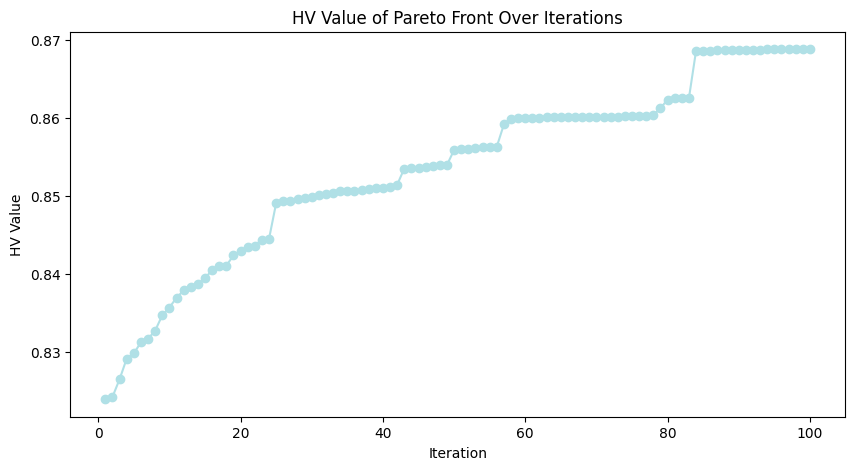

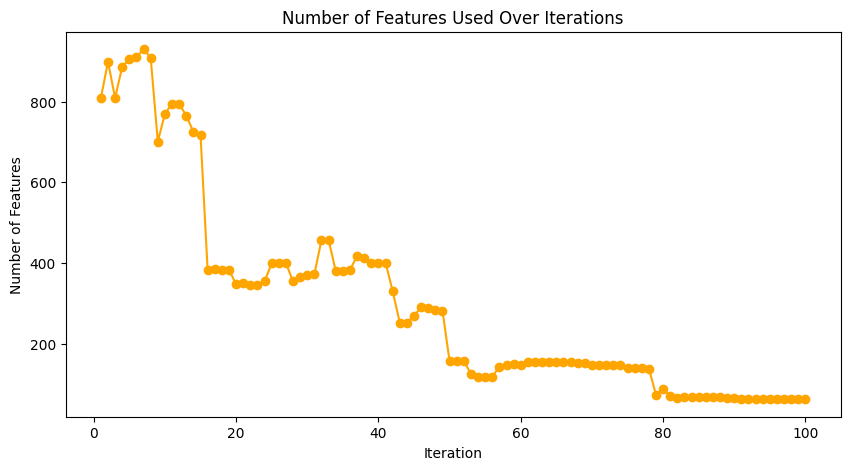

Total population members: 100
Pareto front members: 10


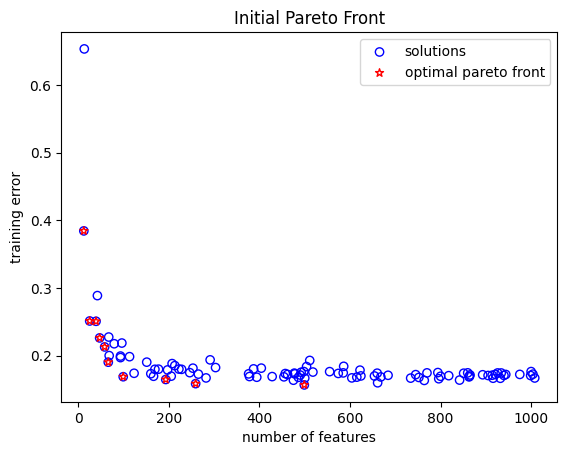

Total population members: 100
Pareto front members: 27


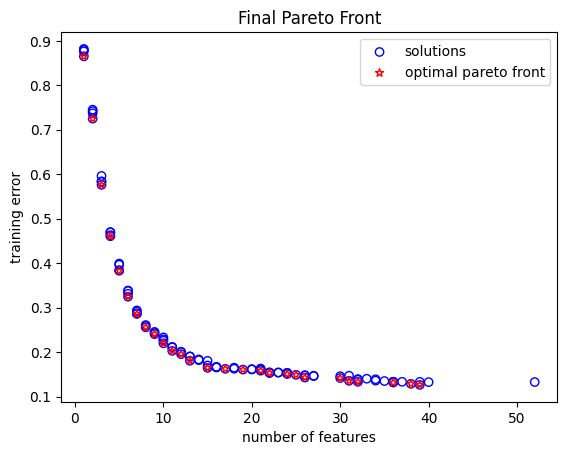

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [930]
classification error on train sets: 0.8651106403161689
classification error on test sets: 0.8693086145924847
solution 1:
number of selected features is: 3.0
corresponding indices: [803, 834, 930]
classification error on train sets: 0.576169049246523
classification error on test sets: 0.6283857741095875
solution 2:
number of selected features is: 4.0
corresponding indices: [803, 834, 930, 951]
classification error on train sets: 0.4607668002822578
classification error on test sets: 0.526654415317513
solution 3:
number of selected features is: 15.0
corresponding indices: [568, 600, 617, 803, 811, 832, 834, 851, 930, 951, 955, 976, 989, 1012, 1022]
classification error on train sets: 0.1648208881973483
classification error on test sets: 0.1881365876282144
solution 4:
number of selected features is: 24.0
corresponding indices: [11, 67

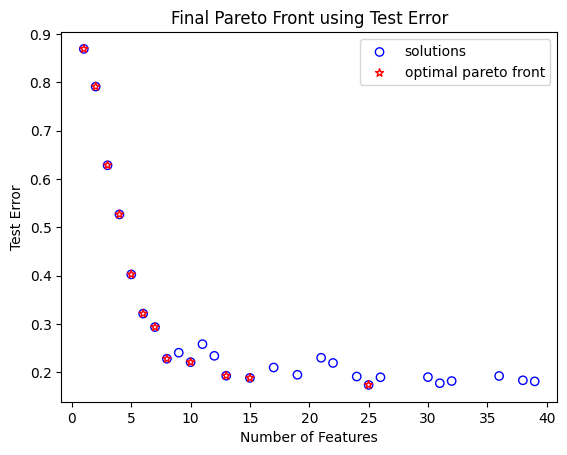

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [930], 'train_error': 0.8651106403161689, 'test_error': 0.8693086145924847}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [803, 834, 930], 'train_error': 0.576169049246523, 'test_error': 0.6283857741095875}, 2: {'num_selected_features': 4.0, 'selected_feature_indices': [803, 834, 930, 951], 'train_error': 0.4607668002822578, 'test_error': 0.526654415317513}, 3: {'num_selected_features': 15.0, 'selected_feature_indices': [568, 600, 617, 803, 811, 832, 834, 851, 930, 951, 955, 976, 989, 1012, 1022], 'train_error': 0.1648208881973483, 'test_error': 0.1881365876282144}, 4: {'num_selected_features': 24.0, 'selected_feature_indices': [11, 67, 139, 222, 486, 529, 600, 659, 700, 762, 763, 803, 811, 832, 834, 851, 930, 946, 951, 955, 976, 989, 1004, 1012], 'train_error': 0.15100234038627303, 'test_error': 0.1909915230366992}, 5: {'num_selected_features': 7.0, 'selected_feature_indices': [600, 803,

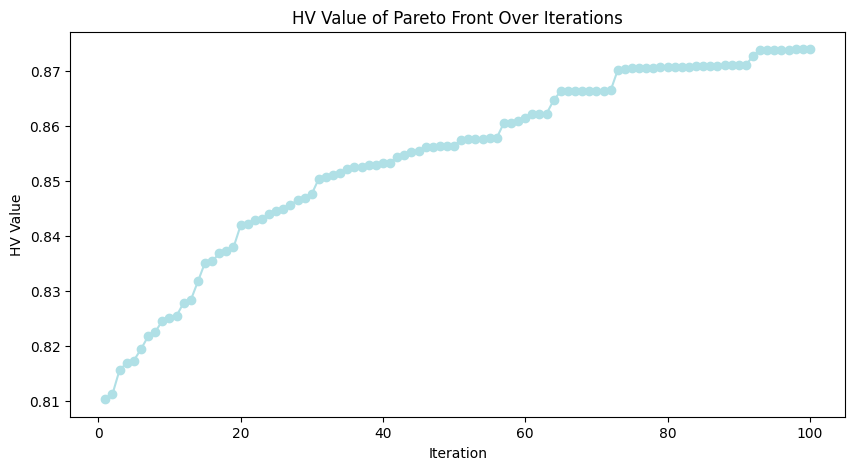

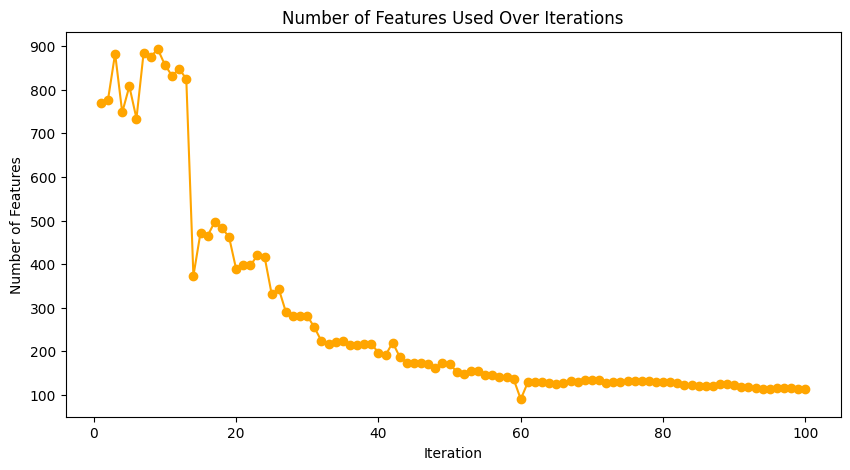

Total population members: 100
Pareto front members: 10


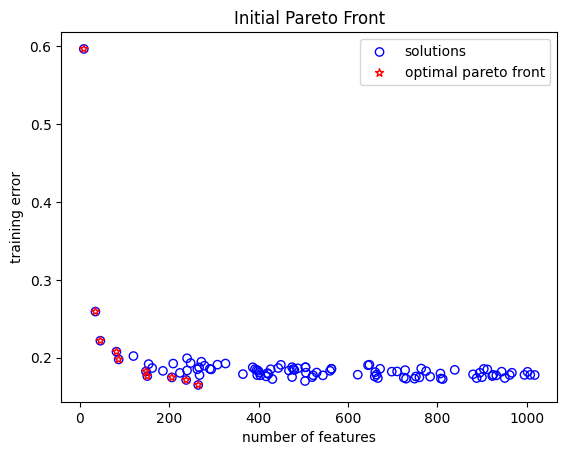

Total population members: 100
Pareto front members: 29


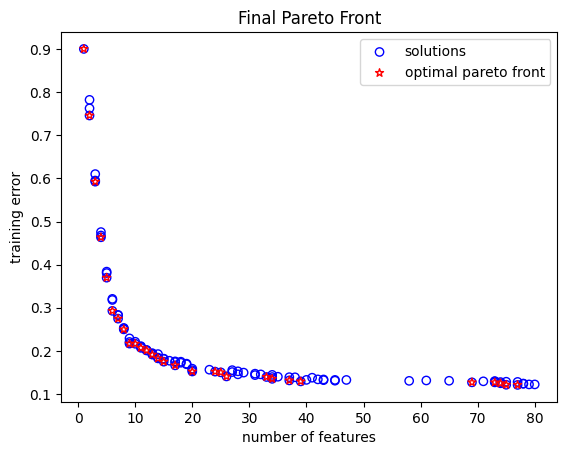

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 7.0
corresponding indices: [571, 585, 758, 802, 851, 956, 981]
classification error on train sets: 0.27471347971824256
classification error on test sets: 0.3117521622879549
solution 1:
number of selected features is: 8.0
corresponding indices: [571, 585, 594, 758, 802, 851, 956, 981]
classification error on train sets: 0.24988000261187915
classification error on test sets: 0.26878400228620347
solution 2:
number of selected features is: 4.0
corresponding indices: [758, 802, 851, 981]
classification error on train sets: 0.4635039516911339
classification error on test sets: 0.4691805015741751
solution 3:
number of selected features is: 5.0
corresponding indices: [758, 802, 851, 956, 981]
classification error on train sets: 0.3697540054095707
classification error on test sets: 0.39357892270130035
solution 4:
number of selected features is: 3.0
corresponding indices: 

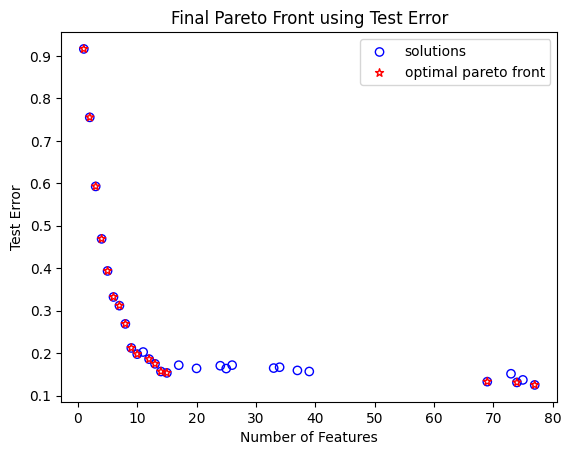

Final PF Results:  {0: {'num_selected_features': 7.0, 'selected_feature_indices': [571, 585, 758, 802, 851, 956, 981], 'train_error': 0.27471347971824256, 'test_error': 0.3117521622879549}, 1: {'num_selected_features': 8.0, 'selected_feature_indices': [571, 585, 594, 758, 802, 851, 956, 981], 'train_error': 0.24988000261187915, 'test_error': 0.26878400228620347}, 2: {'num_selected_features': 4.0, 'selected_feature_indices': [758, 802, 851, 981], 'train_error': 0.4635039516911339, 'test_error': 0.4691805015741751}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [758, 802, 851, 956, 981], 'train_error': 0.3697540054095707, 'test_error': 0.39357892270130035}, 4: {'num_selected_features': 3.0, 'selected_feature_indices': [758, 851, 981], 'train_error': 0.5924421554705663, 'test_error': 0.5927853824276068}, 5: {'num_selected_features': 1.0, 'selected_feature_indices': [851], 'train_error': 0.9004024090702955, 'test_error': 0.9168049852311284}, 6: {'num_selected_features': 14.

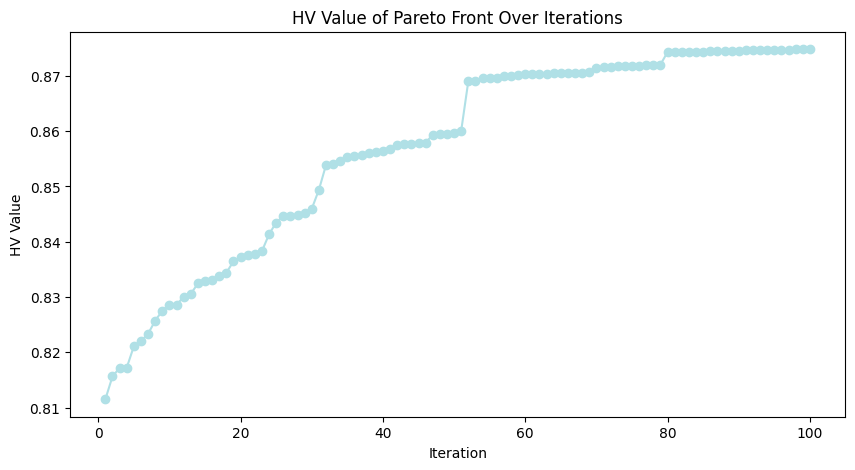

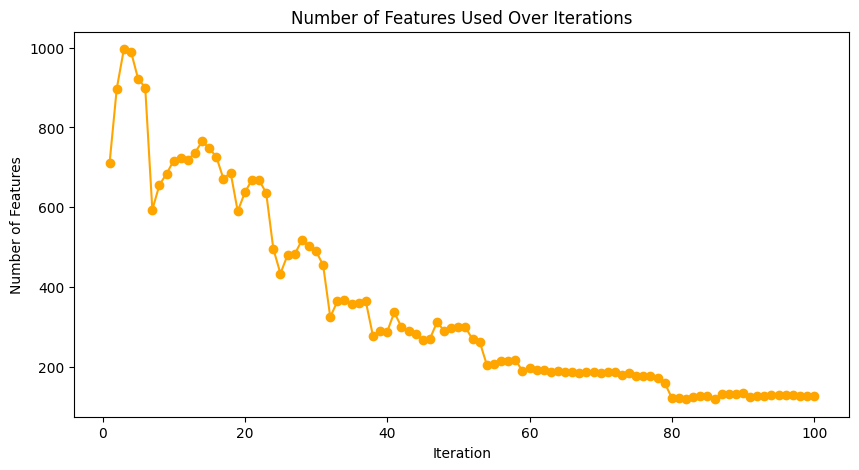

Total population members: 100
Pareto front members: 10


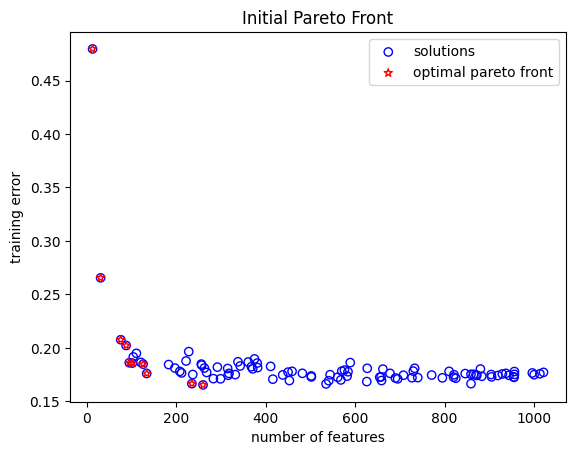

Total population members: 100
Pareto front members: 28


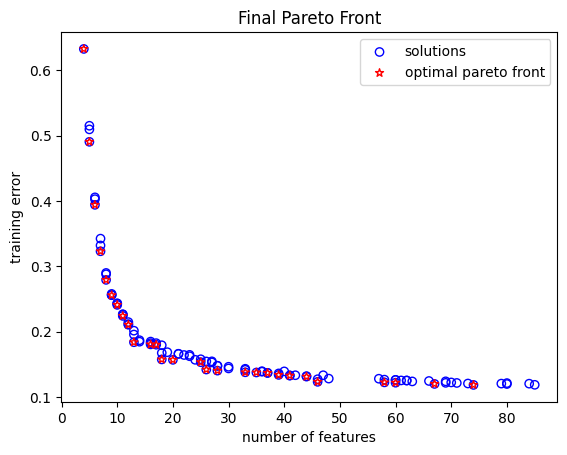

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 9.0
corresponding indices: [545, 605, 695, 698, 707, 808, 834, 846, 1003]
classification error on train sets: 0.2559510345739908
classification error on test sets: 0.3416356740879558
solution 1:
number of selected features is: 37.0
corresponding indices: [37, 144, 202, 218, 264, 297, 338, 414, 509, 545, 570, 605, 659, 669, 698, 707, 757, 766, 769, 773, 786, 814, 834, 841, 865, 879, 893, 897, 905, 907, 912, 955, 962, 972, 992, 1017, 1020]
classification error on train sets: 0.13705724103191608
classification error on test sets: 0.19345067755003031
solution 2:
number of selected features is: 74.0
corresponding indices: [32, 43, 69, 103, 119, 126, 144, 147, 178, 202, 218, 234, 264, 338, 366, 398, 405, 443, 457, 479, 482, 509, 535, 545, 562, 570, 574, 580, 588, 590, 594, 605, 617, 618, 621, 649, 669, 671, 673, 683, 698, 707, 709, 715, 756, 757, 766, 769, 773, 786, 80

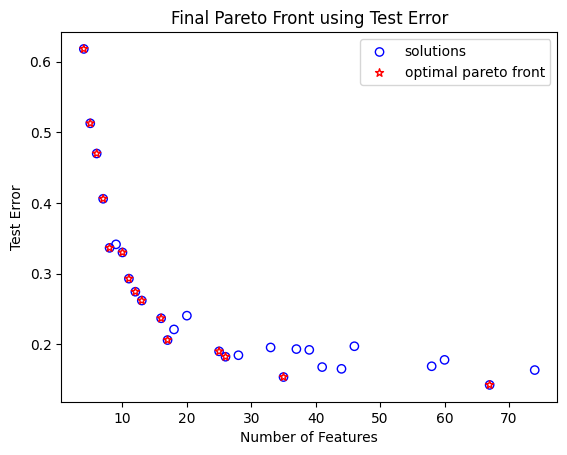

Final PF Results:  {0: {'num_selected_features': 9.0, 'selected_feature_indices': [545, 605, 695, 698, 707, 808, 834, 846, 1003], 'train_error': 0.2559510345739908, 'test_error': 0.3416356740879558}, 1: {'num_selected_features': 37.0, 'selected_feature_indices': [37, 144, 202, 218, 264, 297, 338, 414, 509, 545, 570, 605, 659, 669, 698, 707, 757, 766, 769, 773, 786, 814, 834, 841, 865, 879, 893, 897, 905, 907, 912, 955, 962, 972, 992, 1017, 1020], 'train_error': 0.13705724103191608, 'test_error': 0.19345067755003031}, 2: {'num_selected_features': 74.0, 'selected_feature_indices': [32, 43, 69, 103, 119, 126, 144, 147, 178, 202, 218, 234, 264, 338, 366, 398, 405, 443, 457, 479, 482, 509, 535, 545, 562, 570, 574, 580, 588, 590, 594, 605, 617, 618, 621, 649, 669, 671, 673, 683, 698, 707, 709, 715, 756, 757, 766, 769, 773, 786, 802, 815, 825, 834, 835, 841, 865, 874, 876, 879, 893, 897, 905, 907, 912, 942, 945, 949, 955, 962, 992, 1012, 1017, 1020], 'train_error': 0.11876226854823269, 'test_

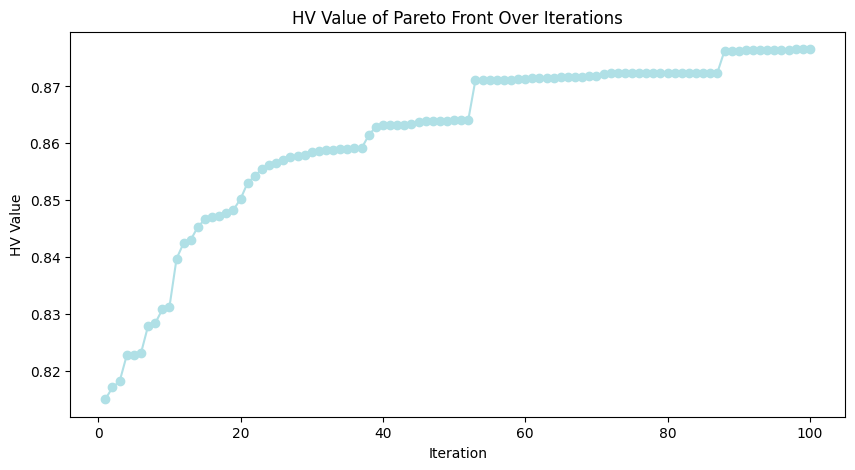

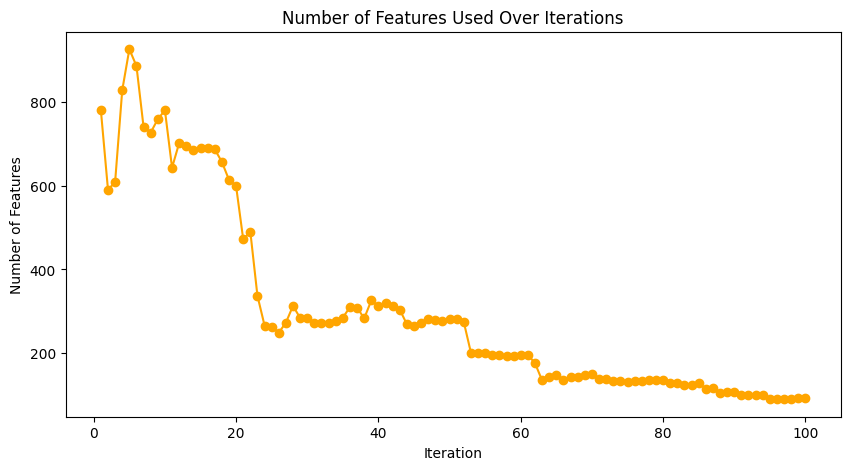

Total population members: 100
Pareto front members: 11


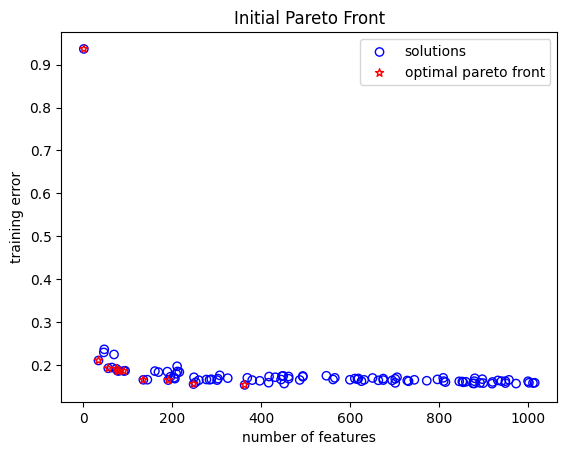

Total population members: 100
Pareto front members: 24


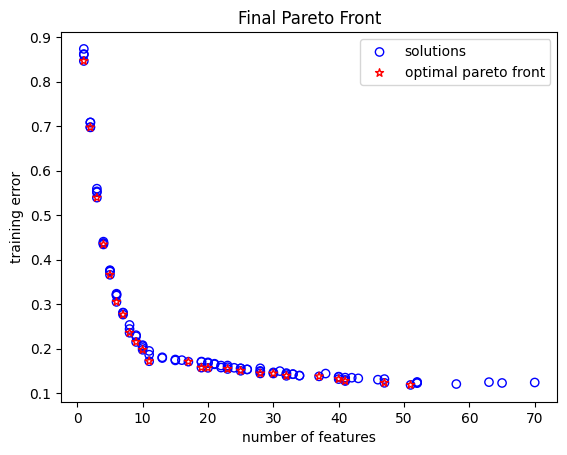

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [758]
classification error on train sets: 0.8466123497601616
classification error on test sets: 0.8750042676566512
solution 1:
number of selected features is: 2.0
corresponding indices: [758, 981]
classification error on train sets: 0.6973762886274981
classification error on test sets: 0.741969145609513
solution 2:
number of selected features is: 37.0
corresponding indices: [108, 176, 197, 199, 315, 358, 455, 484, 550, 559, 568, 609, 611, 631, 654, 668, 698, 734, 745, 756, 757, 761, 817, 819, 822, 833, 852, 871, 881, 897, 920, 927, 937, 947, 977, 981, 988]
classification error on train sets: 0.13789213302051928
classification error on test sets: 0.17980180124137723
solution 3:
number of selected features is: 3.0
corresponding indices: [758, 796, 981]
classification error on train sets: 0.5395181221573382
classification error on test set

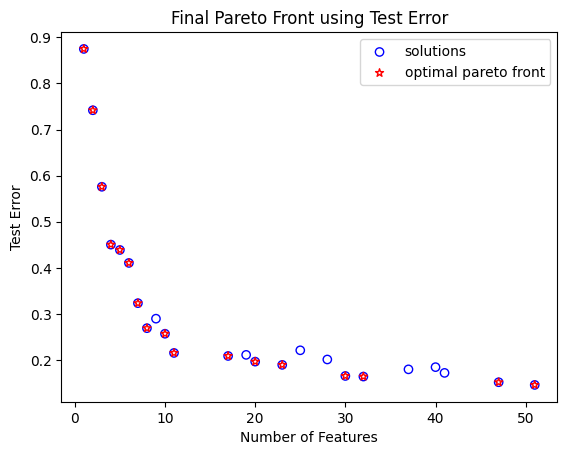

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [758], 'train_error': 0.8466123497601616, 'test_error': 0.8750042676566512}, 1: {'num_selected_features': 2.0, 'selected_feature_indices': [758, 981], 'train_error': 0.6973762886274981, 'test_error': 0.741969145609513}, 2: {'num_selected_features': 37.0, 'selected_feature_indices': [108, 176, 197, 199, 315, 358, 455, 484, 550, 559, 568, 609, 611, 631, 654, 668, 698, 734, 745, 756, 757, 761, 817, 819, 822, 833, 852, 871, 881, 897, 920, 927, 937, 947, 977, 981, 988], 'train_error': 0.13789213302051928, 'test_error': 0.17980180124137723}, 3: {'num_selected_features': 3.0, 'selected_feature_indices': [758, 796, 981], 'train_error': 0.5395181221573382, 'test_error': 0.5759107766786369}, 4: {'num_selected_features': 25.0, 'selected_feature_indices': [102, 267, 295, 426, 458, 529, 568, 609, 654, 675, 757, 758, 761, 780, 786, 798, 822, 862, 878, 899, 911, 916, 921, 935, 981], 'train_error': 0.15041874610642347, '

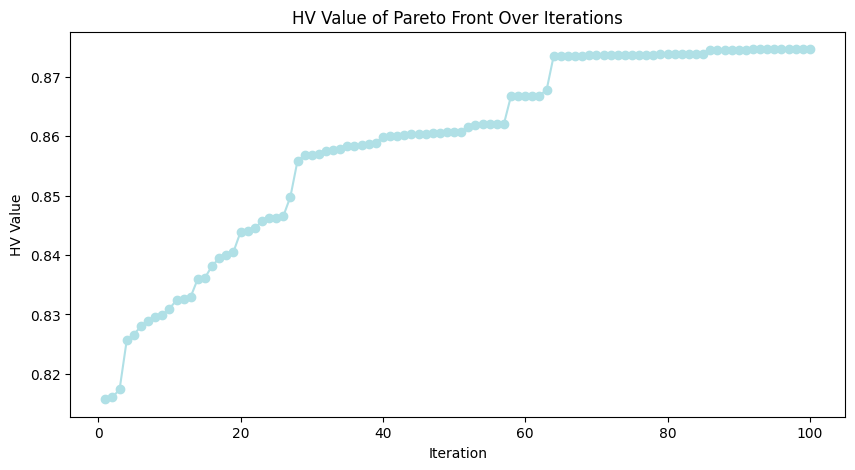

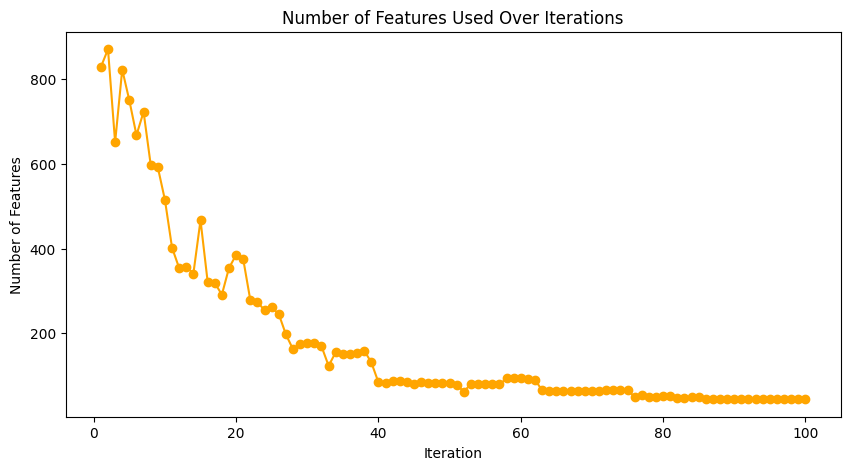

Total population members: 100
Pareto front members: 7


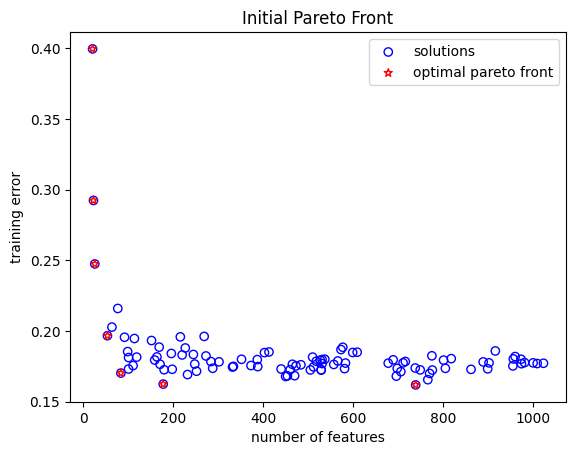

Total population members: 100
Pareto front members: 22


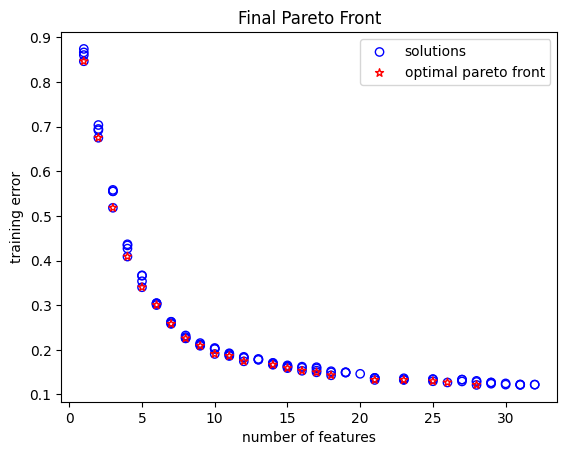

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [770]
classification error on train sets: 0.8466250031084395
classification error on test sets: 0.8542469088495934
solution 1:
number of selected features is: 5.0
corresponding indices: [568, 781, 849, 912, 1005]
classification error on train sets: 0.340227328007782
classification error on test sets: 0.3826497954972131
solution 2:
number of selected features is: 6.0
corresponding indices: [565, 568, 781, 849, 1018, 1022]
classification error on train sets: 0.30028912752293024
classification error on test sets: 0.368545828418282
solution 3:
number of selected features is: 9.0
corresponding indices: [565, 568, 584, 781, 930, 955, 957, 1005, 1022]
classification error on train sets: 0.20907511030733106
classification error on test sets: 0.22086771899930557
solution 4:
number of selected features is: 7.0
corresponding indices: [565, 568, 71

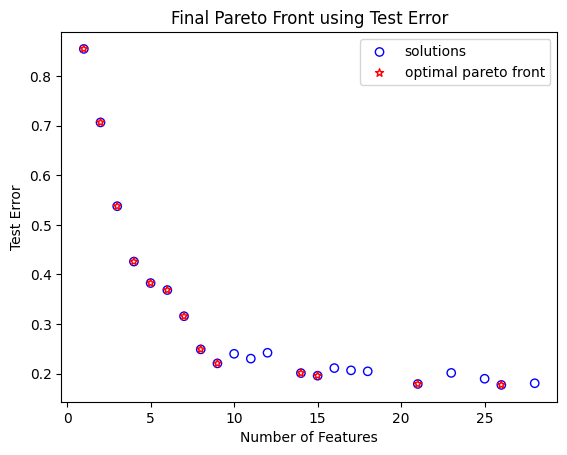

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [770], 'train_error': 0.8466250031084395, 'test_error': 0.8542469088495934}, 1: {'num_selected_features': 5.0, 'selected_feature_indices': [568, 781, 849, 912, 1005], 'train_error': 0.340227328007782, 'test_error': 0.3826497954972131}, 2: {'num_selected_features': 6.0, 'selected_feature_indices': [565, 568, 781, 849, 1018, 1022], 'train_error': 0.30028912752293024, 'test_error': 0.368545828418282}, 3: {'num_selected_features': 9.0, 'selected_feature_indices': [565, 568, 584, 781, 930, 955, 957, 1005, 1022], 'train_error': 0.20907511030733106, 'test_error': 0.22086771899930557}, 4: {'num_selected_features': 7.0, 'selected_feature_indices': [565, 568, 716, 781, 827, 957, 1005], 'train_error': 0.25804534706114524, 'test_error': 0.3158905823402893}, 5: {'num_selected_features': 25.0, 'selected_feature_indices': [24, 144, 250, 556, 557, 565, 600, 666, 677, 740, 771, 773, 781, 840, 849, 876, 899, 908, 912, 955,

In [71]:
# Run NSGA2 5 times to select features from kimianet valiation data w/ averaged features

# Read the dataset from the tab-separated file without headers
dataset_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
df = pd.read_csv(dataset_path)

# Assume that the first column contains the class labels
dclass = df.columns[0]

# Separate features (X) and target (y)
X = df.drop(columns=[dclass])
y = df[dclass]

for run in range(5):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: kimianet_validation_data_averaged_feature_vectors.csv"
    # Split the data into 70/30 train/test, ensuring proportional class distributions (using stratify)
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42+run)

    # Generate initial population members
    total_features = xtrain.shape[1] 
    print("TOTAL NUMBER OF FEATURES: ", total_features)
    custom_population = generate_individuals(total_features)
    population = Population.new("X", custom_population)

    # Set up NSGA2 algorithm
    problem = MyProblem(xtrain, ytrain)
    algorithm = NSGA2(pop_size=100,
                    sampling=population,
                    crossover=UniformCrossover(prob=0.9),
                    mutation=BitflipMutation(prob=0.01),
                    eliminate_duplicates=True)
    res = minimize(problem,
                algorithm,
                ("n_gen", 100),
                verbose=False,
                save_history=True)

    # Get data from NSGA2 algorithm
    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = nsga2_results(res, xtrain, ytrain, xtest, ytest)

    # Store NSGA2 results
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training)

************************************************** RUN 1 **************************************************
TOTAL NUMBER OF FEATURES:  1024
INDIVIDUAL 1, 304 features: [False False  True ... False  True False]
INDIVIDUAL 2, 118 features: [False False False ...  True False False]
INDIVIDUAL 3, 847 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 4, 762 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 5, 590 features: [False False  True ...  True False  True]
INDIVIDUAL 6, 174 features: [False False False ... False False False]
INDIVIDUAL 7, 283 features: [False False False ... False False False]
INDIVIDUAL 8, 1016 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 9, 545 features: [False  True False ... False  True False]
INDIVIDUAL 10, 860 features: [ True  True False ...  True  True False]
INDIVIDUAL 11, 611 features: [False  True  True ... False False  True]
INDIVIDUAL 12, 1014 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 13, 

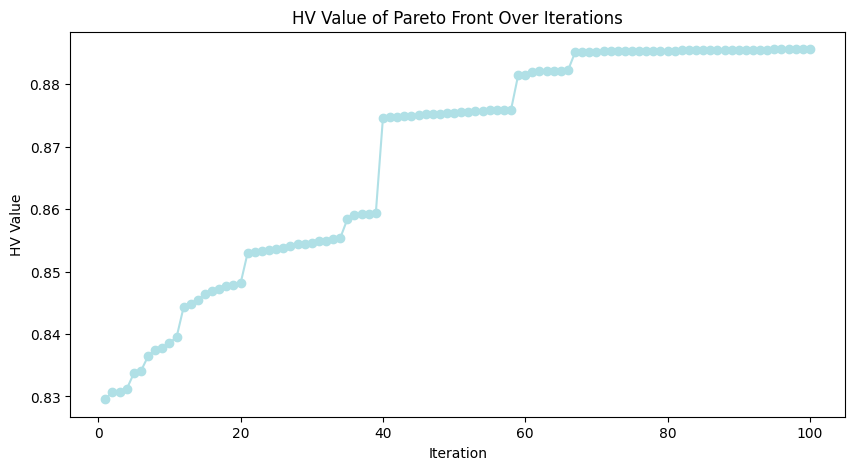

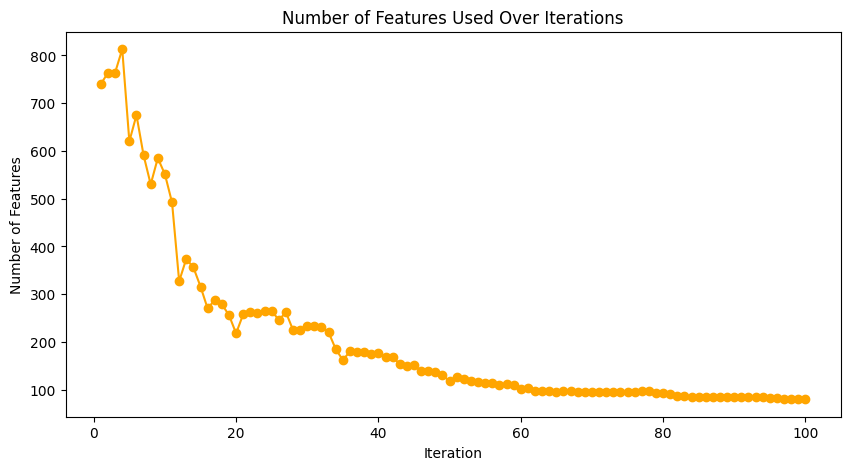

Total population members: 100
Pareto front members: 9


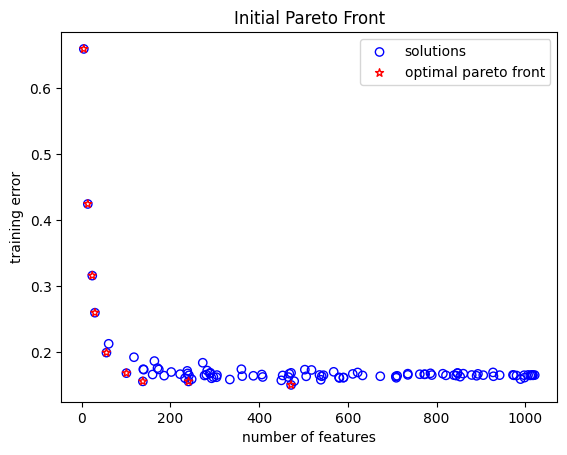

Total population members: 100
Pareto front members: 30


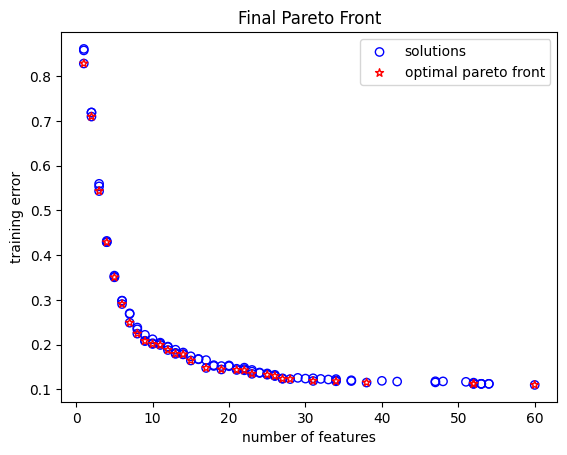

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [828]
classification error on train sets: 0.8285325323553037
classification error on test sets: 0.8505789414097331
solution 1:
number of selected features is: 3.0
corresponding indices: [828, 1014, 1017]
classification error on train sets: 0.5432709543270603
classification error on test sets: 0.5984845501447744
solution 2:
number of selected features is: 14.0
corresponding indices: [688, 697, 726, 758, 769, 886, 897, 899, 919, 936, 983, 1005, 1015, 1019]
classification error on train sets: 0.178104944615469
classification error on test sets: 0.20312110768837754
solution 3:
number of selected features is: 12.0
corresponding indices: [549, 561, 679, 680, 763, 828, 886, 955, 978, 996, 1014, 1015]
classification error on train sets: 0.18782293047212728
classification error on test sets: 0.2818545487804397
solution 4:
number of selected feat

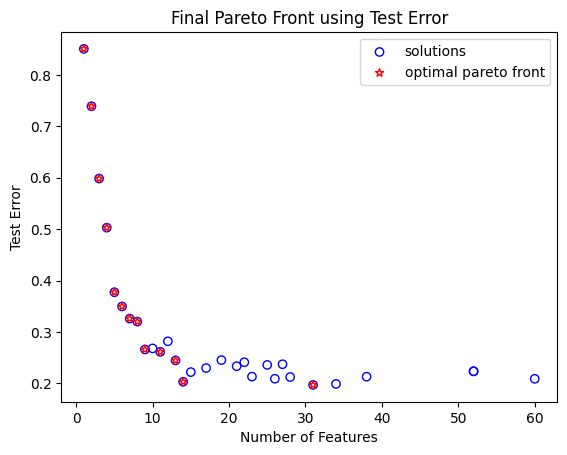

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [828], 'train_error': 0.8285325323553037, 'test_error': 0.8505789414097331}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [828, 1014, 1017], 'train_error': 0.5432709543270603, 'test_error': 0.5984845501447744}, 2: {'num_selected_features': 14.0, 'selected_feature_indices': [688, 697, 726, 758, 769, 886, 897, 899, 919, 936, 983, 1005, 1015, 1019], 'train_error': 0.178104944615469, 'test_error': 0.20312110768837754}, 3: {'num_selected_features': 12.0, 'selected_feature_indices': [549, 561, 679, 680, 763, 828, 886, 955, 978, 996, 1014, 1015], 'train_error': 0.18782293047212728, 'test_error': 0.2818545487804397}, 4: {'num_selected_features': 60.0, 'selected_feature_indices': [23, 34, 81, 126, 151, 184, 195, 251, 283, 291, 345, 364, 372, 393, 394, 440, 473, 537, 542, 546, 549, 561, 574, 578, 579, 588, 600, 609, 666, 671, 680, 684, 697, 709, 726, 728, 737, 752, 758, 762, 763, 769, 852, 863, 877

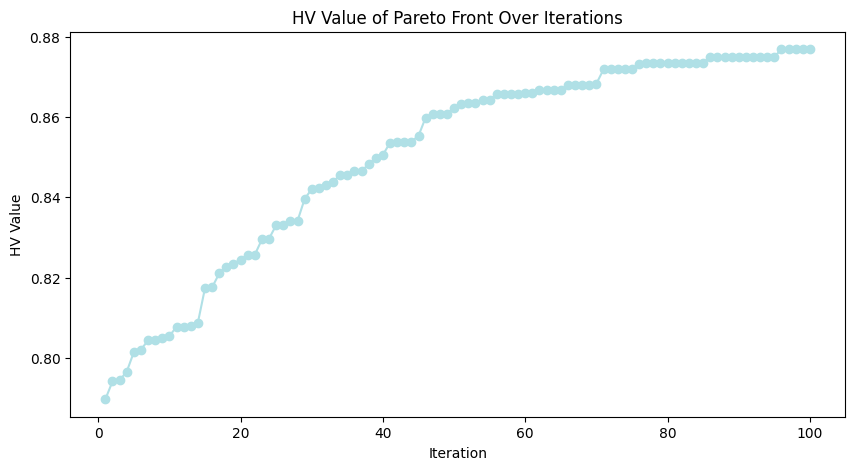

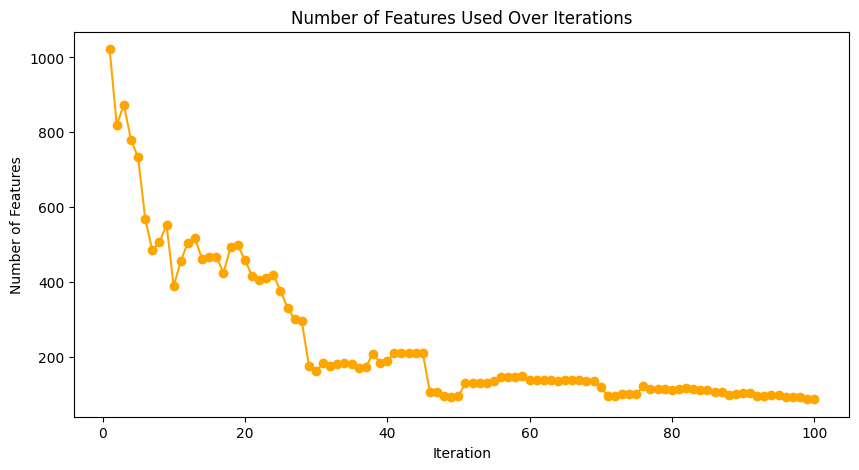

Total population members: 100
Pareto front members: 8


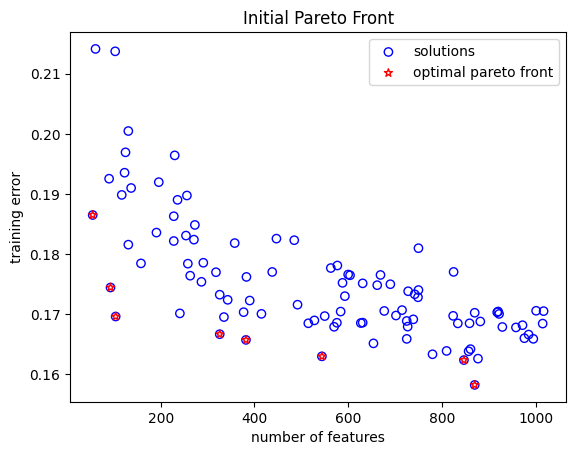

Total population members: 100
Pareto front members: 25


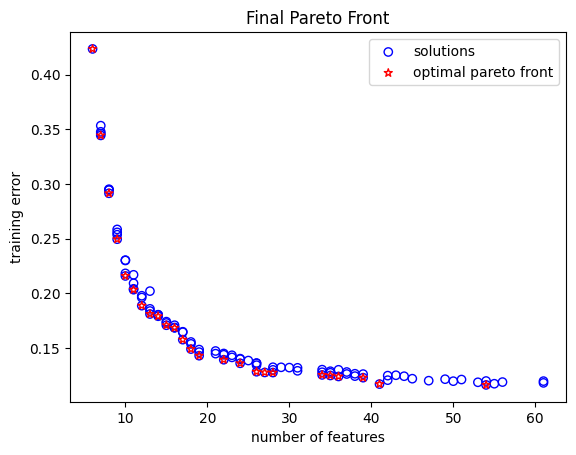

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 6.0
corresponding indices: [679, 832, 882, 918, 924, 1022]
classification error on train sets: 0.4235812850900781
classification error on test sets: 0.4223393148125786
solution 1:
number of selected features is: 22.0
corresponding indices: [25, 212, 585, 651, 672, 679, 702, 734, 737, 769, 781, 788, 795, 815, 832, 882, 918, 922, 924, 934, 977, 1022]
classification error on train sets: 0.13931030783217624
classification error on test sets: 0.19839164563062295
solution 2:
number of selected features is: 8.0
corresponding indices: [679, 697, 795, 832, 882, 918, 924, 1022]
classification error on train sets: 0.29154600476154413
classification error on test sets: 0.34292838815920024
solution 3:
number of selected features is: 16.0
corresponding indices: [651, 672, 679, 737, 759, 781, 788, 795, 832, 882, 918, 922, 924, 934, 969, 1022]
classification error on train sets:

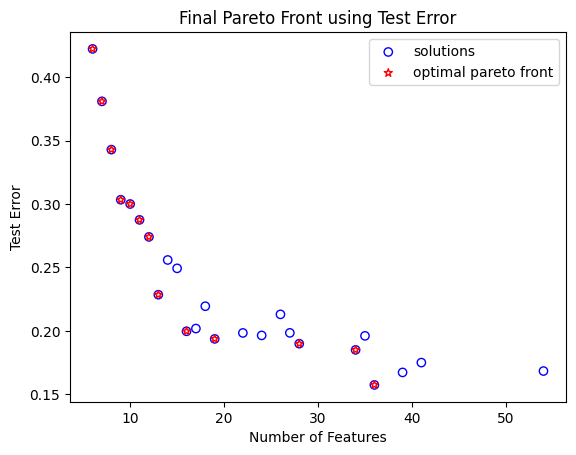

Final PF Results:  {0: {'num_selected_features': 6.0, 'selected_feature_indices': [679, 832, 882, 918, 924, 1022], 'train_error': 0.4235812850900781, 'test_error': 0.4223393148125786}, 1: {'num_selected_features': 22.0, 'selected_feature_indices': [25, 212, 585, 651, 672, 679, 702, 734, 737, 769, 781, 788, 795, 815, 832, 882, 918, 922, 924, 934, 977, 1022], 'train_error': 0.13931030783217624, 'test_error': 0.19839164563062295}, 2: {'num_selected_features': 8.0, 'selected_feature_indices': [679, 697, 795, 832, 882, 918, 924, 1022], 'train_error': 0.29154600476154413, 'test_error': 0.34292838815920024}, 3: {'num_selected_features': 16.0, 'selected_feature_indices': [651, 672, 679, 737, 759, 781, 788, 795, 832, 882, 918, 922, 924, 934, 969, 1022], 'train_error': 0.16846198397194745, 'test_error': 0.1997007921408186}, 4: {'num_selected_features': 9.0, 'selected_feature_indices': [679, 697, 773, 795, 832, 882, 918, 924, 1022], 'train_error': 0.2495671307941687, 'test_error': 0.3034285230349

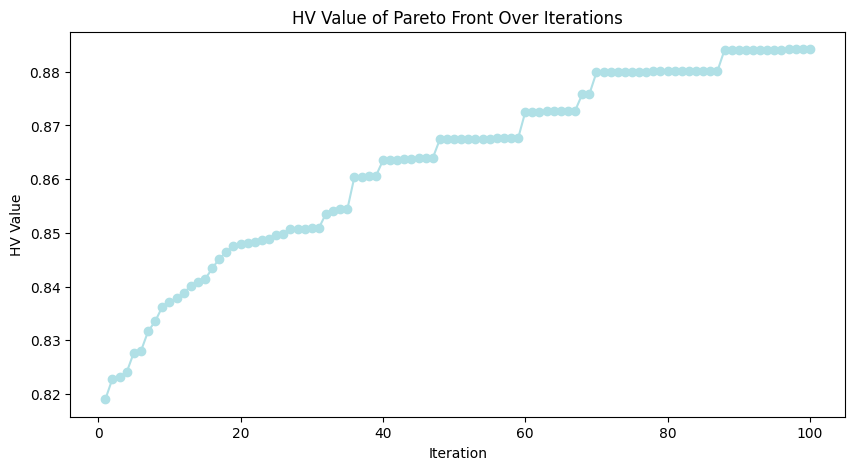

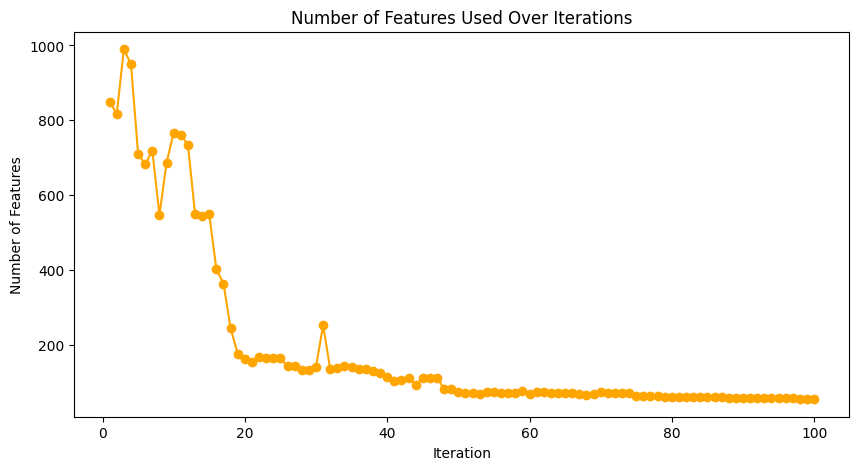

Total population members: 100
Pareto front members: 11


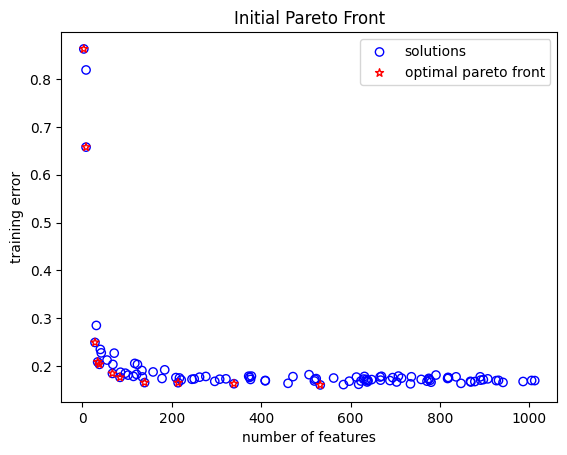

Total population members: 100
Pareto front members: 26


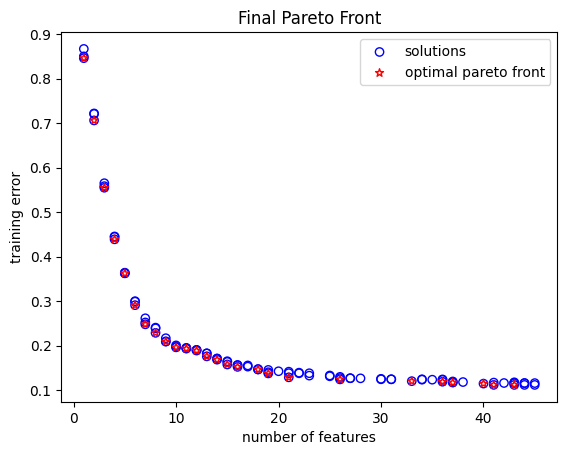

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding indices: [849, 998]
classification error on train sets: 0.706215295710287
classification error on test sets: 0.736534964812059
solution 1:
number of selected features is: 1.0
corresponding indices: [579]
classification error on train sets: 0.8462784848705255
classification error on test sets: 0.8445049263758941
solution 2:
number of selected features is: 4.0
corresponding indices: [849, 976, 1001, 1019]
classification error on train sets: 0.4388075253857161
classification error on test sets: 0.4909245868640746
solution 3:
number of selected features is: 5.0
corresponding indices: [849, 940, 970, 976, 1001]
classification error on train sets: 0.3622903813021059
classification error on test sets: 0.45060115321213834
solution 4:
number of selected features is: 13.0
corresponding indices: [545, 548, 722, 757, 849, 855, 918, 940, 953, 970, 976, 1001,

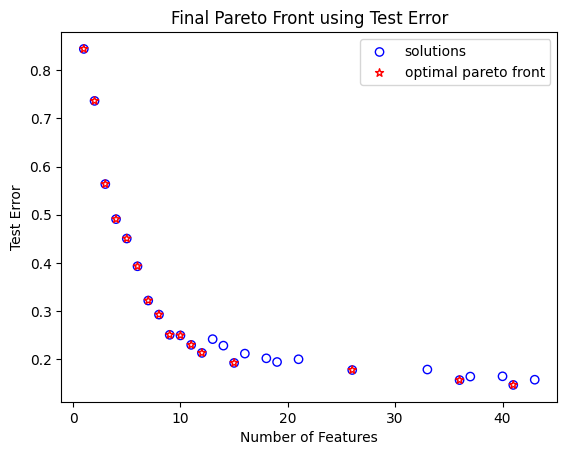

Final PF Results:  {0: {'num_selected_features': 2.0, 'selected_feature_indices': [849, 998], 'train_error': 0.706215295710287, 'test_error': 0.736534964812059}, 1: {'num_selected_features': 1.0, 'selected_feature_indices': [579], 'train_error': 0.8462784848705255, 'test_error': 0.8445049263758941}, 2: {'num_selected_features': 4.0, 'selected_feature_indices': [849, 976, 1001, 1019], 'train_error': 0.4388075253857161, 'test_error': 0.4909245868640746}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [849, 940, 970, 976, 1001], 'train_error': 0.3622903813021059, 'test_error': 0.45060115321213834}, 4: {'num_selected_features': 13.0, 'selected_feature_indices': [545, 548, 722, 757, 849, 855, 918, 940, 953, 970, 976, 1001, 1002], 'train_error': 0.17556803568791324, 'test_error': 0.24159924644733255}, 5: {'num_selected_features': 26.0, 'selected_feature_indices': [137, 418, 545, 548, 579, 604, 726, 757, 766, 788, 845, 849, 883, 918, 931, 940, 946, 953, 955, 959, 970, 976, 1002

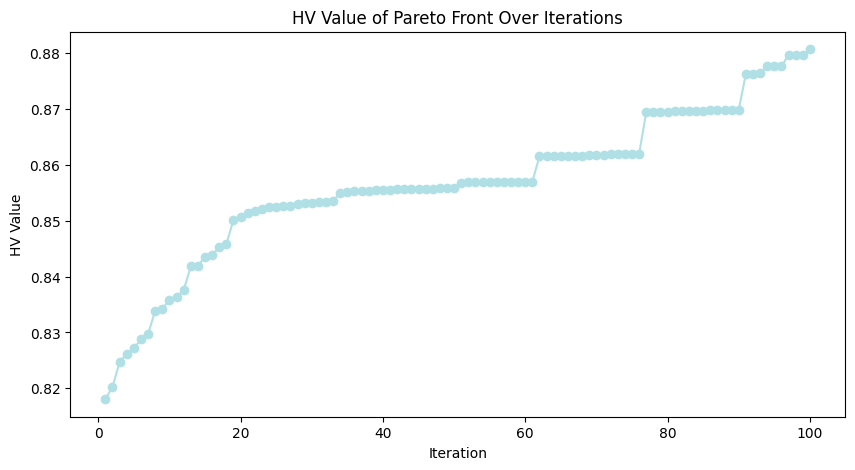

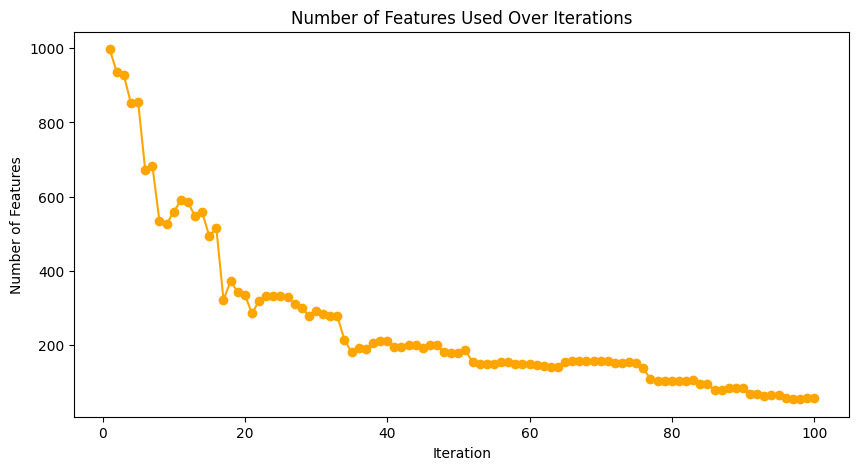

Total population members: 100
Pareto front members: 14


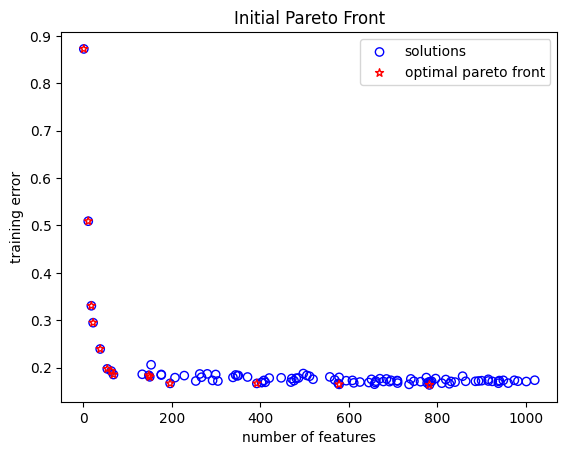

Total population members: 100
Pareto front members: 27


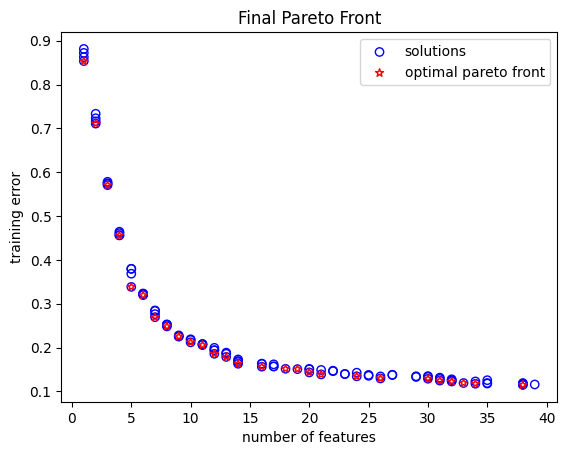

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [708]
classification error on train sets: 0.8537194911659449
classification error on test sets: 0.8736587515244065
solution 1:
number of selected features is: 9.0
corresponding indices: [708, 752, 781, 797, 849, 911, 957, 969, 996]
classification error on train sets: 0.22525303202114522
classification error on test sets: 0.20793782592021082
solution 2:
number of selected features is: 4.0
corresponding indices: [849, 911, 957, 996]
classification error on train sets: 0.4558742843913398
classification error on test sets: 0.43812842168803756
solution 3:
number of selected features is: 5.0
corresponding indices: [708, 849, 911, 957, 996]
classification error on train sets: 0.33839986385293497
classification error on test sets: 0.3974221201694985
solution 4:
number of selected features is: 2.0
corresponding indices: [708, 996]
classification

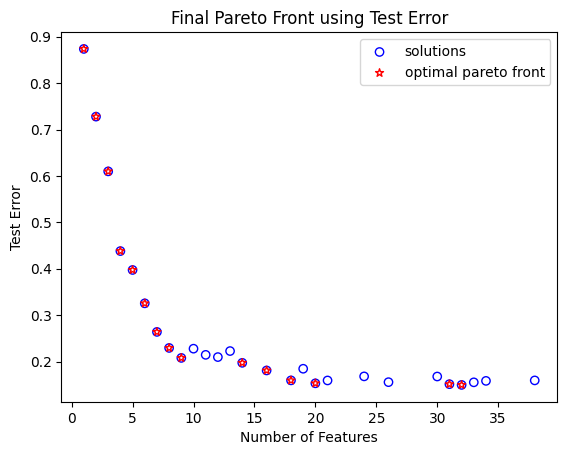

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [708], 'train_error': 0.8537194911659449, 'test_error': 0.8736587515244065}, 1: {'num_selected_features': 9.0, 'selected_feature_indices': [708, 752, 781, 797, 849, 911, 957, 969, 996], 'train_error': 0.22525303202114522, 'test_error': 0.20793782592021082}, 2: {'num_selected_features': 4.0, 'selected_feature_indices': [849, 911, 957, 996], 'train_error': 0.4558742843913398, 'test_error': 0.43812842168803756}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [708, 849, 911, 957, 996], 'train_error': 0.33839986385293497, 'test_error': 0.3974221201694985}, 4: {'num_selected_features': 2.0, 'selected_feature_indices': [708, 996], 'train_error': 0.710991738366547, 'test_error': 0.7277775753195714}, 5: {'num_selected_features': 3.0, 'selected_feature_indices': [708, 797, 849], 'train_error': 0.5705512599103824, 'test_error': 0.6098688604755678}, 6: {'num_selected_features': 13.0, 'selected_feature_

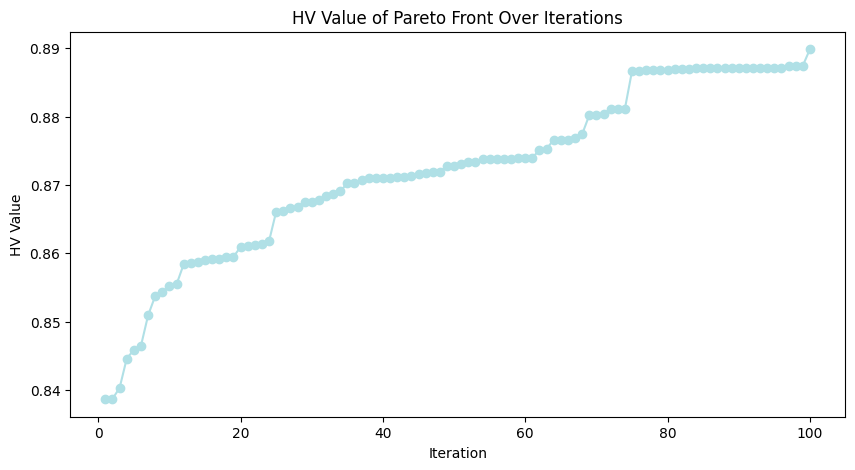

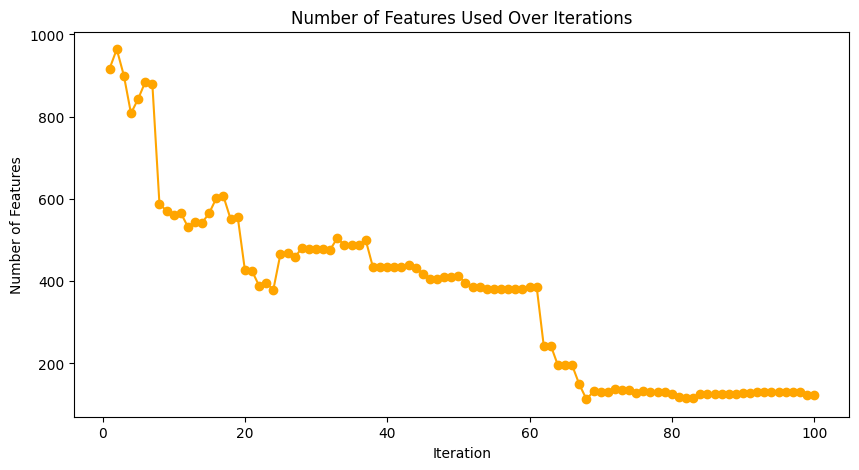

Total population members: 100
Pareto front members: 11


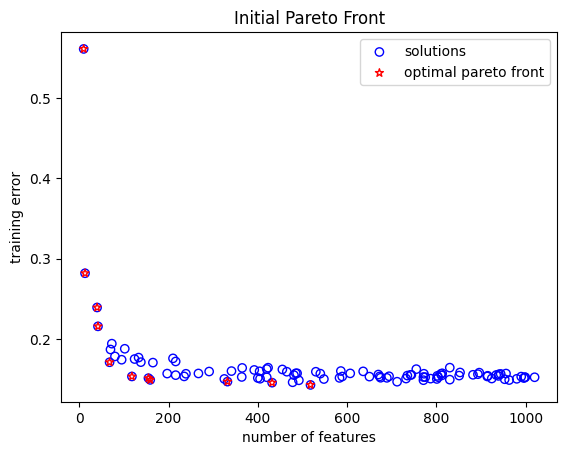

Total population members: 100
Pareto front members: 32


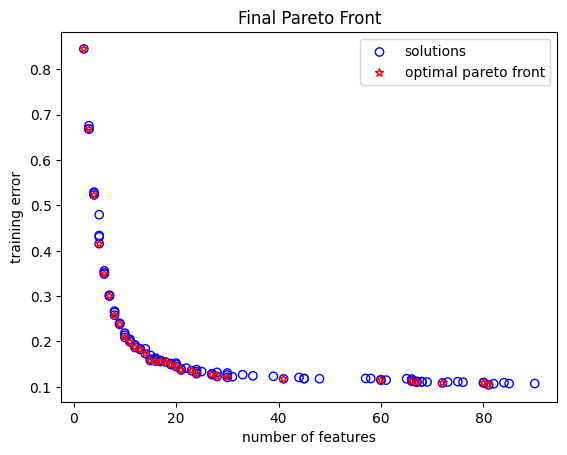

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 3.0
corresponding indices: [465, 899, 1005]
classification error on train sets: 0.6683872217337956
classification error on test sets: 0.6767057334289932
solution 1:
number of selected features is: 6.0
corresponding indices: [465, 725, 736, 849, 852, 1005]
classification error on train sets: 0.34871245327897515
classification error on test sets: 0.4605431305724015
solution 2:
number of selected features is: 2.0
corresponding indices: [465, 1005]
classification error on train sets: 0.8452653309337863
classification error on test sets: 0.8191101114520087
solution 3:
number of selected features is: 8.0
corresponding indices: [465, 725, 793, 849, 852, 899, 960, 1005]
classification error on train sets: 0.2580507784858356
classification error on test sets: 0.3145339151841433
solution 4:
number of selected features is: 30.0
corresponding indices: [78, 122, 235, 275, 356

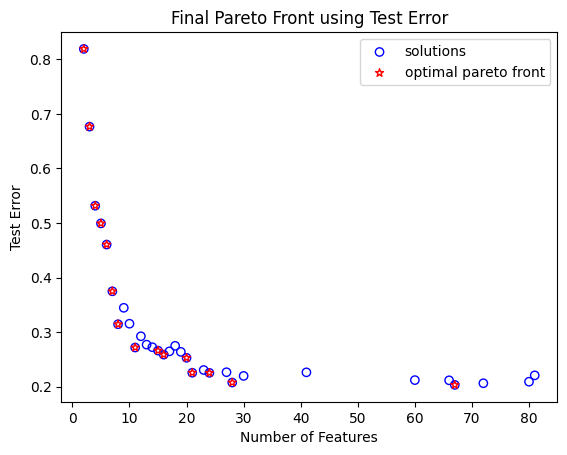

Final PF Results:  {0: {'num_selected_features': 3.0, 'selected_feature_indices': [465, 899, 1005], 'train_error': 0.6683872217337956, 'test_error': 0.6767057334289932}, 1: {'num_selected_features': 6.0, 'selected_feature_indices': [465, 725, 736, 849, 852, 1005], 'train_error': 0.34871245327897515, 'test_error': 0.4605431305724015}, 2: {'num_selected_features': 2.0, 'selected_feature_indices': [465, 1005], 'train_error': 0.8452653309337863, 'test_error': 0.8191101114520087}, 3: {'num_selected_features': 8.0, 'selected_feature_indices': [465, 725, 793, 849, 852, 899, 960, 1005], 'train_error': 0.2580507784858356, 'test_error': 0.3145339151841433}, 4: {'num_selected_features': 30.0, 'selected_feature_indices': [78, 122, 235, 275, 356, 372, 465, 482, 618, 637, 675, 692, 725, 757, 769, 786, 793, 849, 893, 899, 924, 939, 951, 952, 953, 960, 982, 1002, 1005, 1006], 'train_error': 0.12088670485912312, 'test_error': 0.2198140968948059}, 5: {'num_selected_features': 7.0, 'selected_feature_indi

In [75]:
# Run NSGA2 5 times AGAIN to select features from kimianet valiation data w/ averaged features

# Read the dataset from the tab-separated file without headers
dataset_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
df = pd.read_csv(dataset_path)

# Assume that the first column contains the class labels
dclass = df.columns[0]

# Separate features (X) and target (y)
X = df.drop(columns=[dclass])
y = df[dclass]

for run in range(5):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: kimianet_validation_data_averaged_feature_vectors.csv"
    # Split the data into 70/30 train/test, ensuring proportional class distributions (using stratify)
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=13+run)

    # Generate initial population members
    total_features = xtrain.shape[1] 
    print("TOTAL NUMBER OF FEATURES: ", total_features)
    custom_population = generate_individuals(total_features)
    population = Population.new("X", custom_population)

    # Set up NSGA2 algorithm
    problem = MyProblem(xtrain, ytrain)
    algorithm = NSGA2(pop_size=100,
                    sampling=population,
                    crossover=UniformCrossover(prob=0.9),
                    mutation=BitflipMutation(prob=0.01),
                    eliminate_duplicates=True)
    res = minimize(problem,
                algorithm,
                ("n_gen", 100),
                verbose=False,
                save_history=True)

    # Get data from NSGA2 algorithm
    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = nsga2_results(res, xtrain, ytrain, xtest, ytest)

    # Store NSGA2 results
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training)

In [91]:
# Fetch results of all 10 NSGA2 runs and sort features based on how frequently they appeared in the final Pareto Front of each run
csv_file_path = 'data.csv'  
df = pd.read_csv(csv_file_path)
filtered_df = df.iloc[20:30] # rows with kimianet NSGA runs
total_feature_freq = Counter()
for feature_freq_str in filtered_df['Feature Frequency']:
    feature_freq_pairs = feature_freq_str.split(', ')
    for pair in feature_freq_pairs:
        feature, freq = pair.split(': ')
        total_feature_freq[int(feature)] += int(freq)
sorted_feature_freq = sorted(total_feature_freq.items(), key=lambda x: x[1], reverse=True)
rank=1
for feature, freq in sorted_feature_freq:
    print(f"Rank {rank} - Feature {feature}: {freq} occurrence(s)")
    rank+=1


# use all features; calculate training/testing error

'''
use whole validation, calculate PF of final run, for each solution in PF, calculate error using just test set
rn, we're calculating knn accuracy in each generation using just the training set of the validation set (70%). Instead, don't split validation into train/test. Just evaluate knn using all validation.
Once we have final pareto front. Go through each solution in the pareto front and make a knn for that using JUST test set. Then, evaluate results.'''


Rank 1 - Feature 955: 92 occurrence(s)
Rank 2 - Feature 1022: 80 occurrence(s)
Rank 3 - Feature 1005: 80 occurrence(s)
Rank 4 - Feature 849: 75 occurrence(s)
Rank 5 - Feature 957: 69 occurrence(s)
Rank 6 - Feature 781: 67 occurrence(s)
Rank 7 - Feature 834: 60 occurrence(s)
Rank 8 - Feature 773: 60 occurrence(s)
Rank 9 - Feature 962: 57 occurrence(s)
Rank 10 - Feature 832: 54 occurrence(s)
Rank 11 - Feature 545: 53 occurrence(s)
Rank 12 - Feature 757: 52 occurrence(s)
Rank 13 - Feature 769: 52 occurrence(s)
Rank 14 - Feature 918: 52 occurrence(s)
Rank 15 - Feature 899: 51 occurrence(s)
Rank 16 - Feature 924: 46 occurrence(s)
Rank 17 - Feature 1017: 44 occurrence(s)
Rank 18 - Feature 763: 43 occurrence(s)
Rank 19 - Feature 793: 43 occurrence(s)
Rank 20 - Feature 879: 42 occurrence(s)
Rank 21 - Feature 698: 42 occurrence(s)
Rank 22 - Feature 851: 41 occurrence(s)
Rank 23 - Feature 976: 41 occurrence(s)
Rank 24 - Feature 786: 41 occurrence(s)
Rank 25 - Feature 737: 41 occurrence(s)
Rank 2

************************************************** RUN 1 **************************************************
TOTAL NUMBER OF FEATURES:  1024
INDIVIDUAL 1, 628 features: [ True  True  True ... False False False]
INDIVIDUAL 2, 540 features: [ True False False ...  True  True  True]
INDIVIDUAL 3, 790 features: [ True  True  True ...  True False  True]
INDIVIDUAL 4, 718 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 5, 46 features: [False False False ... False False False]
INDIVIDUAL 6, 932 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 7, 120 features: [False False False ... False False False]
INDIVIDUAL 8, 39 features: [False False False ... False False False]
INDIVIDUAL 9, 574 features: [False False False ...  True  True  True]
INDIVIDUAL 10, 187 features: [False False False ...  True False False]
INDIVIDUAL 11, 681 features: [ True  True  True ... False  True  True]
INDIVIDUAL 12, 957 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 13, 278 

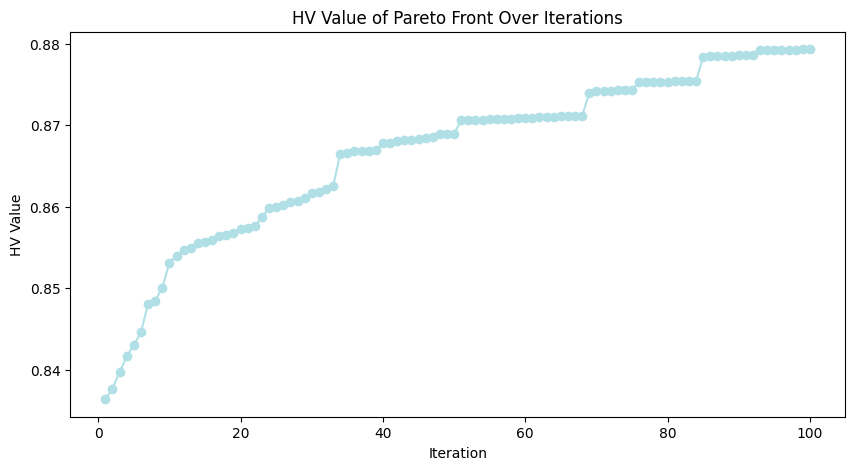

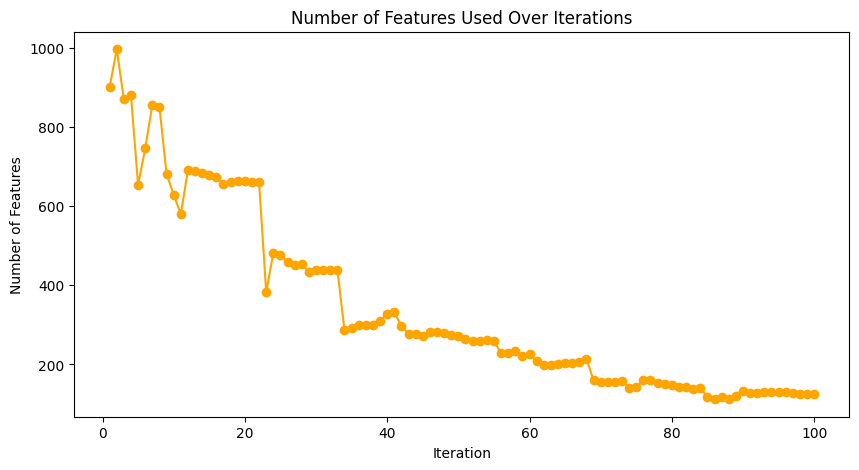

Total population members: 100
Pareto front members: 13


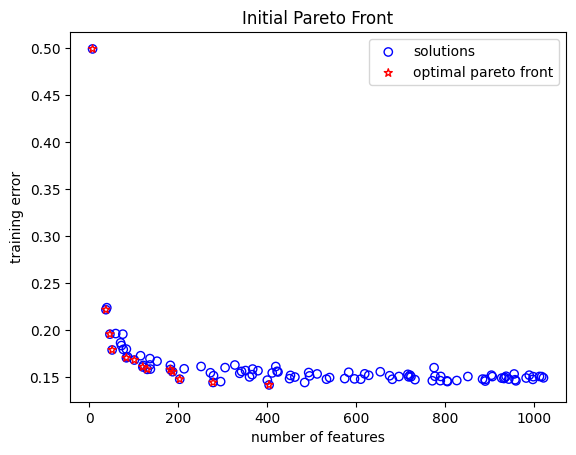

Total population members: 100
Pareto front members: 32


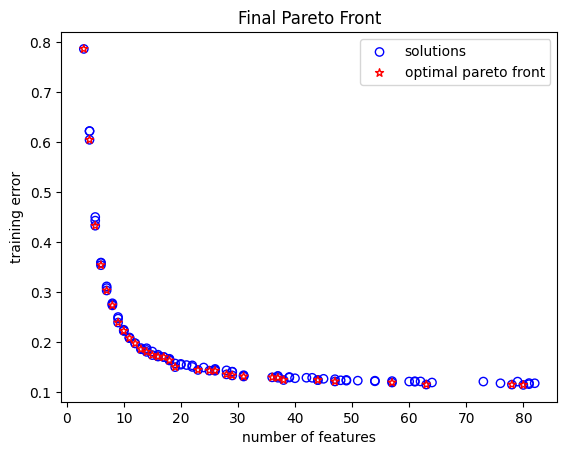

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding indices: [275, 930, 933, 996]
classification error on train sets: 0.6050963306953738
classification error on test sets: 0.611804288961735
solution 1:
number of selected features is: 5.0
corresponding indices: [275, 625, 930, 933, 996]
classification error on train sets: 0.4331901815366226
classification error on test sets: 0.49879853431827736
solution 2:
number of selected features is: 11.0
corresponding indices: [275, 625, 657, 734, 855, 862, 869, 930, 933, 996, 1022]
classification error on train sets: 0.2081930342207643
classification error on test sets: 0.2680796727235212
solution 3:
number of selected features is: 6.0
corresponding indices: [275, 734, 930, 933, 987, 996]
classification error on train sets: 0.35419665015236
classification error on test sets: 0.3855136218362888
solution 4:
number of selected features is: 8.0
corresponding ind

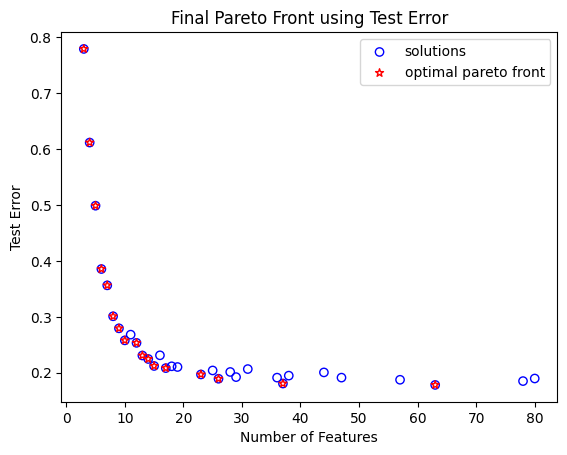

Final PF Results:  {0: {'num_selected_features': 4.0, 'selected_feature_indices': [275, 930, 933, 996], 'train_error': 0.6050963306953738, 'test_error': 0.611804288961735}, 1: {'num_selected_features': 5.0, 'selected_feature_indices': [275, 625, 930, 933, 996], 'train_error': 0.4331901815366226, 'test_error': 0.49879853431827736}, 2: {'num_selected_features': 11.0, 'selected_feature_indices': [275, 625, 657, 734, 855, 862, 869, 930, 933, 996, 1022], 'train_error': 0.2081930342207643, 'test_error': 0.2680796727235212}, 3: {'num_selected_features': 6.0, 'selected_feature_indices': [275, 734, 930, 933, 987, 996], 'train_error': 0.35419665015236, 'test_error': 0.3855136218362888}, 4: {'num_selected_features': 8.0, 'selected_feature_indices': [275, 625, 855, 930, 933, 962, 996, 1022], 'train_error': 0.2737690513499247, 'test_error': 0.3009545530171993}, 5: {'num_selected_features': 9.0, 'selected_feature_indices': [275, 625, 734, 855, 869, 930, 933, 996, 1022], 'train_error': 0.239472719739

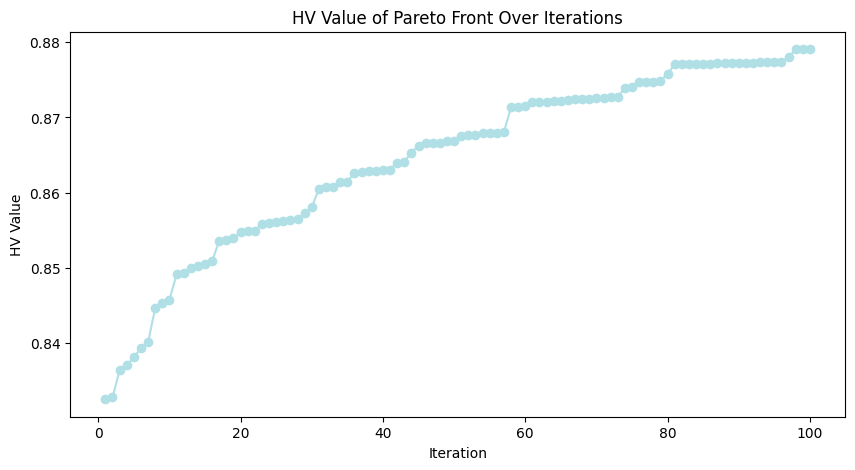

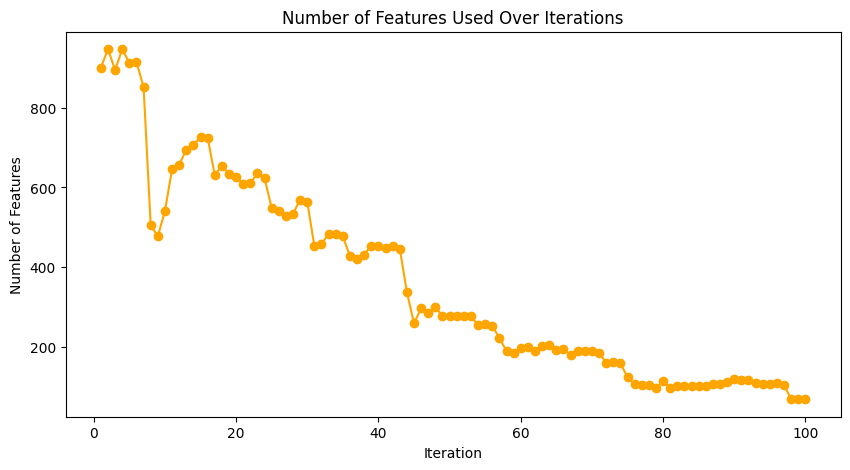

Total population members: 100
Pareto front members: 13


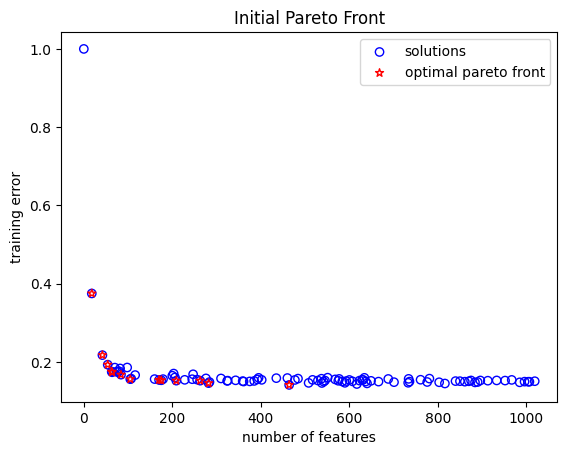

Total population members: 100
Pareto front members: 20


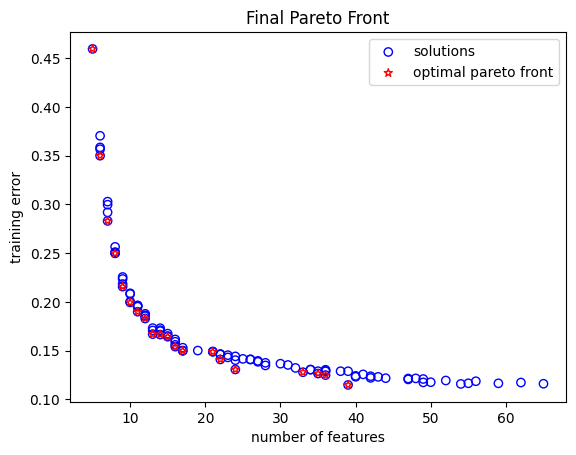

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 5.0
corresponding indices: [794, 909, 937, 947, 989]
classification error on train sets: 0.45968470736334466
classification error on test sets: 0.4918286885670491
solution 1:
number of selected features is: 6.0
corresponding indices: [794, 909, 937, 947, 959, 989]
classification error on train sets: 0.35006884826329165
classification error on test sets: 0.3769246999727771
solution 2:
number of selected features is: 33.0
corresponding indices: [98, 252, 509, 513, 566, 589, 625, 631, 657, 707, 715, 726, 760, 787, 794, 817, 819, 834, 837, 841, 880, 881, 896, 902, 909, 935, 937, 947, 978, 982, 989, 996, 1022]
classification error on train sets: 0.12785315434884925
classification error on test sets: 0.1859849025203073
solution 3:
number of selected features is: 7.0
corresponding indices: [787, 794, 909, 937, 947, 959, 989]
classification error on train sets: 0.2831293

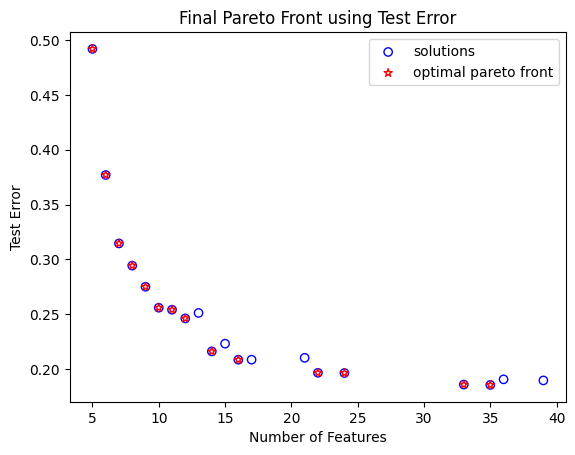

Final PF Results:  {0: {'num_selected_features': 5.0, 'selected_feature_indices': [794, 909, 937, 947, 989], 'train_error': 0.45968470736334466, 'test_error': 0.4918286885670491}, 1: {'num_selected_features': 6.0, 'selected_feature_indices': [794, 909, 937, 947, 959, 989], 'train_error': 0.35006884826329165, 'test_error': 0.3769246999727771}, 2: {'num_selected_features': 33.0, 'selected_feature_indices': [98, 252, 509, 513, 566, 589, 625, 631, 657, 707, 715, 726, 760, 787, 794, 817, 819, 834, 837, 841, 880, 881, 896, 902, 909, 935, 937, 947, 978, 982, 989, 996, 1022], 'train_error': 0.12785315434884925, 'test_error': 0.1859849025203073}, 3: {'num_selected_features': 7.0, 'selected_feature_indices': [787, 794, 909, 937, 947, 959, 989], 'train_error': 0.28312936264189736, 'test_error': 0.31456712376596685}, 4: {'num_selected_features': 35.0, 'selected_feature_indices': [98, 513, 617, 625, 631, 660, 707, 726, 752, 785, 787, 790, 794, 817, 845, 852, 880, 889, 892, 896, 902, 909, 911, 912, 

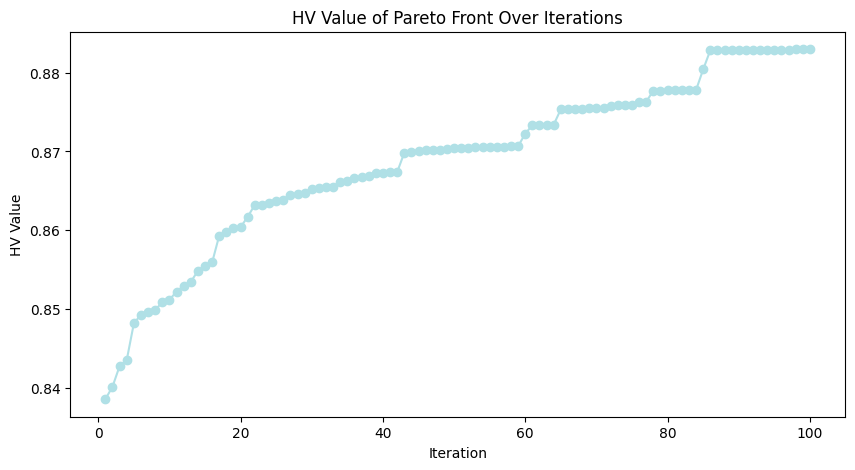

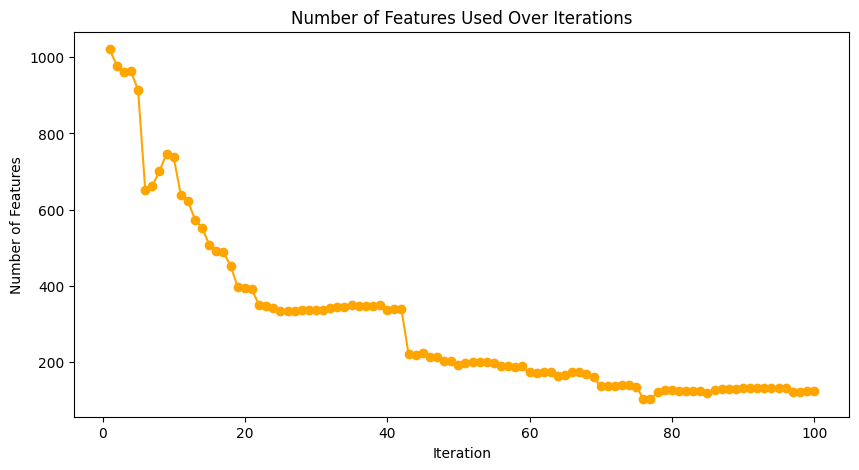

Total population members: 100
Pareto front members: 18


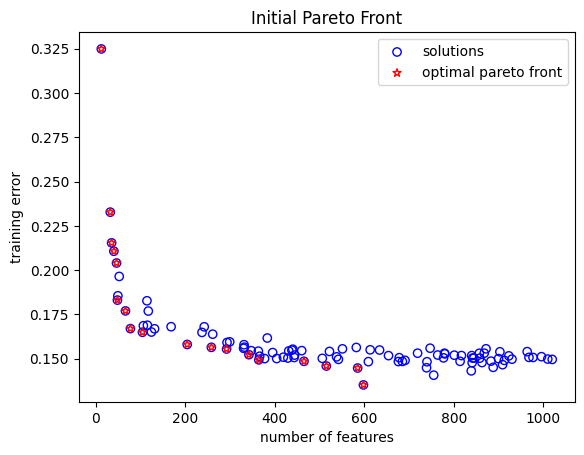

Total population members: 100
Pareto front members: 35


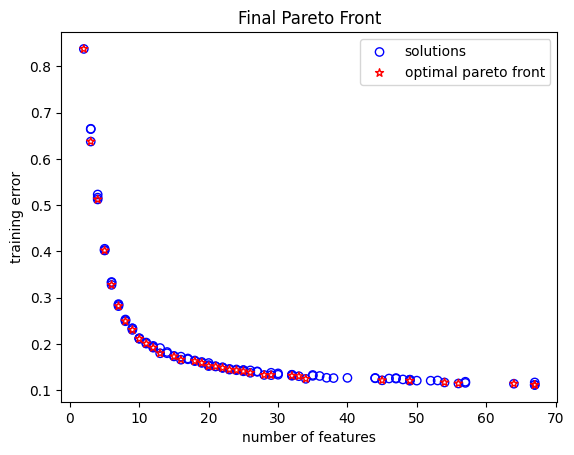

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 5.0
corresponding indices: [584, 788, 895, 955, 981]
classification error on train sets: 0.40209450040148087
classification error on test sets: 0.44685503336075194
solution 1:
number of selected features is: 4.0
corresponding indices: [584, 669, 788, 895]
classification error on train sets: 0.5123903035172155
classification error on test sets: 0.4862852625617834
solution 2:
number of selected features is: 3.0
corresponding indices: [788, 895, 981]
classification error on train sets: 0.6375509473557717
classification error on test sets: 0.5875767250335702
solution 3:
number of selected features is: 2.0
corresponding indices: [788, 895]
classification error on train sets: 0.8377901805774508
classification error on test sets: 0.8263579642779263
solution 4:
number of selected features is: 24.0
corresponding indices: [580, 584, 649, 652, 660, 669, 703, 708, 737, 766, 

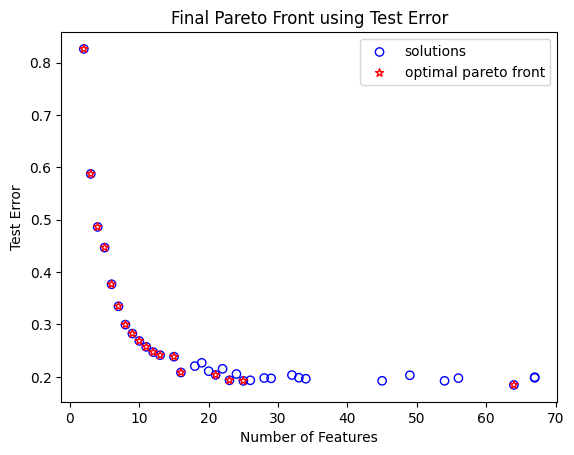

Final PF Results:  {0: {'num_selected_features': 5.0, 'selected_feature_indices': [584, 788, 895, 955, 981], 'train_error': 0.40209450040148087, 'test_error': 0.44685503336075194}, 1: {'num_selected_features': 4.0, 'selected_feature_indices': [584, 669, 788, 895], 'train_error': 0.5123903035172155, 'test_error': 0.4862852625617834}, 2: {'num_selected_features': 3.0, 'selected_feature_indices': [788, 895, 981], 'train_error': 0.6375509473557717, 'test_error': 0.5875767250335702}, 3: {'num_selected_features': 2.0, 'selected_feature_indices': [788, 895], 'train_error': 0.8377901805774508, 'test_error': 0.8263579642779263}, 4: {'num_selected_features': 24.0, 'selected_feature_indices': [580, 584, 649, 652, 660, 669, 703, 708, 737, 766, 778, 788, 793, 819, 862, 889, 895, 908, 951, 955, 980, 1005, 1016, 1017], 'train_error': 0.14323893124170517, 'test_error': 0.2053007383116534}, 5: {'num_selected_features': 8.0, 'selected_feature_indices': [584, 669, 788, 845, 877, 895, 972, 981], 'train_er

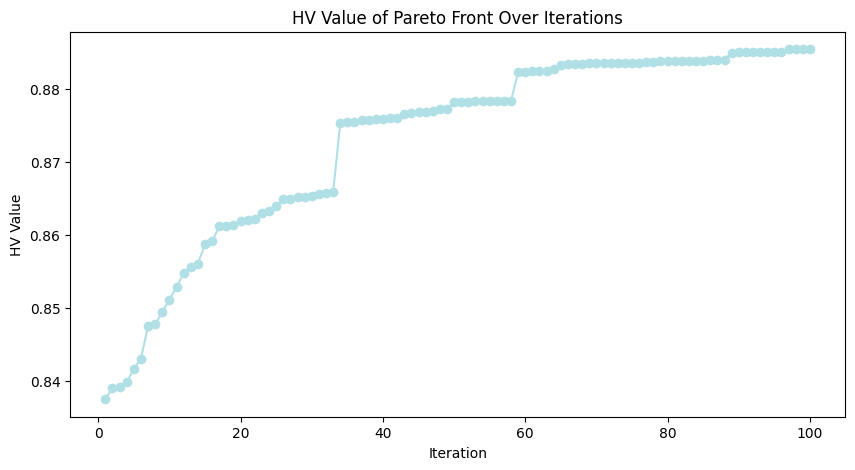

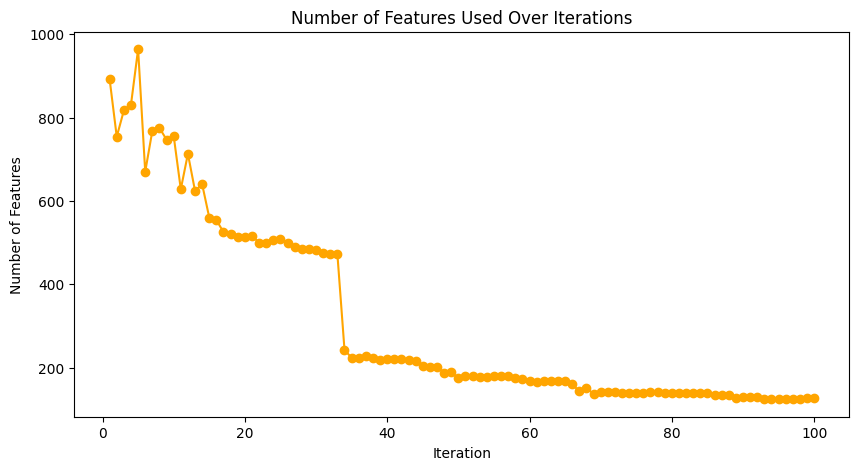

Total population members: 100
Pareto front members: 10


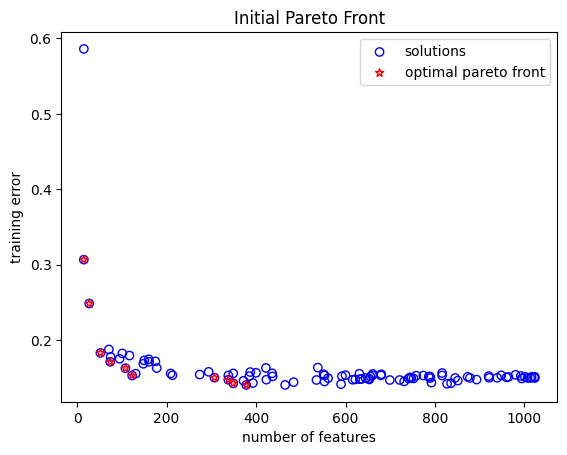

Total population members: 100
Pareto front members: 40


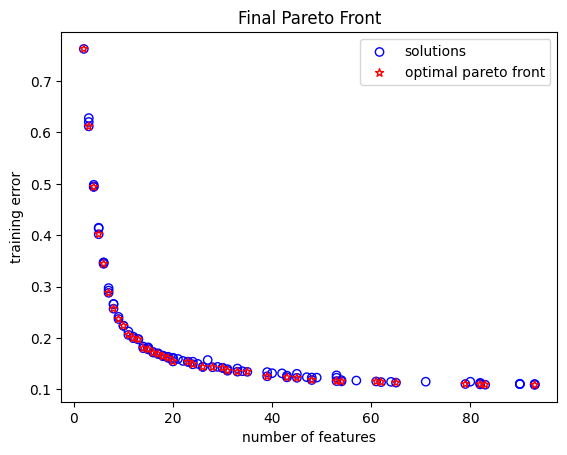

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 17.0
corresponding indices: [630, 698, 716, 735, 756, 766, 789, 794, 832, 835, 843, 881, 885, 914, 934, 950, 978]
classification error on train sets: 0.16870183154618767
classification error on test sets: 0.22117131472898155
solution 1:
number of selected features is: 14.0
corresponding indices: [630, 698, 716, 728, 784, 794, 843, 881, 885, 905, 914, 941, 950, 978]
classification error on train sets: 0.1800802027274392
classification error on test sets: 0.2159392021683122
solution 2:
number of selected features is: 4.0
corresponding indices: [784, 843, 914, 950]
classification error on train sets: 0.4940049746179953
classification error on test sets: 0.5373984635008606
solution 3:
number of selected features is: 8.0
corresponding indices: [630, 698, 728, 784, 843, 914, 922, 950]
classification error on train sets: 0.25704437487878895
classification error on test 

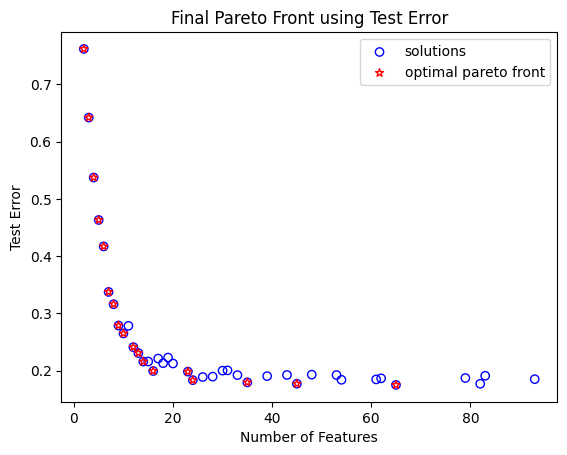

Final PF Results:  {0: {'num_selected_features': 17.0, 'selected_feature_indices': [630, 698, 716, 735, 756, 766, 789, 794, 832, 835, 843, 881, 885, 914, 934, 950, 978], 'train_error': 0.16870183154618767, 'test_error': 0.22117131472898155}, 1: {'num_selected_features': 14.0, 'selected_feature_indices': [630, 698, 716, 728, 784, 794, 843, 881, 885, 905, 914, 941, 950, 978], 'train_error': 0.1800802027274392, 'test_error': 0.2159392021683122}, 2: {'num_selected_features': 4.0, 'selected_feature_indices': [784, 843, 914, 950], 'train_error': 0.4940049746179953, 'test_error': 0.5373984635008606}, 3: {'num_selected_features': 8.0, 'selected_feature_indices': [630, 698, 728, 784, 843, 914, 922, 950], 'train_error': 0.25704437487878895, 'test_error': 0.3161318694443932}, 4: {'num_selected_features': 6.0, 'selected_feature_indices': [630, 784, 794, 843, 914, 950], 'train_error': 0.3443898131792399, 'test_error': 0.41710894415066957}, 5: {'num_selected_features': 20.0, 'selected_feature_indice

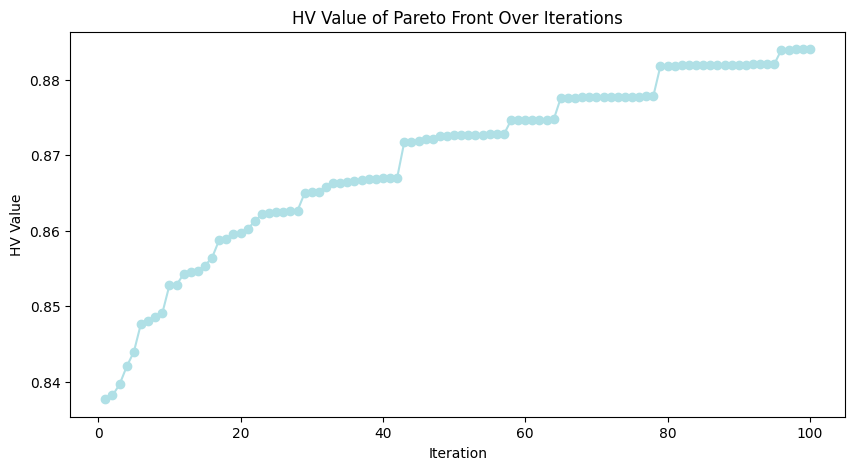

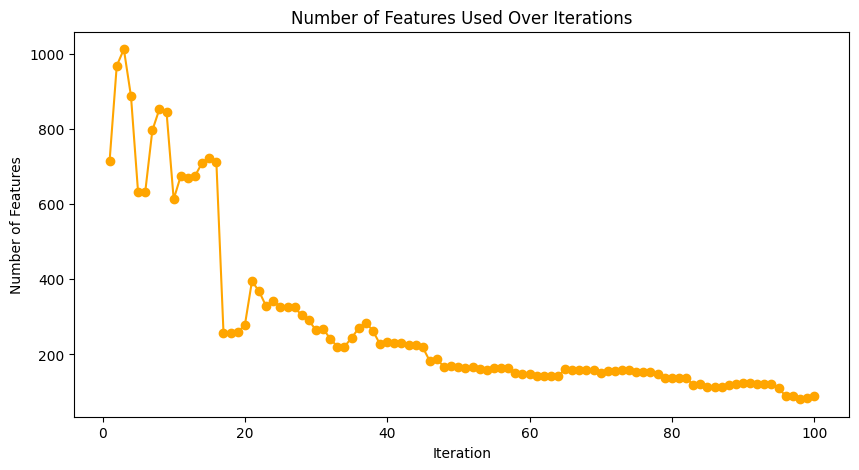

Total population members: 100
Pareto front members: 12


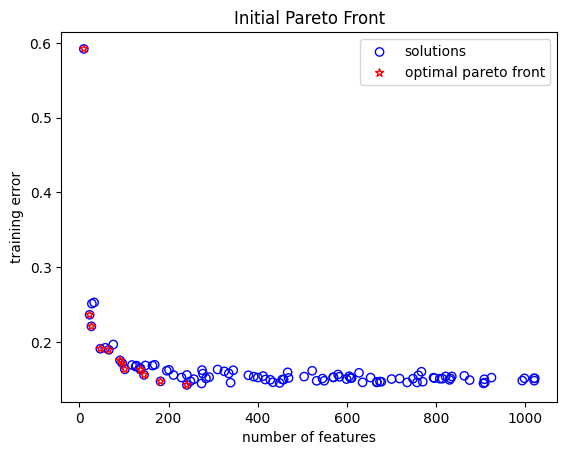

Total population members: 100
Pareto front members: 27


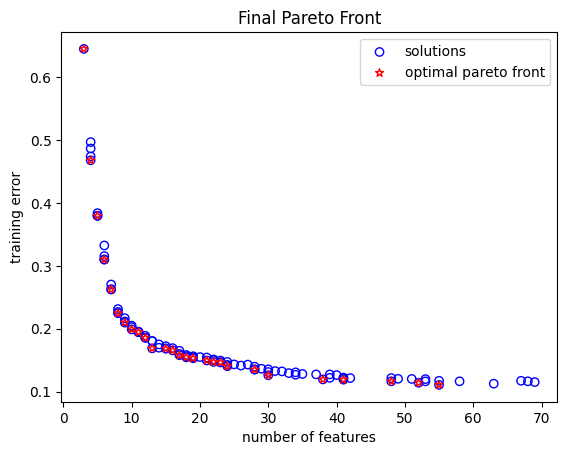

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding indices: [852, 875, 976, 1004]
classification error on train sets: 0.4682170056450483
classification error on test sets: 0.5223020530820134
solution 1:
number of selected features is: 3.0
corresponding indices: [852, 976, 1004]
classification error on train sets: 0.6454929670814551
classification error on test sets: 0.613167345706133
solution 2:
number of selected features is: 6.0
corresponding indices: [781, 827, 852, 867, 976, 1004]
classification error on train sets: 0.31001988190676977
classification error on test sets: 0.3616816823420107
solution 3:
number of selected features is: 12.0
corresponding indices: [579, 584, 618, 630, 771, 781, 827, 852, 855, 976, 1004, 1022]
classification error on train sets: 0.18554604693438193
classification error on test sets: 0.2487097795930009
solution 4:
number of selected features is: 7.0
corresponding i

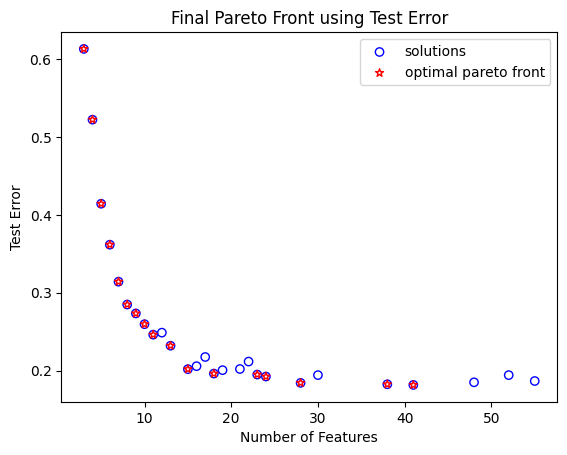

Final PF Results:  {0: {'num_selected_features': 4.0, 'selected_feature_indices': [852, 875, 976, 1004], 'train_error': 0.4682170056450483, 'test_error': 0.5223020530820134}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [852, 976, 1004], 'train_error': 0.6454929670814551, 'test_error': 0.613167345706133}, 2: {'num_selected_features': 6.0, 'selected_feature_indices': [781, 827, 852, 867, 976, 1004], 'train_error': 0.31001988190676977, 'test_error': 0.3616816823420107}, 3: {'num_selected_features': 12.0, 'selected_feature_indices': [579, 584, 618, 630, 771, 781, 827, 852, 855, 976, 1004, 1022], 'train_error': 0.18554604693438193, 'test_error': 0.2487097795930009}, 4: {'num_selected_features': 7.0, 'selected_feature_indices': [771, 781, 827, 852, 867, 976, 1004], 'train_error': 0.26257662268667004, 'test_error': 0.31419295602335096}, 5: {'num_selected_features': 10.0, 'selected_feature_indices': [579, 618, 630, 771, 781, 827, 852, 855, 976, 1004], 'train_error': 0.1989484

In [6]:
# USING SEPARATE TEST DATA, Run NSGA2 5 times to select features from kimianet valiation data w/ averaged features

# Read the dataset from the tab-separated file without headers
validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
validation = pd.read_csv(validation_path)

# Assume that the first column contains the class labels
dclass = validation.columns[0]

# Separate features (X) and target (y)
xtrain = validation.drop(columns=[dclass])
ytrain = validation[dclass]

# Do the same for test data
test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
test = pd.read_csv(test_path)
dclass = test.columns[0]
xtest = test.drop(columns=[dclass])
ytest = test[dclass]

for run in range(5):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: kimianet_data_averaged_feature_vectors.csv"
    # Split the data into 70/30 train/test, ensuring proportional class distributions (using stratify)
    #xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42+run)

    # Generate initial population members
    total_features = xtrain.shape[1] 
    print("TOTAL NUMBER OF FEATURES: ", total_features)
    custom_population = generate_individuals(total_features)
    population = Population.new("X", custom_population)

    # Set up NSGA2 algorithm
    problem = MyProblem(xtrain, ytrain)
    algorithm = NSGA2(pop_size=100,
                    sampling=population,
                    crossover=UniformCrossover(prob=0.9),
                    mutation=BitflipMutation(prob=0.01),
                    eliminate_duplicates=True)
    res = minimize(problem,
                algorithm,
                ("n_gen", 100),
                verbose=False,
                save_history=True)

    # Get data from NSGA2 algorithm
    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = nsga2_results(res, xtrain, ytrain, xtest, ytest)

    # Store NSGA2 results
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training)

    # took 685 min to run

************************************************** RUN 1 **************************************************
TOTAL NUMBER OF FEATURES:  1024
INDIVIDUAL 1, 485 features: [False  True  True ... False False  True]
INDIVIDUAL 2, 477 features: [False  True  True ... False False False]
INDIVIDUAL 3, 368 features: [False False  True ... False False False]
INDIVIDUAL 4, 225 features: [False False  True ... False False False]
INDIVIDUAL 5, 925 features: [False  True  True ...  True  True  True]
INDIVIDUAL 6, 704 features: [False  True  True ...  True False False]
INDIVIDUAL 7, 680 features: [ True  True  True ... False  True False]
INDIVIDUAL 8, 426 features: [False False  True ... False  True  True]
INDIVIDUAL 9, 717 features: [ True  True  True ... False  True  True]
INDIVIDUAL 10, 308 features: [False False False ...  True False  True]
INDIVIDUAL 11, 754 features: [ True  True  True ...  True  True  True]
INDIVIDUAL 12, 12 features: [False False False ... False False False]
INDIVIDUAL 13, 395

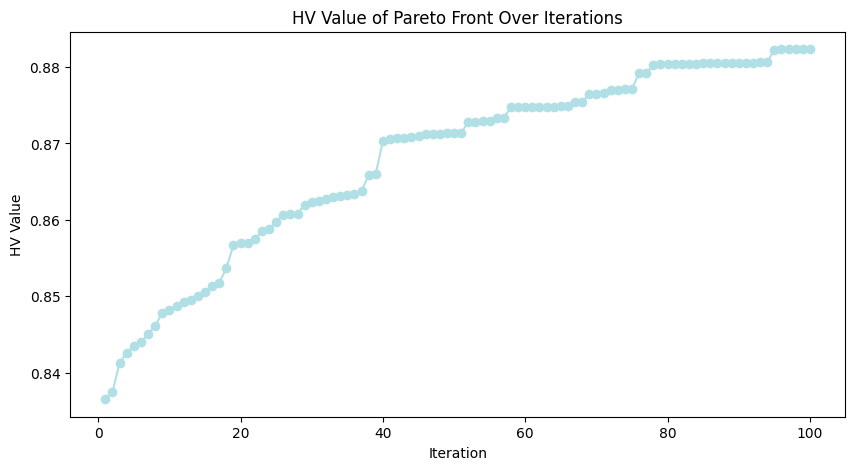

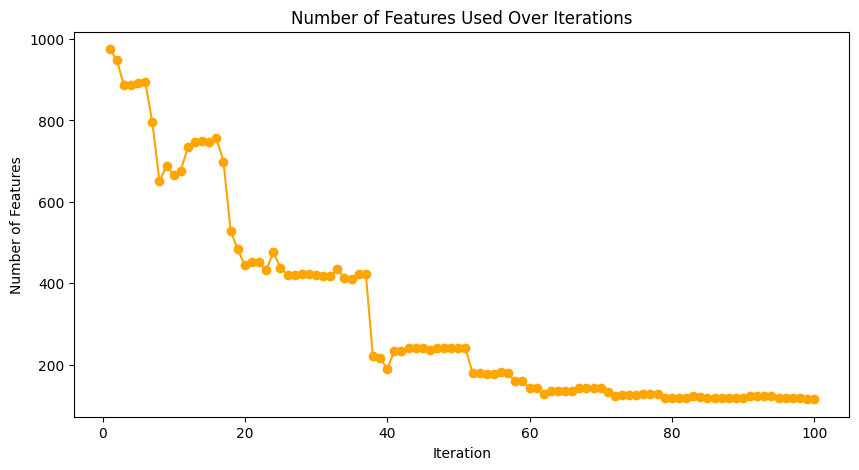

Total population members: 100
Pareto front members: 12


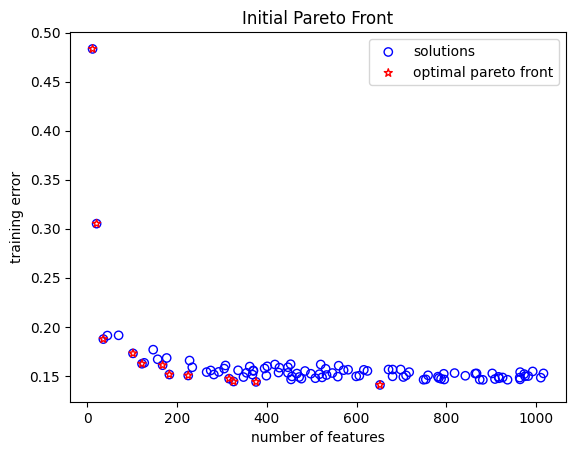

Total population members: 100
Pareto front members: 34


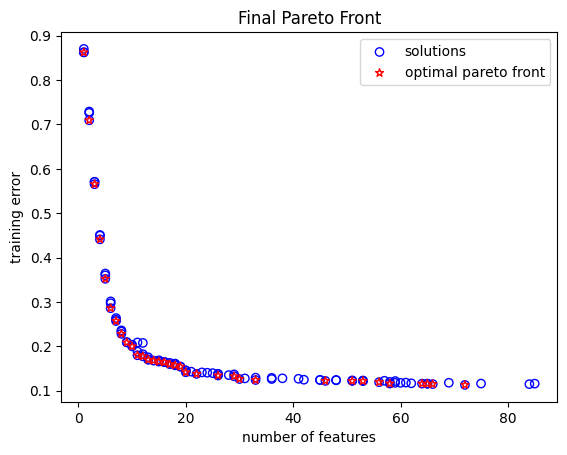

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding indices: [898, 949]
classification error on train sets: 0.7093277910513514
classification error on test sets: 0.7435273049146895
solution 1:
number of selected features is: 4.0
corresponding indices: [541, 793, 898, 976]
classification error on train sets: 0.44103679168500387
classification error on test sets: 0.5025514544736724
solution 2:
number of selected features is: 3.0
corresponding indices: [541, 898, 976]
classification error on train sets: 0.5652575312389836
classification error on test sets: 0.5941496329563742
solution 3:
number of selected features is: 5.0
corresponding indices: [541, 545, 898, 969, 976]
classification error on train sets: 0.3520674363182068
classification error on test sets: 0.4004193591639962
solution 4:
number of selected features is: 1.0
corresponding indices: [541]
classification error on train sets: 0.862312519

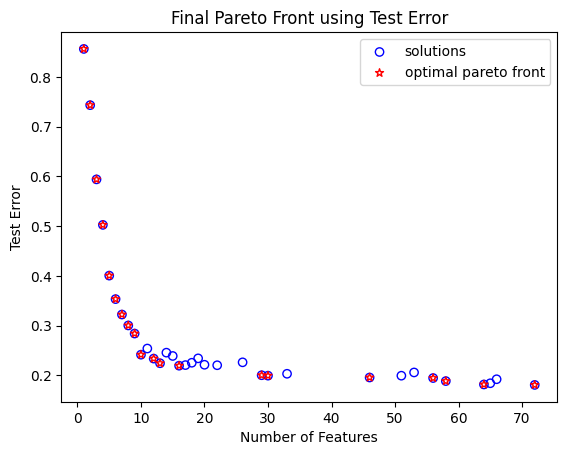

Final PF Results:  {0: {'num_selected_features': 2.0, 'selected_feature_indices': [898, 949], 'train_error': 0.7093277910513514, 'test_error': 0.7435273049146895}, 1: {'num_selected_features': 4.0, 'selected_feature_indices': [541, 793, 898, 976], 'train_error': 0.44103679168500387, 'test_error': 0.5025514544736724}, 2: {'num_selected_features': 3.0, 'selected_feature_indices': [541, 898, 976], 'train_error': 0.5652575312389836, 'test_error': 0.5941496329563742}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [541, 545, 898, 969, 976], 'train_error': 0.3520674363182068, 'test_error': 0.4004193591639962}, 4: {'num_selected_features': 1.0, 'selected_feature_indices': [541], 'train_error': 0.862312519730842, 'test_error': 0.8567138875522351}, 5: {'num_selected_features': 15.0, 'selected_feature_indices': [541, 545, 683, 693, 781, 845, 850, 889, 898, 907, 920, 949, 955, 969, 976], 'train_error': 0.16547132601354486, 'test_error': 0.2386897971208518}, 6: {'num_selected_featur

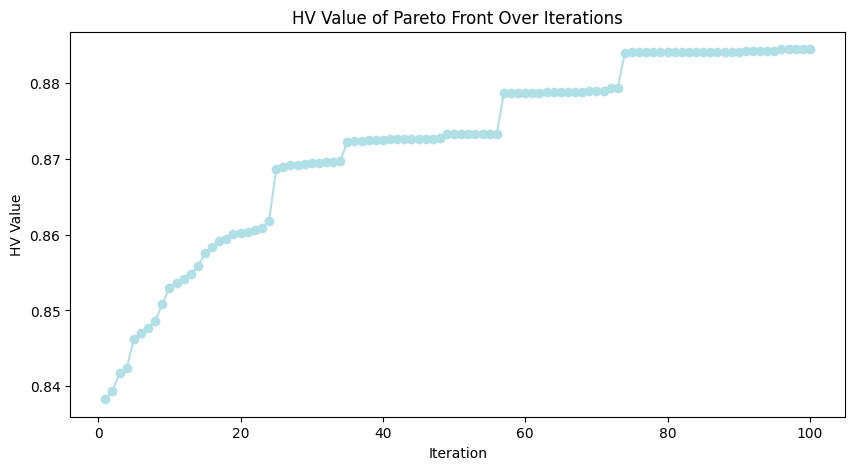

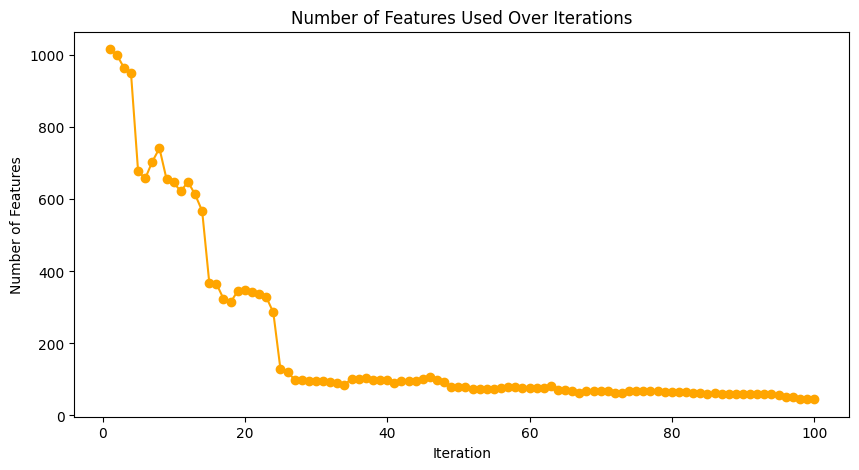

Total population members: 100
Pareto front members: 13


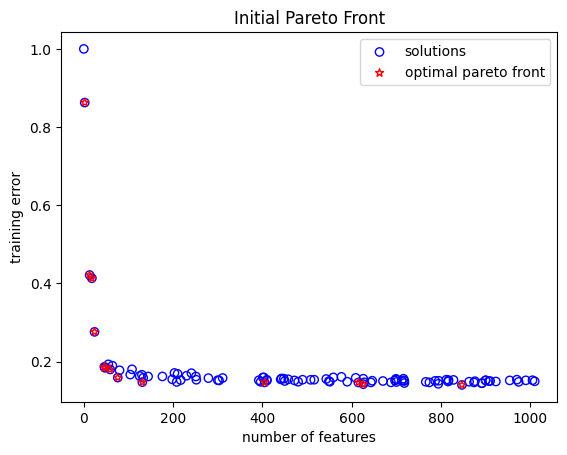

Total population members: 100
Pareto front members: 25


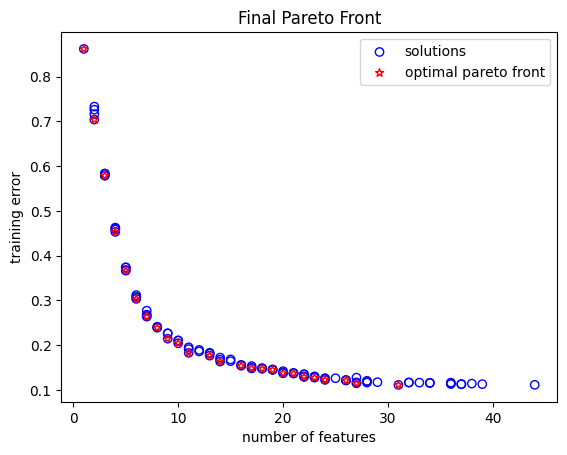

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [798]
classification error on train sets: 0.8616686281013244
classification error on test sets: 0.8649504646868444
solution 1:
number of selected features is: 3.0
corresponding indices: [798, 813, 1024]
classification error on train sets: 0.5787496969241972
classification error on test sets: 0.6032240376107181
solution 2:
number of selected features is: 2.0
corresponding indices: [708, 798]
classification error on train sets: 0.7038088483676579
classification error on test sets: 0.7112571197108997
solution 3:
number of selected features is: 5.0
corresponding indices: [708, 767, 798, 875, 911]
classification error on train sets: 0.3662397105420868
classification error on test sets: 0.42633241899340957
solution 4:
number of selected features is: 4.0
corresponding indices: [545, 798, 813, 1024]
classification error on train sets: 0.4529347

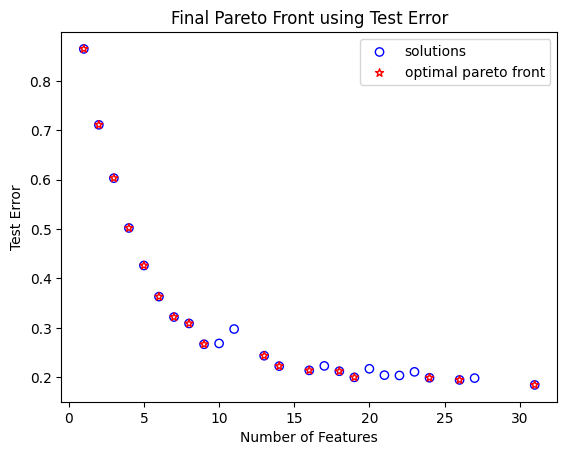

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [798], 'train_error': 0.8616686281013244, 'test_error': 0.8649504646868444}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [798, 813, 1024], 'train_error': 0.5787496969241972, 'test_error': 0.6032240376107181}, 2: {'num_selected_features': 2.0, 'selected_feature_indices': [708, 798], 'train_error': 0.7038088483676579, 'test_error': 0.7112571197108997}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [708, 767, 798, 875, 911], 'train_error': 0.3662397105420868, 'test_error': 0.42633241899340957}, 4: {'num_selected_features': 4.0, 'selected_feature_indices': [545, 798, 813, 1024], 'train_error': 0.45293477004336813, 'test_error': 0.5023446692236082}, 5: {'num_selected_features': 6.0, 'selected_feature_indices': [708, 767, 798, 875, 911, 1024], 'train_error': 0.30325741645696835, 'test_error': 0.3632633593454905}, 6: {'num_selected_features': 19.0, 'selected_feature_indices': [1

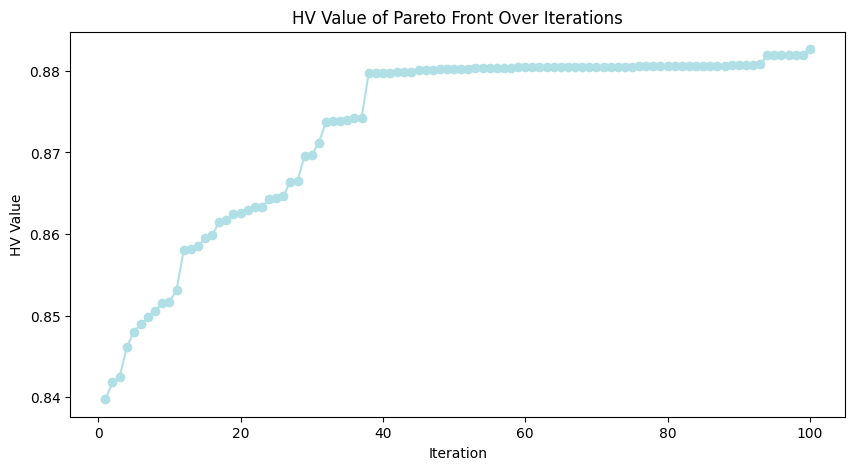

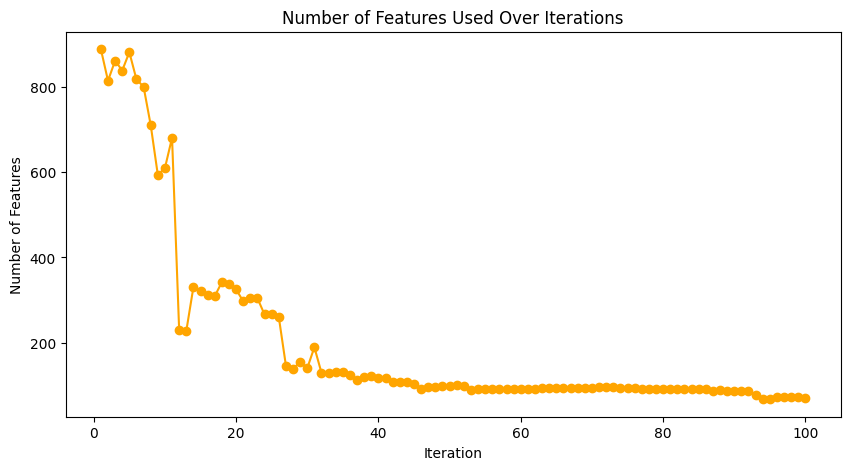

Total population members: 100
Pareto front members: 12


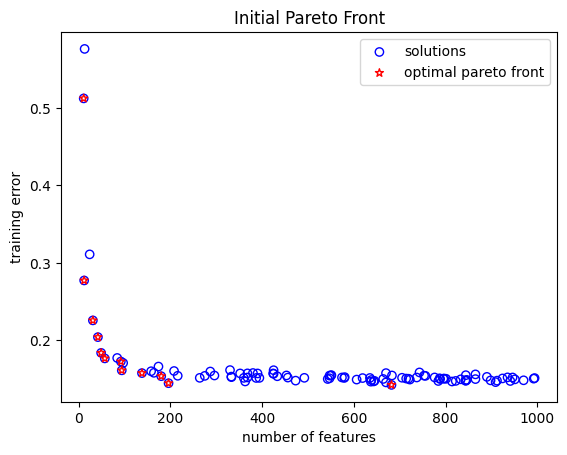

Total population members: 100
Pareto front members: 23


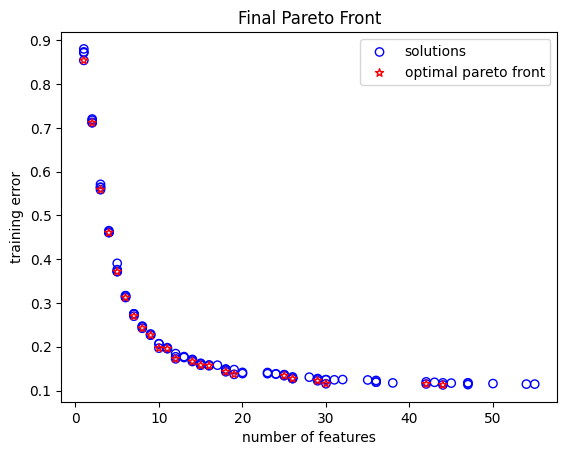

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [894]
classification error on train sets: 0.8544630995175586
classification error on test sets: 0.8689538763233218
solution 1:
number of selected features is: 2.0
corresponding indices: [770, 894]
classification error on train sets: 0.7117479988738803
classification error on test sets: 0.754855030645201
solution 2:
number of selected features is: 5.0
corresponding indices: [642, 759, 870, 935, 970]
classification error on train sets: 0.3716791124664196
classification error on test sets: 0.3915549111760258
solution 3:
number of selected features is: 3.0
corresponding indices: [759, 870, 935]
classification error on train sets: 0.5589247522282206
classification error on test sets: 0.6234417575287388
solution 4:
number of selected features is: 4.0
corresponding indices: [770, 790, 855, 1017]
classification error on train sets: 0.4606635623

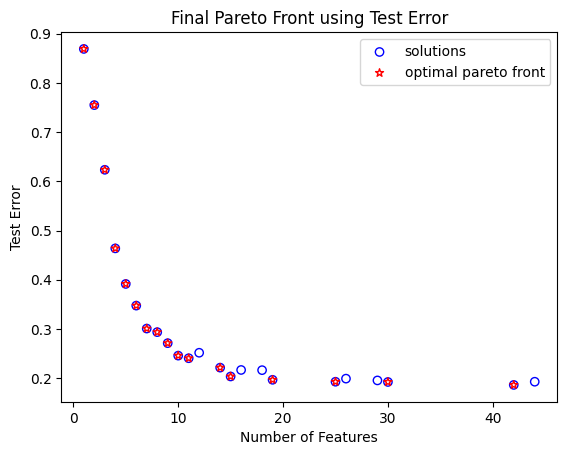

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [894], 'train_error': 0.8544630995175586, 'test_error': 0.8689538763233218}, 1: {'num_selected_features': 2.0, 'selected_feature_indices': [770, 894], 'train_error': 0.7117479988738803, 'test_error': 0.754855030645201}, 2: {'num_selected_features': 5.0, 'selected_feature_indices': [642, 759, 870, 935, 970], 'train_error': 0.3716791124664196, 'test_error': 0.3915549111760258}, 3: {'num_selected_features': 3.0, 'selected_feature_indices': [759, 870, 935], 'train_error': 0.5589247522282206, 'test_error': 0.6234417575287388}, 4: {'num_selected_features': 4.0, 'selected_feature_indices': [770, 790, 855, 1017], 'train_error': 0.4606635623237797, 'test_error': 0.4638004196760309}, 5: {'num_selected_features': 25.0, 'selected_feature_indices': [17, 353, 382, 630, 703, 757, 758, 759, 767, 770, 773, 790, 819, 836, 855, 881, 897, 908, 911, 926, 935, 970, 978, 980, 1016], 'train_error': 0.1337540325440839, 'test_erro

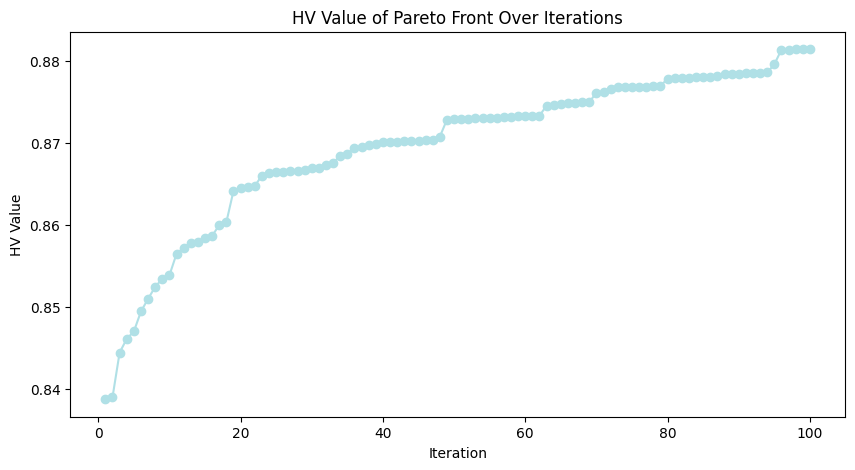

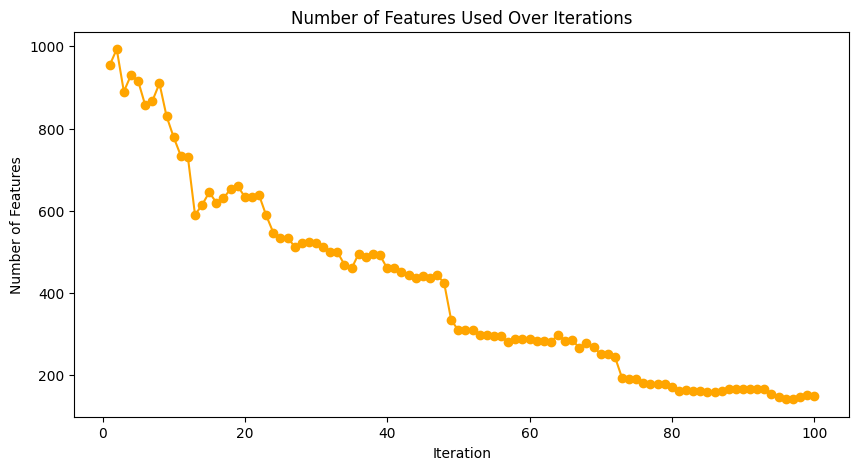

Total population members: 100
Pareto front members: 13


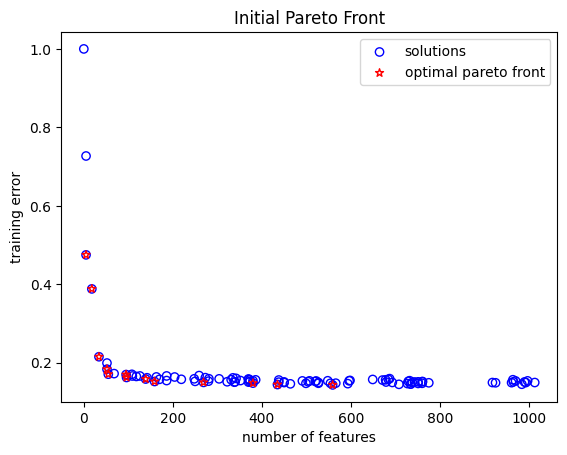

Total population members: 100
Pareto front members: 35


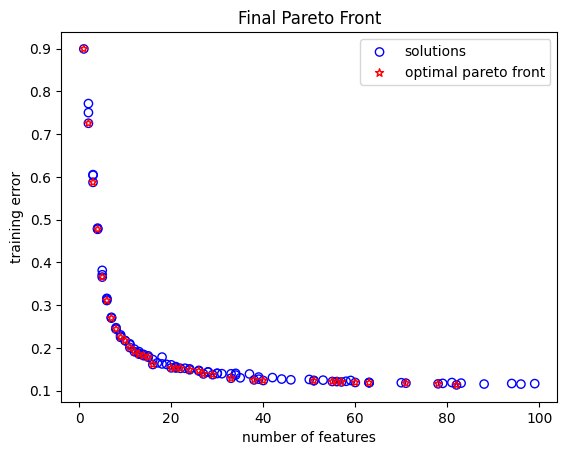

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding indices: [629, 630, 637, 708]
classification error on train sets: 0.4772955091787249
classification error on test sets: 0.5066490646471871
solution 1:
number of selected features is: 1.0
corresponding indices: [637]
classification error on train sets: 0.899158252926704
classification error on test sets: 0.879927621578461
solution 2:
number of selected features is: 2.0
corresponding indices: [637, 708]
classification error on train sets: 0.725267881853241
classification error on test sets: 0.7386774298215468
solution 3:
number of selected features is: 7.0
corresponding indices: [629, 630, 637, 708, 839, 959, 976]
classification error on train sets: 0.2695764689121012
classification error on test sets: 0.33043352576699647
solution 4:
number of selected features is: 12.0
corresponding indices: [533, 556, 629, 630, 637, 708, 858, 874, 881, 890, 947,

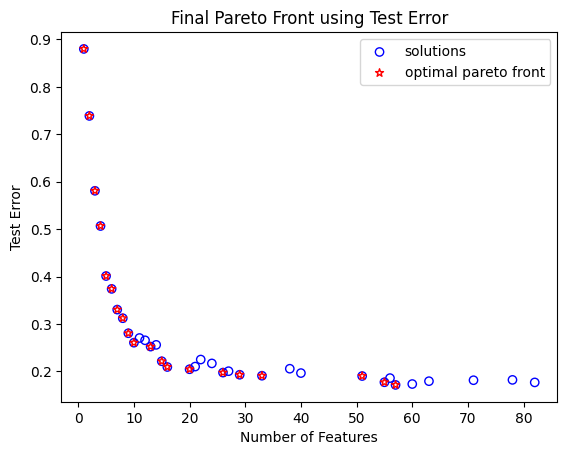

Final PF Results:  {0: {'num_selected_features': 4.0, 'selected_feature_indices': [629, 630, 637, 708], 'train_error': 0.4772955091787249, 'test_error': 0.5066490646471871}, 1: {'num_selected_features': 1.0, 'selected_feature_indices': [637], 'train_error': 0.899158252926704, 'test_error': 0.879927621578461}, 2: {'num_selected_features': 2.0, 'selected_feature_indices': [637, 708], 'train_error': 0.725267881853241, 'test_error': 0.7386774298215468}, 3: {'num_selected_features': 7.0, 'selected_feature_indices': [629, 630, 637, 708, 839, 959, 976], 'train_error': 0.2695764689121012, 'test_error': 0.33043352576699647}, 4: {'num_selected_features': 12.0, 'selected_feature_indices': [533, 556, 629, 630, 637, 708, 858, 874, 881, 890, 947, 976], 'train_error': 0.19089475895624997, 'test_error': 0.2657663158410064}, 5: {'num_selected_features': 3.0, 'selected_feature_indices': [637, 708, 976], 'train_error': 0.5871476755983586, 'test_error': 0.5808739254200985}, 6: {'num_selected_features': 8.

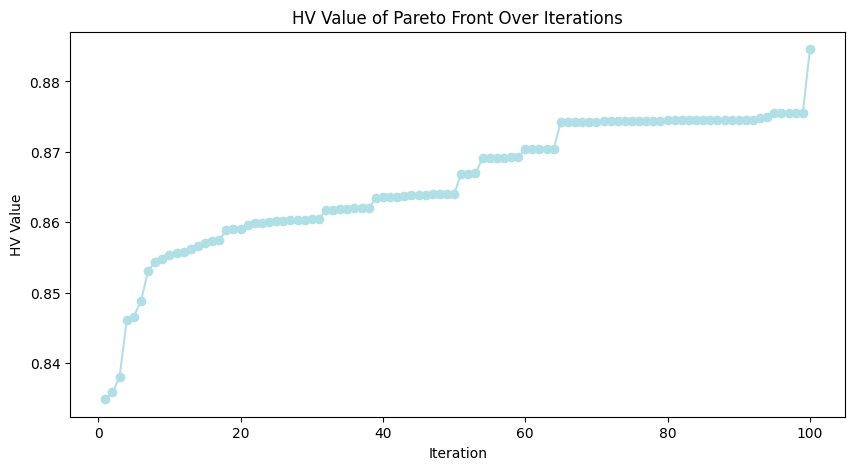

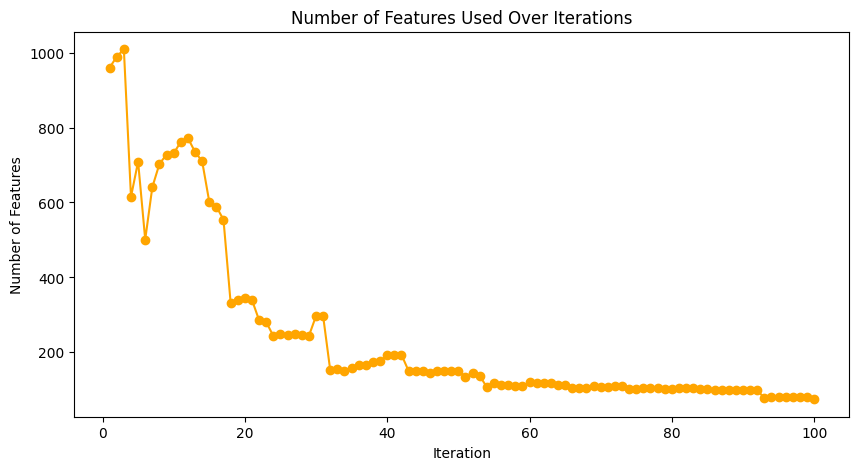

Total population members: 100
Pareto front members: 14


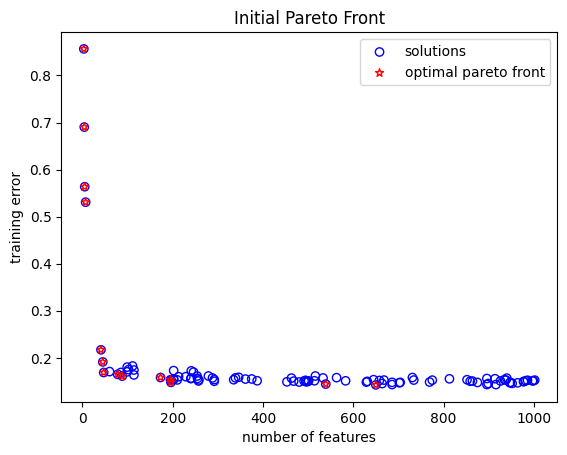

Total population members: 100
Pareto front members: 31


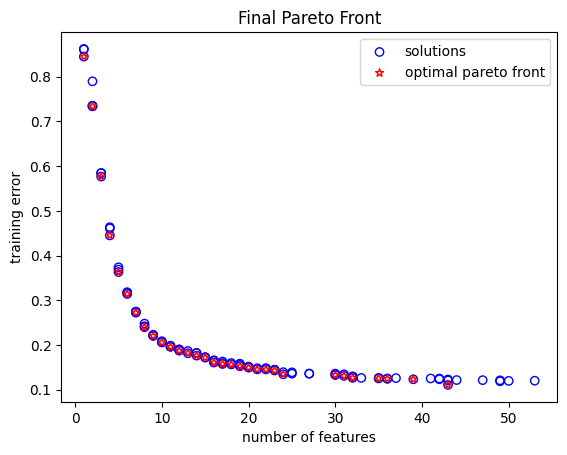

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding indices: [796, 834, 987, 1016]
classification error on train sets: 0.44493342532230695
classification error on test sets: 0.4703383281229041
solution 1:
number of selected features is: 2.0
corresponding indices: [676, 1024]
classification error on train sets: 0.7336643497641224
classification error on test sets: 0.7823880138282916
solution 2:
number of selected features is: 9.0
corresponding indices: [586, 735, 763, 769, 834, 986, 987, 1016, 1024]
classification error on train sets: 0.22024084665232968
classification error on test sets: 0.29541548539268225
solution 3:
number of selected features is: 3.0
corresponding indices: [850, 998, 1016]
classification error on train sets: 0.5765815727910941
classification error on test sets: 0.5973733958123248
solution 4:
number of selected features is: 16.0
corresponding indices: [570, 676, 735, 756, 763,

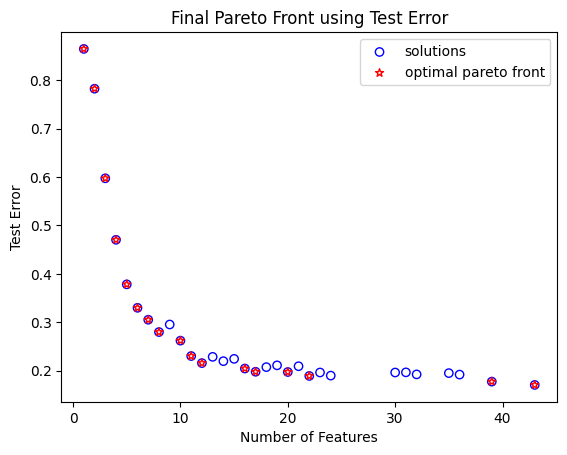

Final PF Results:  {0: {'num_selected_features': 4.0, 'selected_feature_indices': [796, 834, 987, 1016], 'train_error': 0.44493342532230695, 'test_error': 0.4703383281229041}, 1: {'num_selected_features': 2.0, 'selected_feature_indices': [676, 1024], 'train_error': 0.7336643497641224, 'test_error': 0.7823880138282916}, 2: {'num_selected_features': 9.0, 'selected_feature_indices': [586, 735, 763, 769, 834, 986, 987, 1016, 1024], 'train_error': 0.22024084665232968, 'test_error': 0.29541548539268225}, 3: {'num_selected_features': 3.0, 'selected_feature_indices': [850, 998, 1016], 'train_error': 0.5765815727910941, 'test_error': 0.5973733958123248}, 4: {'num_selected_features': 16.0, 'selected_feature_indices': [570, 676, 735, 756, 763, 769, 782, 834, 869, 945, 967, 982, 987, 996, 1016, 1024], 'train_error': 0.16056380406858872, 'test_error': 0.20446516464820985}, 5: {'num_selected_features': 10.0, 'selected_feature_indices': [568, 735, 763, 782, 796, 834, 986, 998, 1016, 1024], 'train_err

In [8]:
# USING SEPARATE TEST DATA, Run NSGA2 5 times AGAIN to select features from kimianet valiation data w/ averaged features

# Read the dataset from the tab-separated file without headers
validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
validation = pd.read_csv(validation_path)

# Assume that the first column contains the class labels
dclass = validation.columns[0]

# Separate features (X) and target (y)
xtrain = validation.drop(columns=[dclass])
ytrain = validation[dclass]

# Do the same for test data
test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
test = pd.read_csv(test_path)
dclass = test.columns[0]
xtest = test.drop(columns=[dclass])
ytest = test[dclass]

for run in range(5):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: kimianet_data_averaged_feature_vectors.csv"
    # Split the data into 70/30 train/test, ensuring proportional class distributions (using stratify)
    #xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42+run)

    # Generate initial population members
    total_features = xtrain.shape[1] 
    print("TOTAL NUMBER OF FEATURES: ", total_features)
    custom_population = generate_individuals(total_features)
    population = Population.new("X", custom_population)

    # Set up NSGA2 algorithm
    problem = MyProblem(xtrain, ytrain)
    algorithm = NSGA2(pop_size=100,
                    sampling=population,
                    crossover=UniformCrossover(prob=0.9),
                    mutation=BitflipMutation(prob=0.01),
                    eliminate_duplicates=True)
    res = minimize(problem,
                algorithm,
                ("n_gen", 100),
                verbose=False,
                save_history=True)

    # Get data from NSGA2 algorithm
    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = nsga2_results(res, xtrain, ytrain, xtest, ytest)

    # Store NSGA2 results
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training)

In [55]:
# Fetch results of all 11 new NSGA2 runs
csv_file_path = 'data.csv'  
df = pd.read_csv(csv_file_path)
filtered_df = df.iloc[30:41].reset_index() # rows with new kimianet NSGA runs
print("*"*25, "Runs considered", "*"*25)
print(filtered_df['Dataset'])

# Get average error and number of features from the best solution in each run
print("*"*25, "Average Results Over 11 Runs", "*"*25)
print(f"Final Training PF: average error & number of features for the best solution = {round(filtered_df['Minimum error on training PF'].mean(), 4)}, {int(filtered_df['Number of features for minimum error on training PF'].mean())}")
print(f"Final Test PF: average error & number of features for the best solution = {round(filtered_df['Minimum error on testing PF'].mean(), 4)}, {int(filtered_df['Number of features for minimum error on testing PF'].mean())}")

# Get the two solutions with the lowest training/testing error and the corresponding number of features for both
min_training_error_row = filtered_df.loc[filtered_df['Minimum error on training PF'].idxmin()]
min_test_error_row = filtered_df.loc[filtered_df['Minimum error on testing PF'].idxmin()]
print("*"*25, "Lowest Error Results", "*"*25)
print(f"Lowest training error: {round(min_training_error_row['Minimum error on training PF'], 4)}, Number of features: {int(min_training_error_row['Number of features for minimum error on training PF'])}")
print(f"Lowest test error: {round(min_test_error_row['Minimum error on testing PF'],4)}, Number of features: {int(min_test_error_row['Number of features for minimum error on testing PF'])}")

# Get total number of solutions across the final training pareto front of all 10 runs
print("*"*25, "Total Number of Solutions in the Final Pareto Front", "*"*25)
total_solutions = 0
for i, pf_dict_str in filtered_df['Training PF'].items():
    pf_dict = eval(pf_dict_str)
    num_solutions = len(pf_dict)
    print(f"Run {i+1}: {num_solutions} solution(s)")
    total_solutions += num_solutions
print(f"Total number of solutions across all runs: {total_solutions}")

# Sort features based on how many solutions they appeared in across the final training pareto front of all 10 runs
# IMPORTANT: the features range from 1-1024, NOT 0-1023 (i.e., they are not indices)
total_feature_freq = Counter()
for feature_freq_str in filtered_df['Feature Frequency']:
    feature_freq_pairs = feature_freq_str.split(', ')
    for pair in feature_freq_pairs:
        feature, freq = pair.split(': ')
        total_feature_freq[int(feature)] += int(freq)
sorted_feature_freq = sorted(total_feature_freq.items(), key=lambda x: x[1], reverse=True)
rank=1
print("*"*25, "Feature Occurrence Ranking", "*"*25)
for feature, freq in sorted_feature_freq:
    print(f"Rank {rank} - Feature {feature}: {freq} occurrence(s) ({round((freq/total_solutions) * 100, 4)}% of solutions)")
    rank+=1
pd.DataFrame(sorted_feature_freq, columns=['Feature', 'Occurrences']).to_csv("Top_NSGA2_Features.csv", index=False)

# Testing & validation set error using all features
print("*"*25, "Error Using All (1024) Features", "*"*25)
validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
validation = pd.read_csv(validation_path)
dclass = validation.columns[0]
xval = validation.drop(columns=[dclass])
yval = validation[dclass]
test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
test = pd.read_csv(test_path)
dclass = test.columns[0]
xtest = test.drop(columns=[dclass])
ytest = test[dclass]
def knn(x, y):
    dist_matrix = distance_matrix(x, x) 
    predy = [] 
    for i in range(len(x)):
        distances = dist_matrix[i]
        distances[i] = np.inf
        nearest_neighbors = np.argsort(distances)[:5]
        neighbor_labels = y[nearest_neighbors]
        most_common_label = Counter(neighbor_labels).most_common(1)[0][0]
        predy.append(most_common_label)
    f1 = f1_score(y, predy, average='weighted')
    return 1 - f1
print(f"F1 Score Error using only validation data: {round(knn(xval, yval),4)}")
print(f"F1 Score Error using only test data: {round(knn(xtest, ytest),4)}")


************************* Runs considered *************************
0     RUN 1: kimianet_validation_data_averaged_featu...
1     RUN 2: kimianet_validation_data_averaged_featu...
2     RUN 3: kimianet_validation_data_averaged_featu...
3     RUN 4: kimianet_validation_data_averaged_featu...
4     RUN 5: kimianet_validation_data_averaged_featu...
5     RUN 1: kimianet_data_averaged_feature_vectors.csv
6     RUN 1: kimianet_data_averaged_feature_vectors.csv
7     RUN 2: kimianet_data_averaged_feature_vectors.csv
8     RUN 3: kimianet_data_averaged_feature_vectors.csv
9     RUN 4: kimianet_data_averaged_feature_vectors.csv
10    RUN 5: kimianet_data_averaged_feature_vectors.csv
Name: Dataset, dtype: object
************************* Average Results Over 10 Runs *************************
Final Training PF: average error & number of features for the best solution = 0.1124, 59
Final Test PF: average error & number of features for the best solution = 0.1791, 51
************************* Lowest

    Feature  Occurrences
0      1022          114
1       996           99
2       976           99
3       708           89
4       766           86
5       955           85
6       630           82
7       881           79
8       793           78
9       545           77
10      769           75
11      781           74
12      855           73
13      767           72
14      819           69
15      841           65
16      982           65
17      790           62
18      586           61
19      845           59
20      794           59
21      898           59
22      773           56
23      735           53
24      918           52
25      698           50
26     1005           49
27      911           49
28      756           49
29      877           48
30      935           48
31      669           45
32      836           45
33     1017           44
34      625           43
35      763           43
36      888           43
37      978           42
38      737           42


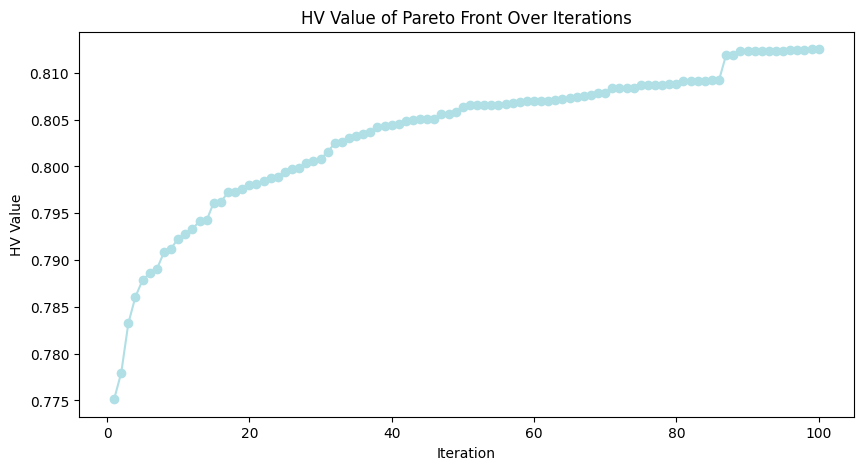

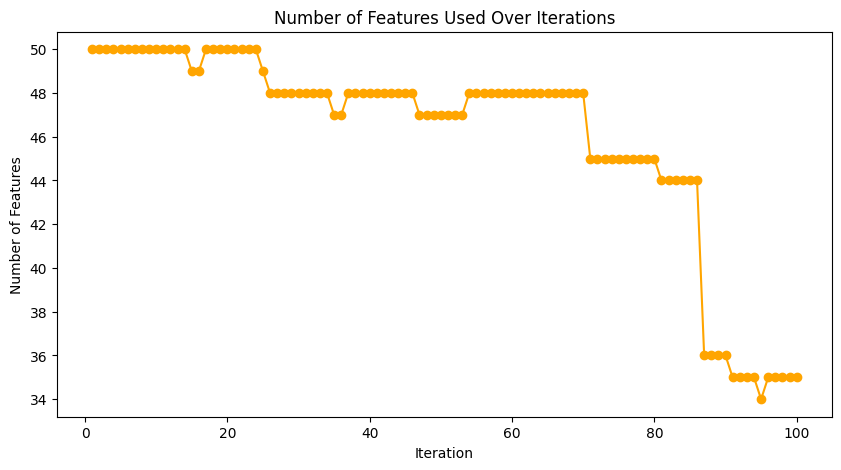

Total population members: 100
Pareto front members: 18


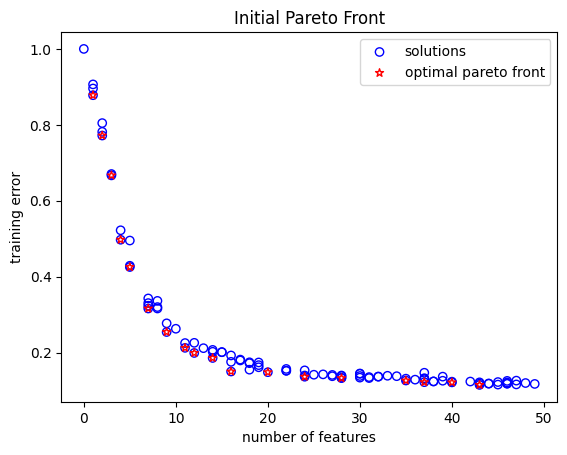

Total population members: 100
Pareto front members: 24


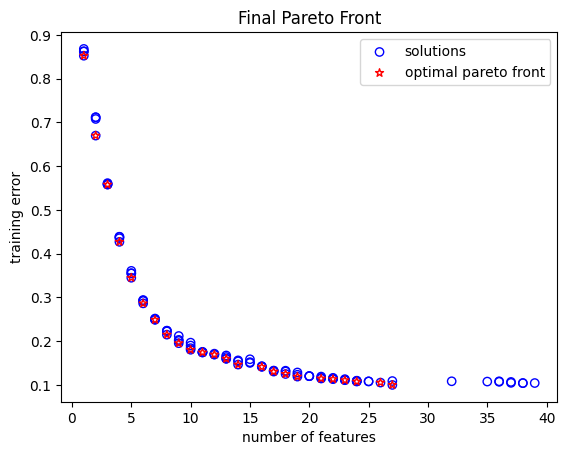

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [4]
classification error on train sets: 0.8525158032376722
classification error on test sets: 0.8494750751709216
solution 1:
number of selected features is: 3.0
corresponding indices: [22, 35, 44]
classification error on train sets: 0.5579345523893415
classification error on test sets: 0.6017531406702478
solution 2:
number of selected features is: 7.0
corresponding indices: [12, 13, 17, 22, 26, 31, 48]
classification error on train sets: 0.2488666981912604
classification error on test sets: 0.3105199752609472
solution 3:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classification error on test sets: 0.7383602898713809
solution 4:
number of selected features is: 8.0
corresponding indices: [2, 10, 12, 13, 17, 26, 31, 48]
classification error on train sets: 0.214

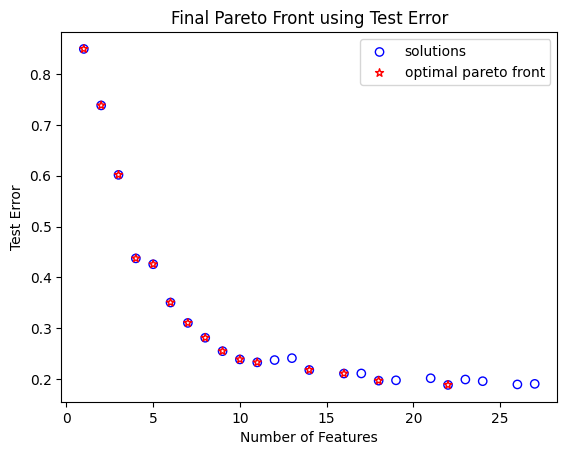

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [4], 'train_error': 0.8525158032376722, 'test_error': 0.8494750751709216}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [22, 35, 44], 'train_error': 0.5579345523893415, 'test_error': 0.6017531406702478}, 2: {'num_selected_features': 7.0, 'selected_feature_indices': [12, 13, 17, 22, 26, 31, 48], 'train_error': 0.2488666981912604, 'test_error': 0.3105199752609472}, 3: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 4: {'num_selected_features': 8.0, 'selected_feature_indices': [2, 10, 12, 13, 17, 26, 31, 48], 'train_error': 0.21499340890319396, 'test_error': 0.28129283863652377}, 5: {'num_selected_features': 6.0, 'selected_feature_indices': [2, 9, 12, 17, 25, 40], 'train_error': 0.28651162417802856, 'test_error': 0.3506200028192681}, 6: {'num_selected_features': 4.0, 'selected_feature_indices': [2, 12,

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 2 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 2 features: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False  True
 False False]
INDIVIDUAL 2, 15 features: [False  True False False False  True False False  True False  True False
 False False False False False False False False False  True  True False
  True False  True  True False False False False False  True False False
 False False False False False False  True False  True  True False  True
 False  True]
INDIVIDUAL 3, 12 features: [False False False False False False False False False  True False False
 False False False False False False  True  True  True False  True Fals

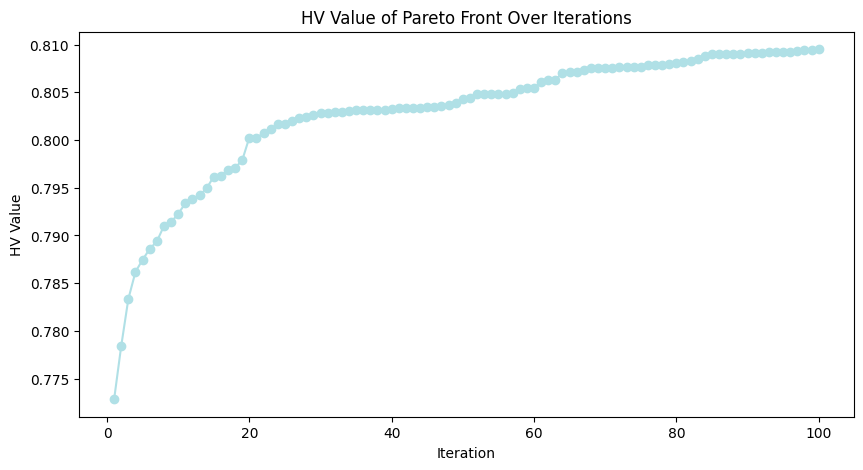

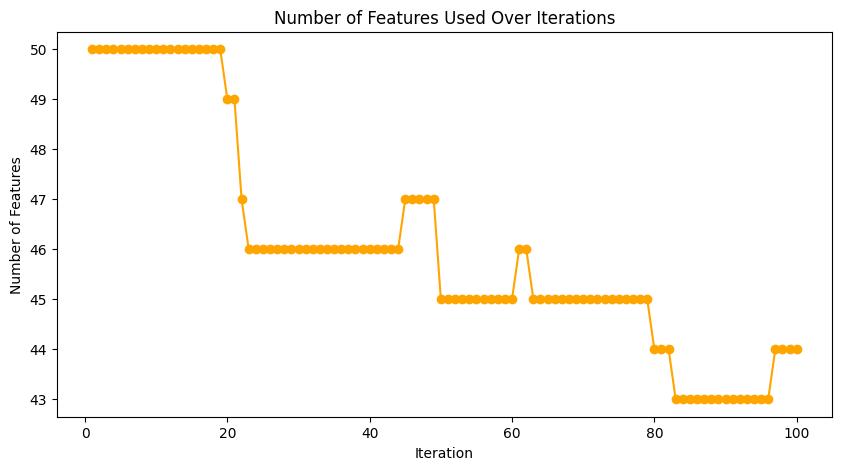

Total population members: 100
Pareto front members: 28


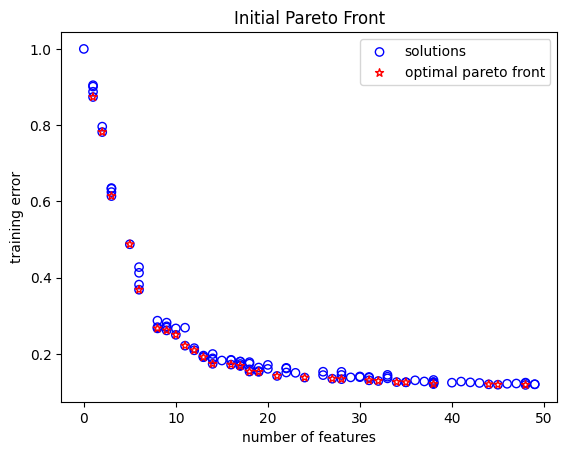

Total population members: 100
Pareto front members: 25


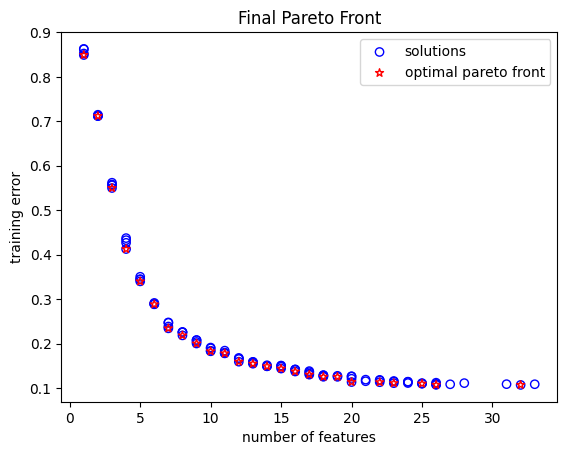

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 3.0
corresponding indices: [1, 12, 31]
classification error on train sets: 0.5498923855205327
classification error on test sets: 0.57390305397878
solution 1:
number of selected features is: 32.0
corresponding indices: [1, 2, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 37, 38, 39, 44, 46, 47, 48, 49]
classification error on train sets: 0.10685999513786026
classification error on test sets: 0.19053178697234974
solution 2:
number of selected features is: 1.0
corresponding indices: [7]
classification error on train sets: 0.8491146344223194
classification error on test sets: 0.8521156627793923
solution 3:
number of selected features is: 6.0
corresponding indices: [1, 3, 6, 12, 31, 44]
classification error on train sets: 0.28825379342198043
classification error on test sets: 0.34017358643300133
solution 4:
number of selected fea

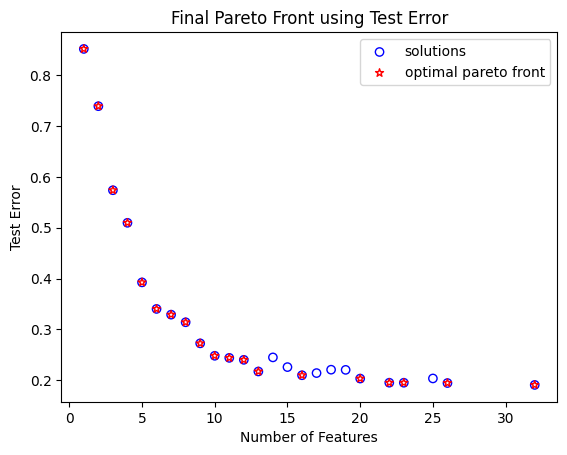

Final PF Results:  {0: {'num_selected_features': 3.0, 'selected_feature_indices': [1, 12, 31], 'train_error': 0.5498923855205327, 'test_error': 0.57390305397878}, 1: {'num_selected_features': 32.0, 'selected_feature_indices': [1, 2, 6, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 37, 38, 39, 44, 46, 47, 48, 49], 'train_error': 0.10685999513786026, 'test_error': 0.19053178697234974}, 2: {'num_selected_features': 1.0, 'selected_feature_indices': [7], 'train_error': 0.8491146344223194, 'test_error': 0.8521156627793923}, 3: {'num_selected_features': 6.0, 'selected_feature_indices': [1, 3, 6, 12, 31, 44], 'train_error': 0.28825379342198043, 'test_error': 0.34017358643300133}, 4: {'num_selected_features': 2.0, 'selected_feature_indices': [4, 22], 'train_error': 0.7117718540164429, 'test_error': 0.7393840435342446}, 5: {'num_selected_features': 4.0, 'selected_feature_indices': [3, 4, 7, 22], 'train_error': 0.4125684857300026, 'test_error': 0.50974684210191

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 3 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 11 features: [False False  True False False False False False False False False False
 False False False  True False  True False False False False False False
  True False  True False False False  True False False  True False False
 False False False False False  True  True False False False False False
  True  True]
INDIVIDUAL 2, 48 features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True]
INDIVIDUAL 3, 48 features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  Tr

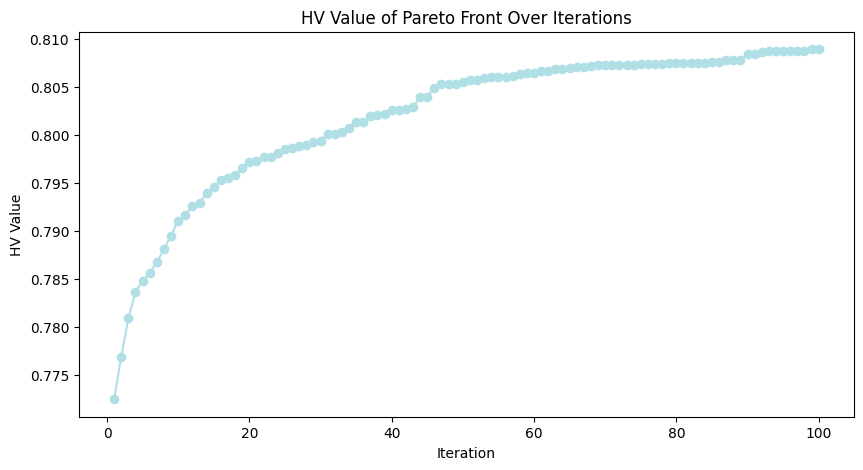

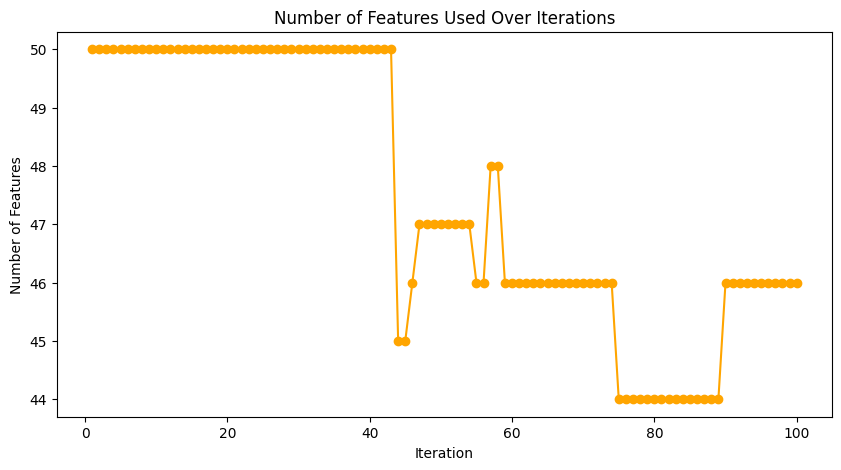

Total population members: 99
Pareto front members: 24


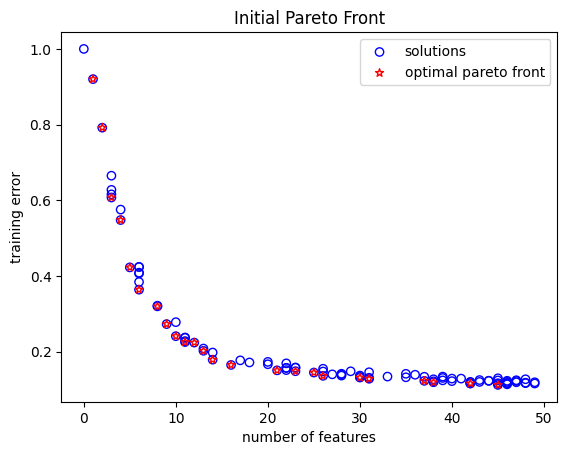

Total population members: 100
Pareto front members: 28


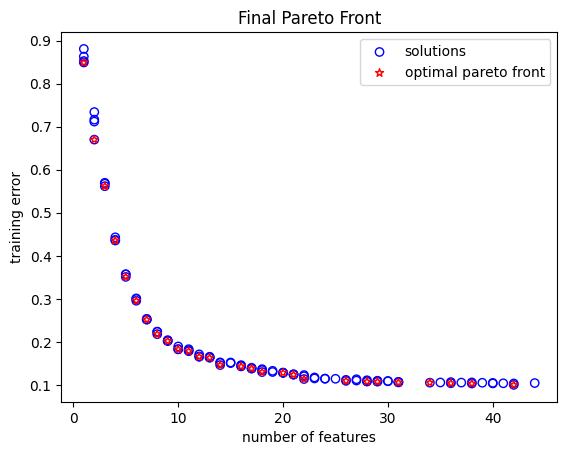

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [7]
classification error on train sets: 0.8491146344223194
classification error on test sets: 0.8521156627793923
solution 1:
number of selected features is: 3.0
corresponding indices: [7, 12, 31]
classification error on train sets: 0.5617488262078318
classification error on test sets: 0.6264714509223486
solution 2:
number of selected features is: 4.0
corresponding indices: [6, 12, 22, 35]
classification error on train sets: 0.43551949918203803
classification error on test sets: 0.5200092048827372
solution 3:
number of selected features is: 5.0
corresponding indices: [6, 9, 12, 31, 34]
classification error on train sets: 0.3509752115066034
classification error on test sets: 0.3986180307694971
solution 4:
number of selected features is: 18.0
corresponding indices: [2, 3, 6, 9, 12, 15, 16, 18, 19, 23, 25, 28, 30, 35, 43, 47, 48, 50]
classi

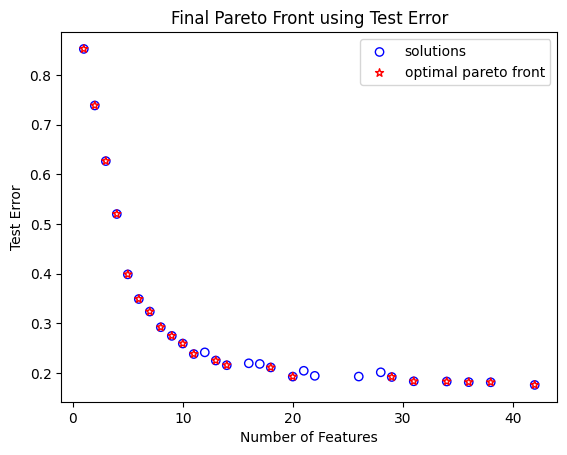

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [7], 'train_error': 0.8491146344223194, 'test_error': 0.8521156627793923}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [7, 12, 31], 'train_error': 0.5617488262078318, 'test_error': 0.6264714509223486}, 2: {'num_selected_features': 4.0, 'selected_feature_indices': [6, 12, 22, 35], 'train_error': 0.43551949918203803, 'test_error': 0.5200092048827372}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [6, 9, 12, 31, 34], 'train_error': 0.3509752115066034, 'test_error': 0.3986180307694971}, 4: {'num_selected_features': 18.0, 'selected_feature_indices': [2, 3, 6, 9, 12, 15, 16, 18, 19, 23, 25, 28, 30, 35, 43, 47, 48, 50], 'train_error': 0.12985978552699784, 'test_error': 0.2113844790248709}, 5: {'num_selected_features': 36.0, 'selected_feature_indices': [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 34, 35, 43, 44, 46,

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 4 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 48 features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False  True  True  True  True  True  True  True  True  True
  True  True]
INDIVIDUAL 2, 21 features: [False  True False False  True  True False False False False False  True
  True False  True  True  True False  True False False  True False  True
 False False False  True False False  True False  True False  True False
 False  True False False False False False  True False  True  True  True
 False  True]
INDIVIDUAL 3, 40 features: [ True  True  True  True  True  True False False  True  True  True False
 False  True  True  True  True  True  True  True  True  True  True  Tr

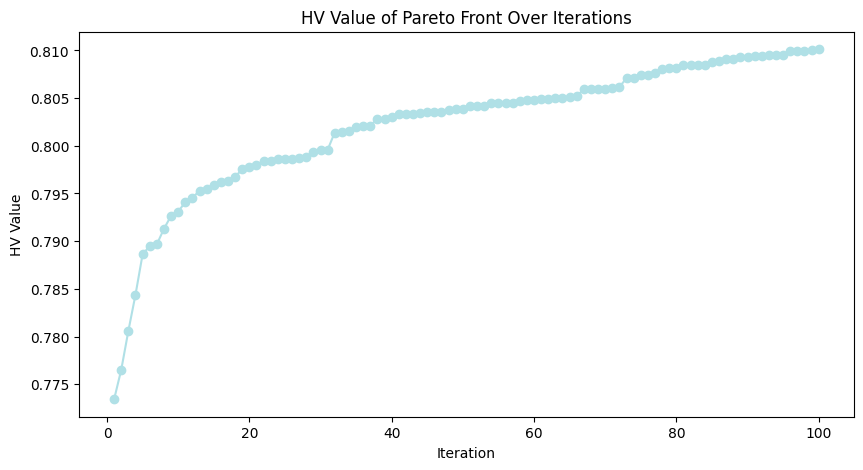

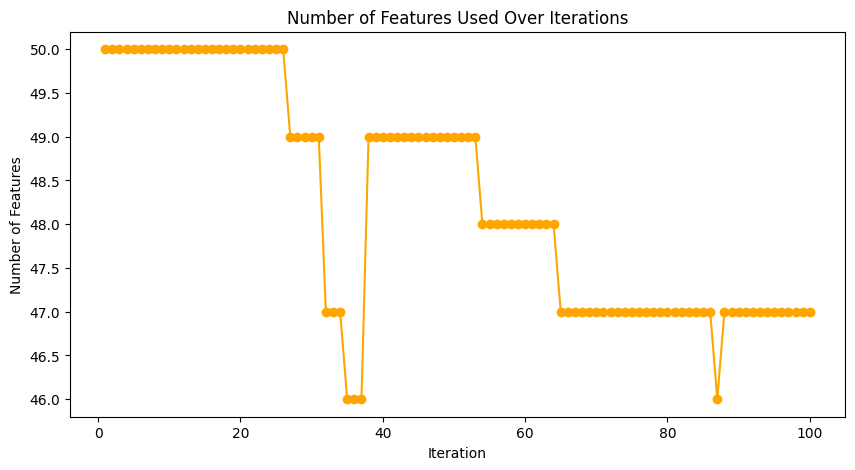

Total population members: 99
Pareto front members: 24


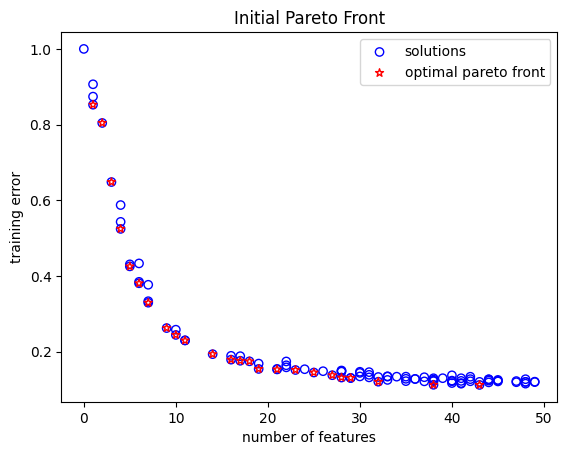

Total population members: 100
Pareto front members: 29


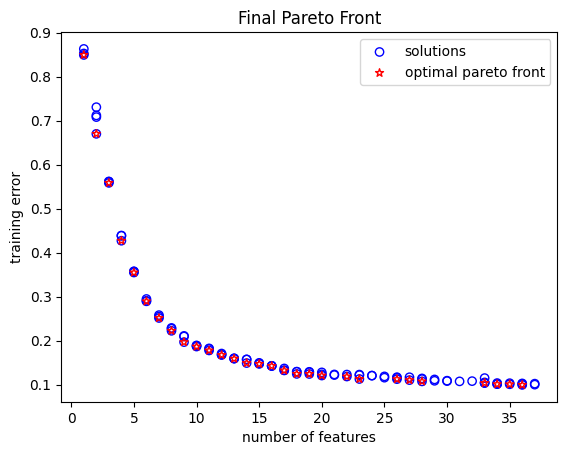

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [7]
classification error on train sets: 0.8491146344223194
classification error on test sets: 0.8521156627793923
solution 1:
number of selected features is: 4.0
corresponding indices: [2, 12, 28, 35]
classification error on train sets: 0.4271327815085936
classification error on test sets: 0.43745924724352403
solution 2:
number of selected features is: 3.0
corresponding indices: [12, 28, 35]
classification error on train sets: 0.5584643801553589
classification error on test sets: 0.5761040795360599
solution 3:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classification error on test sets: 0.7383602898713809
solution 4:
number of selected features is: 26.0
corresponding indices: [1, 2, 3, 4, 5, 6, 10, 11, 12, 15, 16, 17, 19, 20, 24, 25, 26, 27, 30, 34, 35, 44, 4

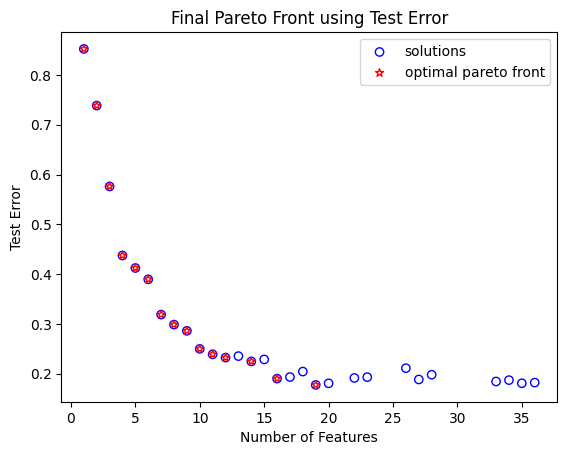

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [7], 'train_error': 0.8491146344223194, 'test_error': 0.8521156627793923}, 1: {'num_selected_features': 4.0, 'selected_feature_indices': [2, 12, 28, 35], 'train_error': 0.4271327815085936, 'test_error': 0.43745924724352403}, 2: {'num_selected_features': 3.0, 'selected_feature_indices': [12, 28, 35], 'train_error': 0.5584643801553589, 'test_error': 0.5761040795360599}, 3: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 4: {'num_selected_features': 26.0, 'selected_feature_indices': [1, 2, 3, 4, 5, 6, 10, 11, 12, 15, 16, 17, 19, 20, 24, 25, 26, 27, 30, 34, 35, 44, 45, 48, 49, 50], 'train_error': 0.11272634669215331, 'test_error': 0.21124366839917486}, 5: {'num_selected_features': 28.0, 'selected_feature_indices': [1, 3, 4, 5, 6, 7, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 29, 31, 33, 34, 35, 37, 44, 48],

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 5 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 23 features: [False False  True False False False  True False False  True  True False
  True False  True False False  True False False  True False False  True
 False  True False False  True  True  True False  True  True  True  True
 False False  True False  True False  True False False  True False  True
  True False]
INDIVIDUAL 2, 4 features: [False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False  True False False False False False False False False False
 False False False False  True False False False False False  True False
 False False]
INDIVIDUAL 3, 34 features: [ True  True False  True False  True False False  True  True  True  True
 False False  True  True False  True  True False  True False  True  Tru

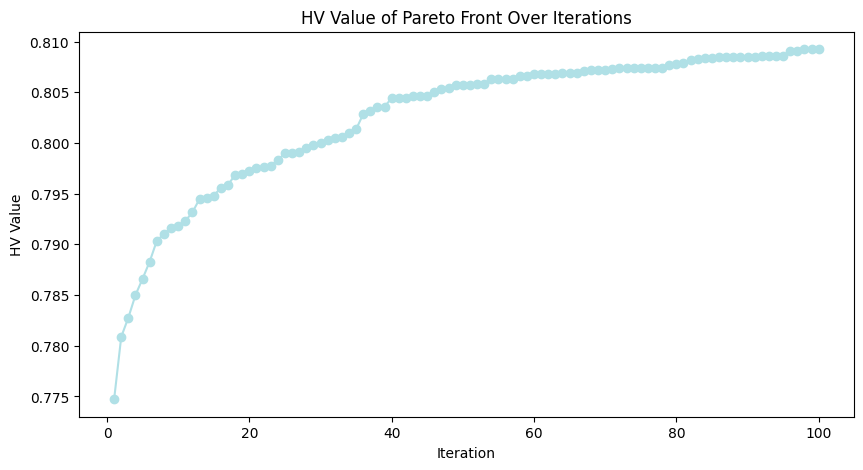

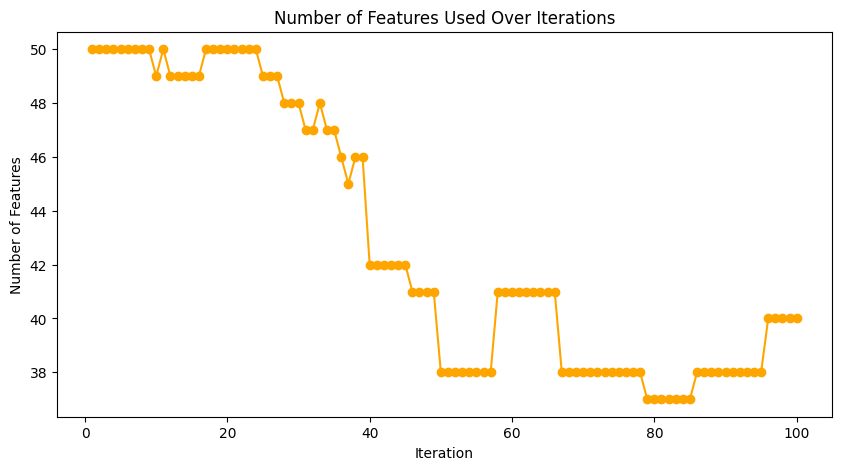

Total population members: 100
Pareto front members: 19


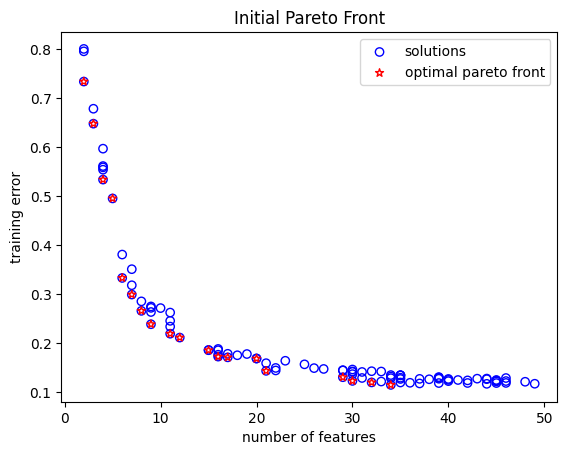

Total population members: 100
Pareto front members: 28


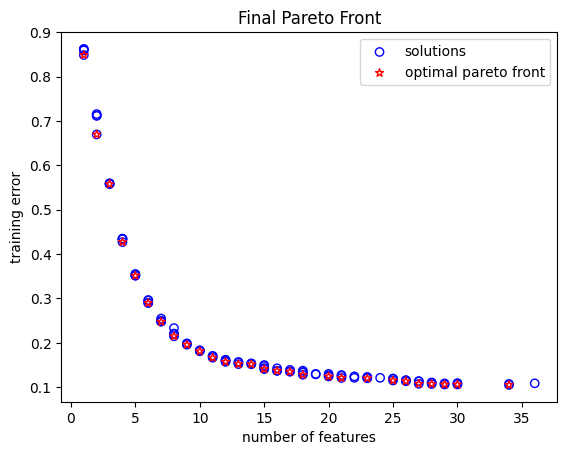

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 4.0
corresponding indices: [2, 12, 28, 35]
classification error on train sets: 0.4271327815085936
classification error on test sets: 0.43745924724352403
solution 1:
number of selected features is: 30.0
corresponding indices: [3, 4, 6, 9, 11, 12, 13, 15, 16, 17, 18, 21, 23, 24, 25, 28, 29, 31, 32, 33, 34, 38, 40, 42, 43, 44, 47, 48, 49, 50]
classification error on train sets: 0.10600445529171565
classification error on test sets: 0.1882886595307297
solution 2:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classification error on test sets: 0.7383602898713809
solution 3:
number of selected features is: 3.0
corresponding indices: [22, 35, 44]
classification error on train sets: 0.5579345523893415
classification error on test sets: 0.6017531406702478
solution 4:
number of selected features i

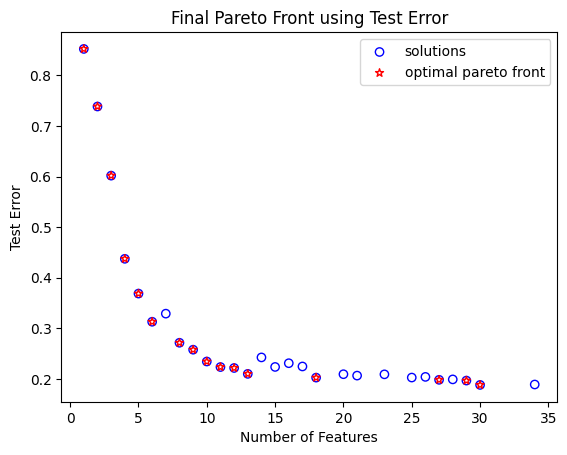

Final PF Results:  {0: {'num_selected_features': 4.0, 'selected_feature_indices': [2, 12, 28, 35], 'train_error': 0.4271327815085936, 'test_error': 0.43745924724352403}, 1: {'num_selected_features': 30.0, 'selected_feature_indices': [3, 4, 6, 9, 11, 12, 13, 15, 16, 17, 18, 21, 23, 24, 25, 28, 29, 31, 32, 33, 34, 38, 40, 42, 43, 44, 47, 48, 49, 50], 'train_error': 0.10600445529171565, 'test_error': 0.1882886595307297}, 2: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 3: {'num_selected_features': 3.0, 'selected_feature_indices': [22, 35, 44], 'train_error': 0.5579345523893415, 'test_error': 0.6017531406702478}, 4: {'num_selected_features': 15.0, 'selected_feature_indices': [2, 3, 6, 7, 12, 13, 15, 16, 23, 25, 28, 32, 34, 43, 47], 'train_error': 0.14065355873160112, 'test_error': 0.22380357779291804}, 5: {'num_selected_features': 21.0, 'selected_feature_indices': [3, 4, 6, 9, 12, 13, 15, 16, 17, 2

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 6 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 26 features: [ True False False  True  True  True False False  True  True False  True
  True  True  True False  True False  True False  True  True  True False
  True False False False  True  True  True False False  True  True  True
 False False  True False False False  True False False  True  True False
 False False]
INDIVIDUAL 2, 20 features: [False  True False  True False False False False  True False False  True
 False False False  True False False  True False False  True False False
 False  True  True  True False False False False False  True  True  True
 False False  True False  True  True False False  True  True  True  True
 False False]
INDIVIDUAL 3, 47 features: [ True  True  True  True  True False False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True False  True  Tr

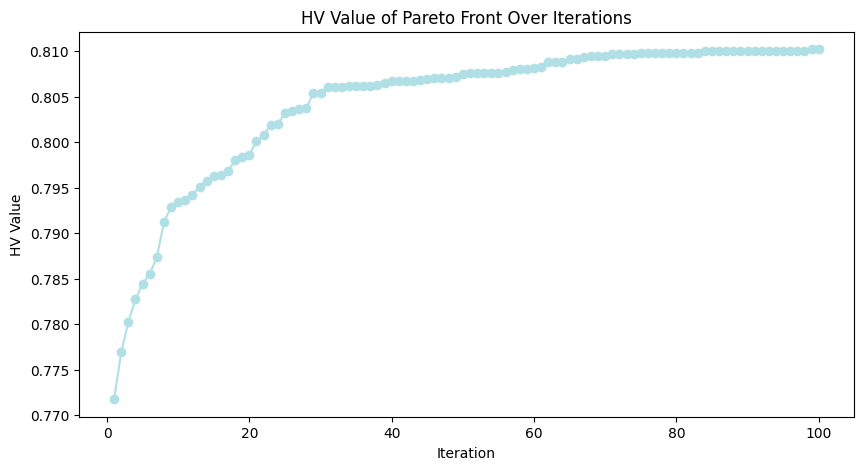

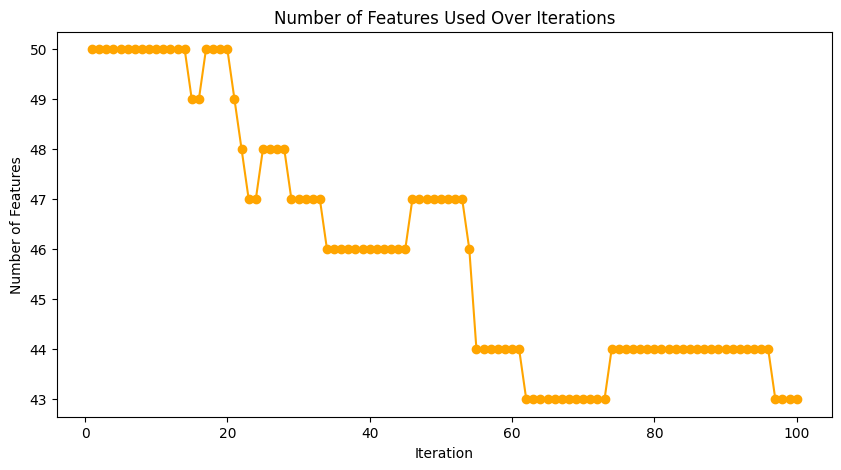

Total population members: 99
Pareto front members: 24


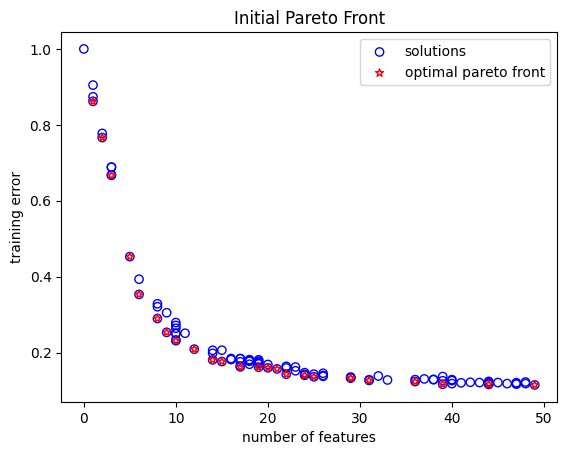

Total population members: 100
Pareto front members: 25


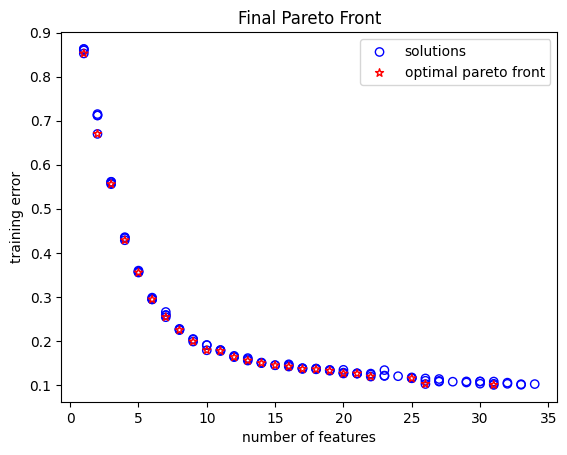

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classification error on test sets: 0.7383602898713809
solution 1:
number of selected features is: 1.0
corresponding indices: [4]
classification error on train sets: 0.8525158032376722
classification error on test sets: 0.8494750751709216
solution 2:
number of selected features is: 3.0
corresponding indices: [3, 4, 22]
classification error on train sets: 0.5558338949442472
classification error on test sets: 0.6034583388608453
solution 3:
number of selected features is: 5.0
corresponding indices: [3, 12, 22, 35, 44]
classification error on train sets: 0.35522060913020614
classification error on test sets: 0.42484932677134213
solution 4:
number of selected features is: 22.0
corresponding indices: [4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 19, 20, 23, 24, 25, 27, 33, 34, 43, 44, 47, 48

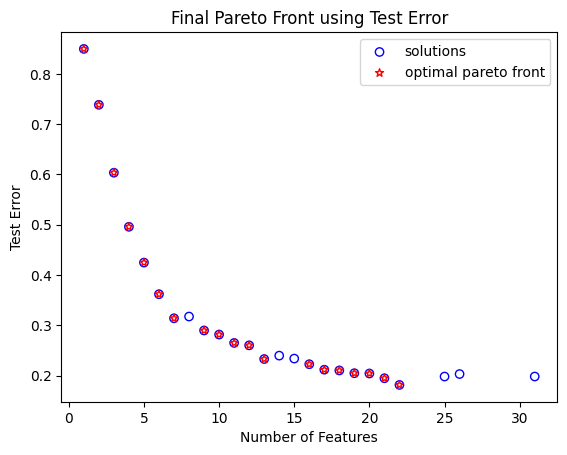

Final PF Results:  {0: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 1: {'num_selected_features': 1.0, 'selected_feature_indices': [4], 'train_error': 0.8525158032376722, 'test_error': 0.8494750751709216}, 2: {'num_selected_features': 3.0, 'selected_feature_indices': [3, 4, 22], 'train_error': 0.5558338949442472, 'test_error': 0.6034583388608453}, 3: {'num_selected_features': 5.0, 'selected_feature_indices': [3, 12, 22, 35, 44], 'train_error': 0.35522060913020614, 'test_error': 0.42484932677134213}, 4: {'num_selected_features': 22.0, 'selected_feature_indices': [4, 5, 6, 7, 8, 9, 13, 14, 15, 17, 19, 20, 23, 24, 25, 27, 33, 34, 43, 44, 47, 48], 'train_error': 0.1191055696714266, 'test_error': 0.1817452565903771}, 5: {'num_selected_features': 4.0, 'selected_feature_indices': [4, 13, 22, 30], 'train_error': 0.4285906818491678, 'test_error': 0.4959905671319812}, 6: {'num_selected_features': 21.0, '

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 7 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 26 features: [ True  True False False  True False  True  True  True  True False  True
 False  True  True  True False  True False  True False False  True False
  True False  True  True  True False False  True False False False  True
 False  True False False False  True False  True  True  True False False
  True False]
INDIVIDUAL 2, 24 features: [False  True  True  True  True False  True False  True False False False
 False False False False  True False False  True False False  True  True
 False  True False False False False  True  True False  True  True  True
  True False False  True False  True False  True  True False  True  True
 False  True]
INDIVIDUAL 3, 35 features: [ True  True  True  True False  True  True False  True  True False  True
 False  True False  True  True  True  True False  True  True  True Fal

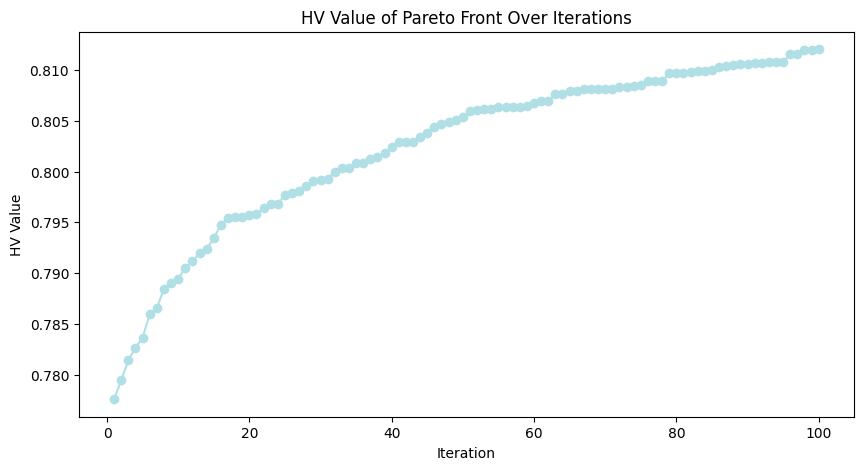

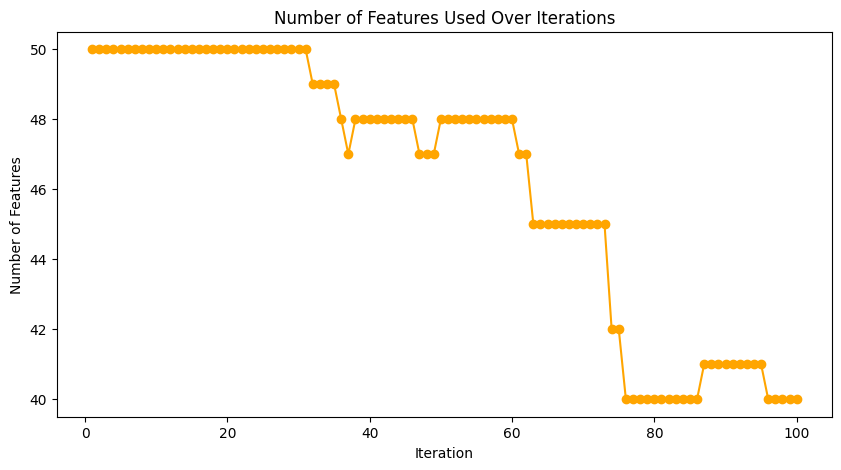

Total population members: 99
Pareto front members: 26


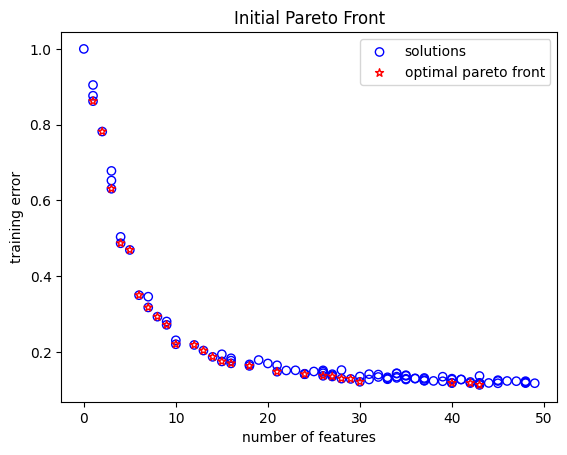

Total population members: 100
Pareto front members: 23


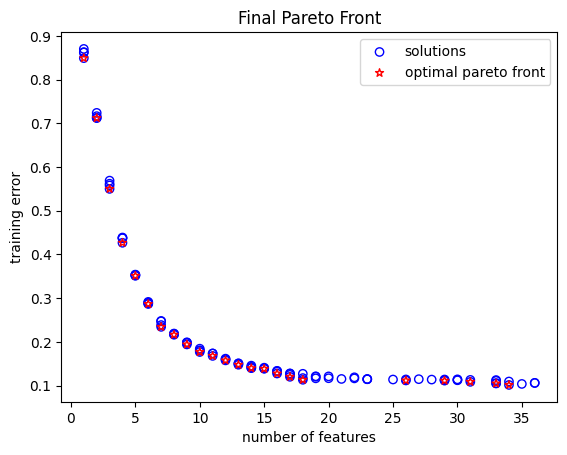

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding indices: [12, 44]
classification error on train sets: 0.7119543606176904
classification error on test sets: 0.7044024391664632
solution 1:
number of selected features is: 3.0
corresponding indices: [1, 12, 31]
classification error on train sets: 0.5498923855205327
classification error on test sets: 0.57390305397878
solution 2:
number of selected features is: 7.0
corresponding indices: [3, 6, 10, 12, 22, 31, 44]
classification error on train sets: 0.23415955954547063
classification error on test sets: 0.3288832543662583
solution 3:
number of selected features is: 6.0
corresponding indices: [3, 7, 10, 12, 22, 31]
classification error on train sets: 0.2865085697145239
classification error on test sets: 0.37715899288760857
solution 4:
number of selected features is: 1.0
corresponding indices: [7]
classification error on train sets: 0.849114634422319

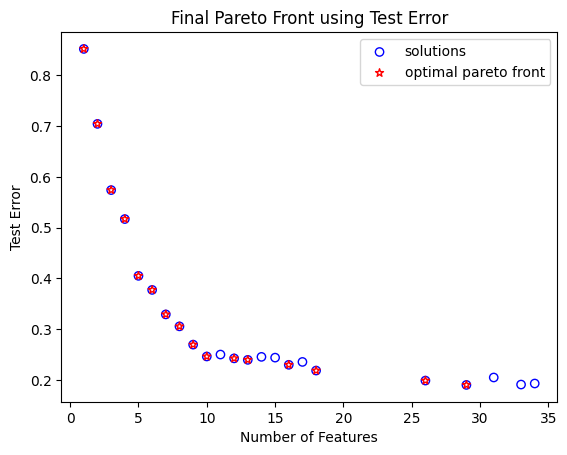

Final PF Results:  {0: {'num_selected_features': 2.0, 'selected_feature_indices': [12, 44], 'train_error': 0.7119543606176904, 'test_error': 0.7044024391664632}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [1, 12, 31], 'train_error': 0.5498923855205327, 'test_error': 0.57390305397878}, 2: {'num_selected_features': 7.0, 'selected_feature_indices': [3, 6, 10, 12, 22, 31, 44], 'train_error': 0.23415955954547063, 'test_error': 0.3288832543662583}, 3: {'num_selected_features': 6.0, 'selected_feature_indices': [3, 7, 10, 12, 22, 31], 'train_error': 0.2865085697145239, 'test_error': 0.37715899288760857}, 4: {'num_selected_features': 1.0, 'selected_feature_indices': [7], 'train_error': 0.8491146344223194, 'test_error': 0.8521156627793923}, 5: {'num_selected_features': 4.0, 'selected_feature_indices': [3, 7, 12, 22], 'train_error': 0.4265707655807969, 'test_error': 0.5168154311437787}, 6: {'num_selected_features': 5.0, 'selected_feature_indices': [6, 10, 12, 22, 31], 'train_er

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 8 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 16 features: [ True  True False False  True False False  True False False False  True
 False False False  True False False False False False False False False
  True  True False False  True False False  True False False False False
 False  True False False False  True  True False False  True False  True
  True False]
INDIVIDUAL 2, 43 features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True  True False False False  True  True  True  True  True  True  True
  True  True  True  True False False  True  True  True  True  True  True
  True False]
INDIVIDUAL 3, 3 features: [False False False False False False False False False False False False
 False False False False  True False False False False False False Fals

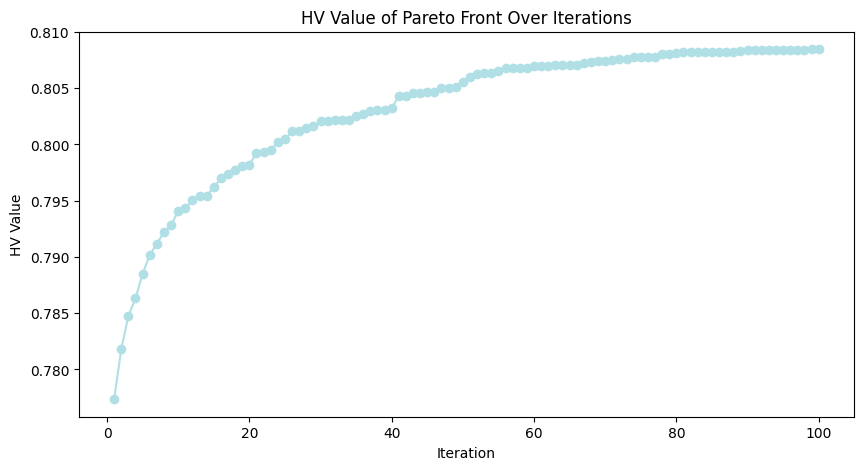

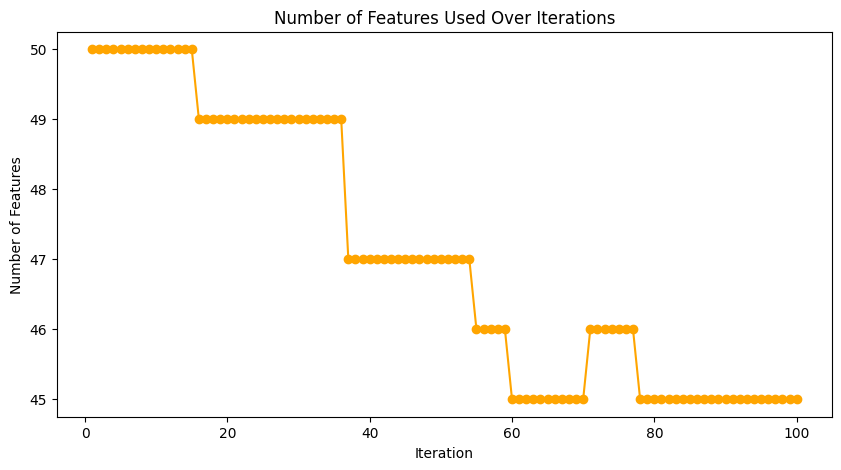

Total population members: 99
Pareto front members: 23


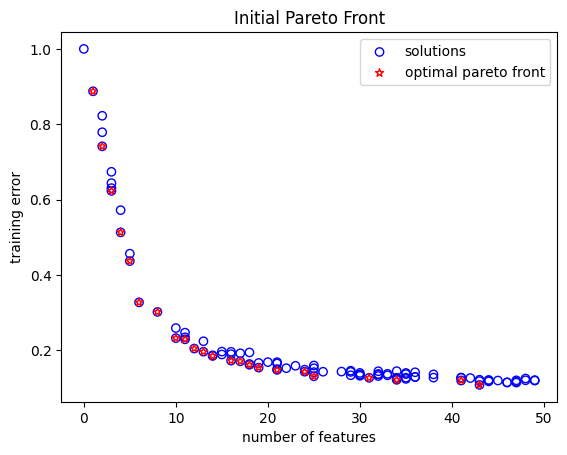

Total population members: 100
Pareto front members: 30


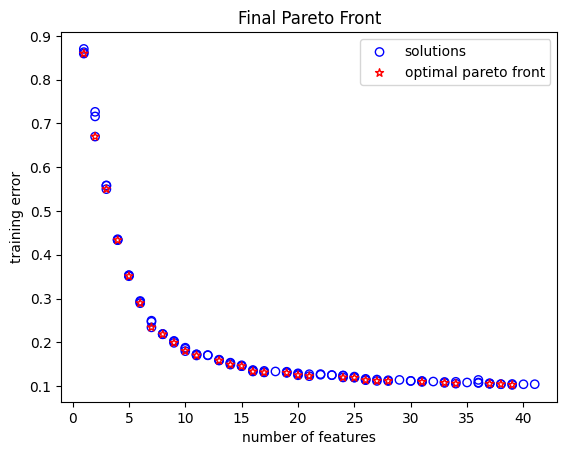

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 1.0
corresponding indices: [47]
classification error on train sets: 0.8594761613627901
classification error on test sets: 0.9127240052683039
solution 1:
number of selected features is: 3.0
corresponding indices: [1, 12, 31]
classification error on train sets: 0.5498923855205327
classification error on test sets: 0.57390305397878
solution 2:
number of selected features is: 6.0
corresponding indices: [3, 6, 10, 12, 22, 31]
classification error on train sets: 0.2893866891531647
classification error on test sets: 0.36832138504748435
solution 3:
number of selected features is: 4.0
corresponding indices: [3, 22, 31, 35]
classification error on train sets: 0.4333167794058984
classification error on test sets: 0.5333848348466237
solution 4:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classific

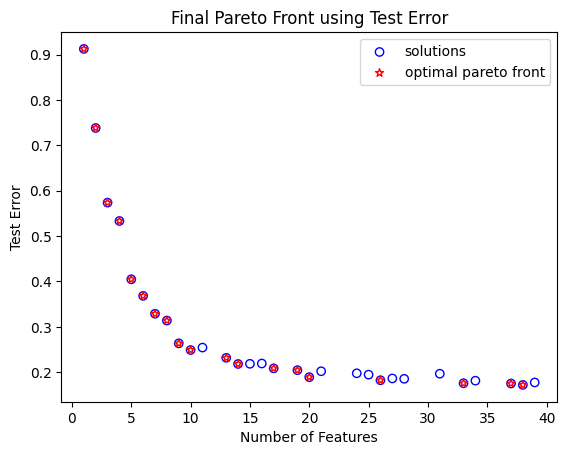

Final PF Results:  {0: {'num_selected_features': 1.0, 'selected_feature_indices': [47], 'train_error': 0.8594761613627901, 'test_error': 0.9127240052683039}, 1: {'num_selected_features': 3.0, 'selected_feature_indices': [1, 12, 31], 'train_error': 0.5498923855205327, 'test_error': 0.57390305397878}, 2: {'num_selected_features': 6.0, 'selected_feature_indices': [3, 6, 10, 12, 22, 31], 'train_error': 0.2893866891531647, 'test_error': 0.36832138504748435}, 3: {'num_selected_features': 4.0, 'selected_feature_indices': [3, 22, 31, 35], 'train_error': 0.4333167794058984, 'test_error': 0.5333848348466237}, 4: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 5: {'num_selected_features': 19.0, 'selected_feature_indices': [3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 23, 25, 27, 28, 46, 48], 'train_error': 0.1301165122650223, 'test_error': 0.20449268511325602}, 6: {'num_selected_features': 27.0, 'selected

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 9 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 35 features: [ True  True  True  True  True False  True  True  True  True False  True
  True  True False  True False  True  True  True  True  True False False
  True  True  True  True False  True False  True  True False  True  True
  True  True  True False False False False  True  True  True  True  True
 False False]
INDIVIDUAL 2, 39 features: [False  True  True  True  True  True False  True False False False  True
  True  True  True  True  True  True  True  True False  True False  True
  True  True  True  True False  True  True  True  True  True False  True
 False  True  True  True  True  True  True  True False  True  True  True
  True  True]
INDIVIDUAL 3, 38 features: [ True False  True False  True  True  True False  True  True  True False
  True  True  True  True  True False  True  True  True  True  True Fal

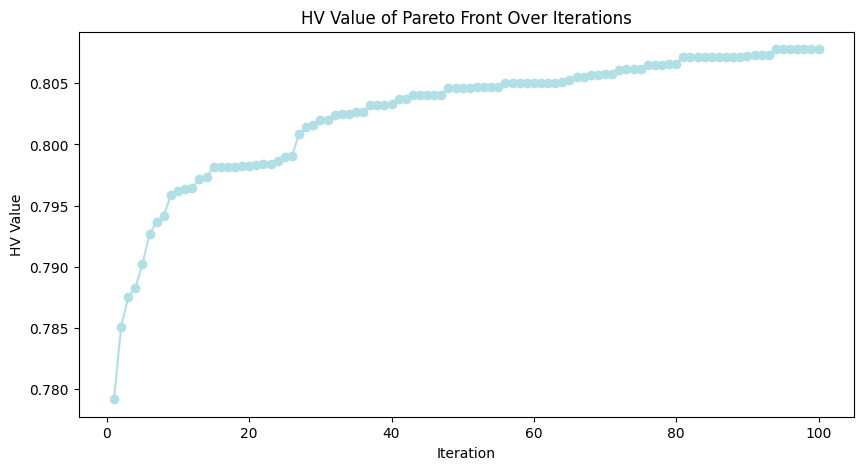

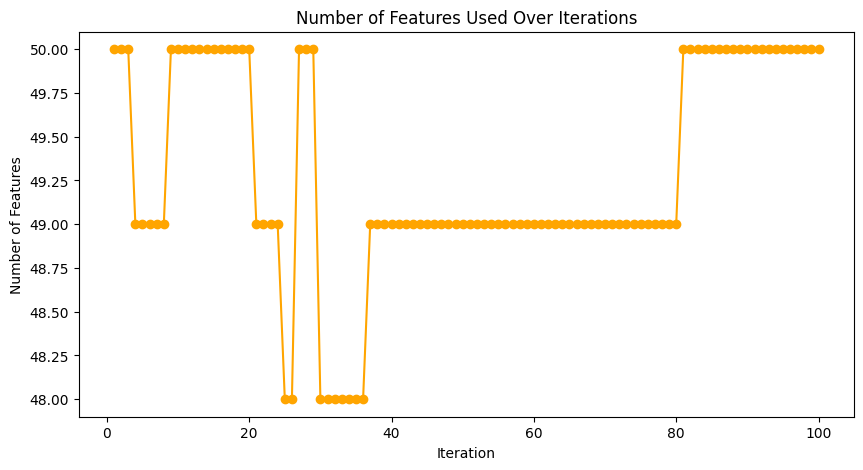

Total population members: 99
Pareto front members: 18


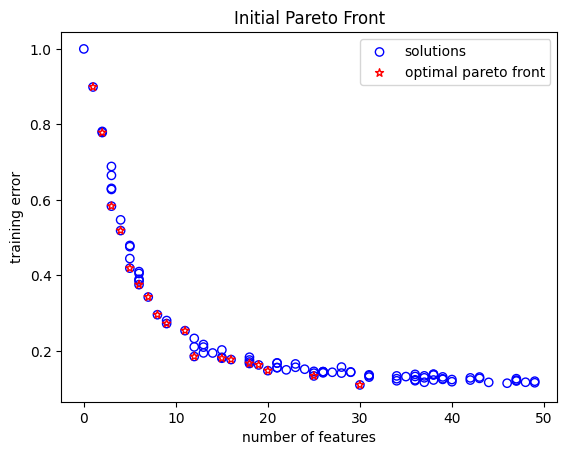

Total population members: 100
Pareto front members: 25


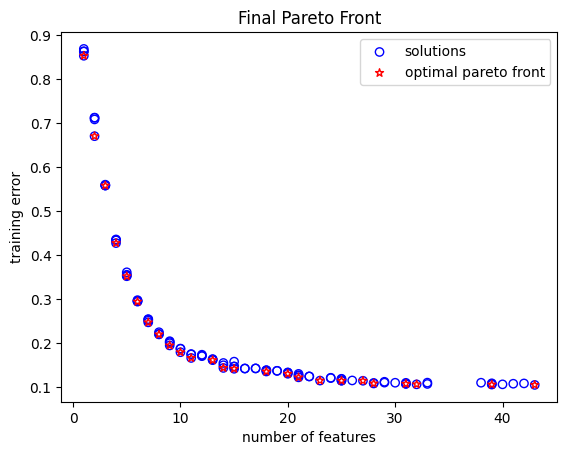

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classification error on test sets: 0.7383602898713809
solution 1:
number of selected features is: 4.0
corresponding indices: [2, 12, 28, 35]
classification error on train sets: 0.4271327815085936
classification error on test sets: 0.43745924724352403
solution 2:
number of selected features is: 20.0
corresponding indices: [3, 4, 6, 9, 10, 11, 12, 13, 15, 22, 23, 24, 25, 28, 30, 32, 34, 43, 45, 46]
classification error on train sets: 0.13031766167496428
classification error on test sets: 0.21903189622060015
solution 3:
number of selected features is: 39.0
corresponding indices: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 36, 38, 40, 41, 42, 43, 44, 45, 48, 49]
classification error on train sets: 0.10582148205542

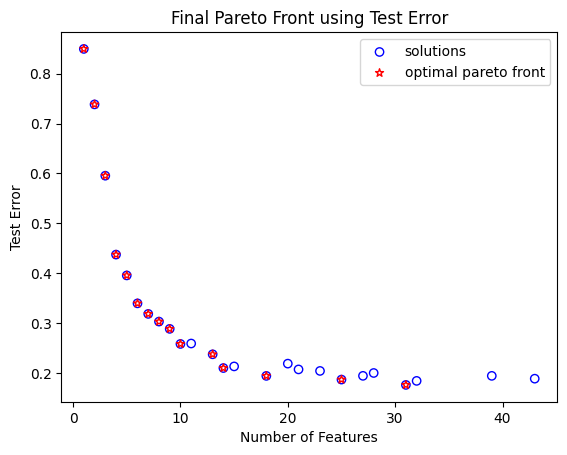

Final PF Results:  {0: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 1: {'num_selected_features': 4.0, 'selected_feature_indices': [2, 12, 28, 35], 'train_error': 0.4271327815085936, 'test_error': 0.43745924724352403}, 2: {'num_selected_features': 20.0, 'selected_feature_indices': [3, 4, 6, 9, 10, 11, 12, 13, 15, 22, 23, 24, 25, 28, 30, 32, 34, 43, 45, 46], 'train_error': 0.13031766167496428, 'test_error': 0.21903189622060015}, 3: {'num_selected_features': 39.0, 'selected_feature_indices': [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34, 36, 38, 40, 41, 42, 43, 44, 45, 48, 49], 'train_error': 0.10582148205542996, 'test_error': 0.1945387913838722}, 4: {'num_selected_features': 9.0, 'selected_feature_indices': [2, 10, 12, 15, 22, 31, 35, 43, 44], 'train_error': 0.1947072609569238, 'test_error': 0.28867900938852176}, 5: {'num_selected_fea

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv
************************************************** RUN 10 **************************************************
TOTAL NUMBER OF FEATURES:  50
INDIVIDUAL 1, 6 features: [False  True False False False False  True False False False False False
 False False False False False False  True False False False False False
 False False  True False False False False False  True False False False
 False False False False False False False False False  True False False
 False False]
INDIVIDUAL 2, 37 features: [ True False  True False  True  True  True  True False  True  True  True
 False  True False  True False  True  True False False  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True False False False  True  True  True  True False  True  True  True
  True  True]
INDIVIDUAL 3, 12 features: [False False False False False  True False False False False  True False
 False False False False  True False False False  True False  True Fal

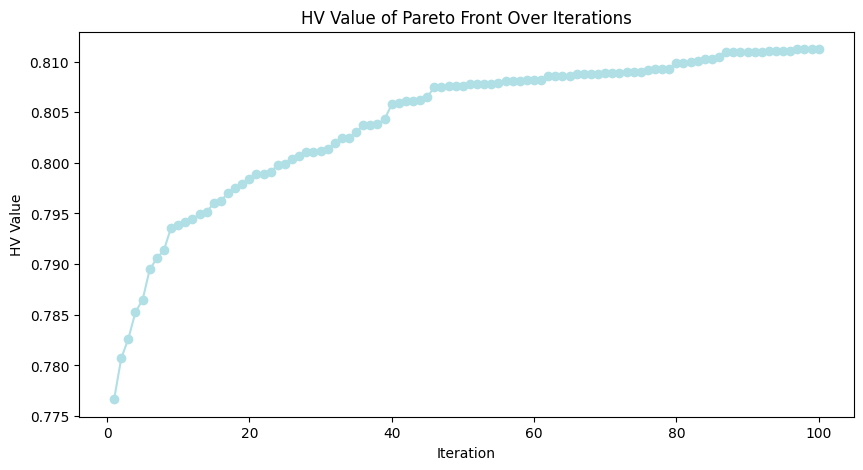

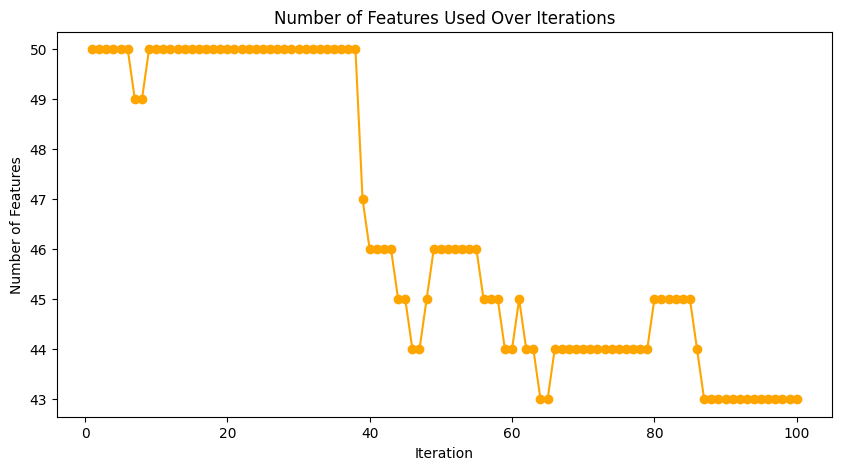

Total population members: 99
Pareto front members: 25


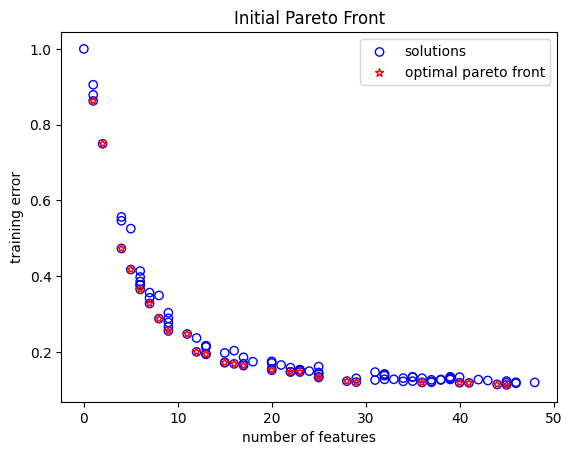

Total population members: 100
Pareto front members: 30


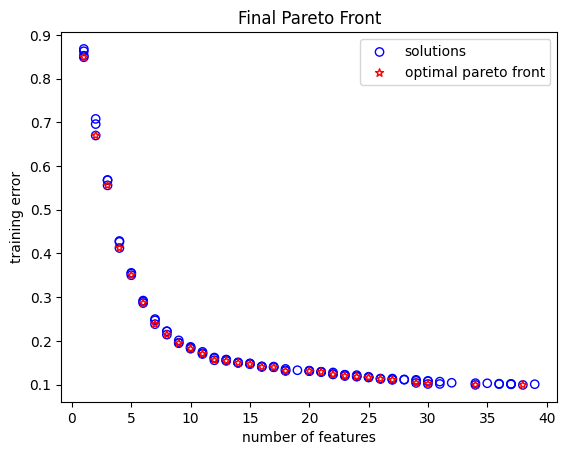

##################################################
Pareto Front Solution Details
solution 0:
number of selected features is: 2.0
corresponding indices: [22, 35]
classification error on train sets: 0.6699254397153429
classification error on test sets: 0.7383602898713809
solution 1:
number of selected features is: 1.0
corresponding indices: [7]
classification error on train sets: 0.8491146344223194
classification error on test sets: 0.8521156627793923
solution 2:
number of selected features is: 3.0
corresponding indices: [3, 4, 22]
classification error on train sets: 0.5558338949442472
classification error on test sets: 0.6034583388608453
solution 3:
number of selected features is: 4.0
corresponding indices: [3, 4, 7, 22]
classification error on train sets: 0.4125684857300026
classification error on test sets: 0.5097468421019128
solution 4:
number of selected features is: 5.0
corresponding indices: [3, 4, 7, 12, 22]
classification error on train sets: 0.35021220512610174
classification e

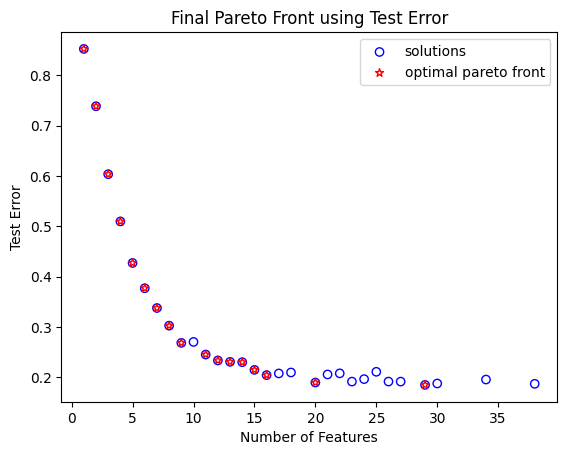

Final PF Results:  {0: {'num_selected_features': 2.0, 'selected_feature_indices': [22, 35], 'train_error': 0.6699254397153429, 'test_error': 0.7383602898713809}, 1: {'num_selected_features': 1.0, 'selected_feature_indices': [7], 'train_error': 0.8491146344223194, 'test_error': 0.8521156627793923}, 2: {'num_selected_features': 3.0, 'selected_feature_indices': [3, 4, 22], 'train_error': 0.5558338949442472, 'test_error': 0.6034583388608453}, 3: {'num_selected_features': 4.0, 'selected_feature_indices': [3, 4, 7, 22], 'train_error': 0.4125684857300026, 'test_error': 0.5097468421019128}, 4: {'num_selected_features': 5.0, 'selected_feature_indices': [3, 4, 7, 12, 22], 'train_error': 0.35021220512610174, 'test_error': 0.4272850405414872}, 5: {'num_selected_features': 21.0, 'selected_feature_indices': [2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 23, 24, 25, 26, 27, 29, 34, 44, 48, 50], 'train_error': 0.12876311407980356, 'test_error': 0.20600777359592992}, 6: {'num_selected_features': 29.0, 'selecte

C:\Users\krish\AppData\Local\Temp\ipykernel_29808\3094704627.py:238: DtypeWarning: Columns (5,6,7,8,15,16,17,18,19,36,37,38,39,40,46,47,48,49,50,51,56,57,58,59,60,70,71,72,73,74,76,77,78,79,80,94,95,96,97,98,101,102,103,104,108,109,110,111,112,118,119,120,121,122,139,140,141,142,149,150,151,152,153,154,159,160,161,162,163,197,198,199,200,207,211,212,213,214,215,221,222,223,224,231,253,254,255,256,262,263,264,265,272,314,315,316,317,324,1097,1098,1099,1100,1101,1103,1104,1105,1106,1107,2124,2125,2126,2127,2128,2130,2131,2132,2133,2134,3151,3152,3153,3154,3155,3157,3158,3159,3160,3161,4178,4179,4180,4181,4182,4184,4185,4186,4187,4188,5205,5206,5207,5208,5209,5211,5212,5213,5214,5215,6232,6233,6234,6235,6236,6238,6239,6240,6241,6242,7259,7260,7261,7262,7263,7265,7266,7267,7268,7269,8286,8287,8288,8289,8290,8292,8293,8294,8295,8296,9313,9314,9315,9316,9317,9319,9320,9321,9322,9323,10340,10341,10342,10343,10344,10346,10347,10348,10355,11367,11368,11369,11370,11371,12394,12395,12396,12397,12

Results saved to data.csv


In [6]:
# Run NSGA2 10 times on top 50 features (i.e., 2-step feature selection)

# Read training data
validation_path = "KimiaNet_Data/kimianet_validation_data_averaged_feature_vectors.csv"
validation = pd.read_csv(validation_path)
dclass = validation.columns[0]
xtrain = validation.drop(columns=[dclass])
ytrain = validation[dclass]

# Read test data
test_path = "KimiaNet_Data/kimianet_test_data_averaged_feature_vectors.csv"
test = pd.read_csv(test_path)
dclass = test.columns[0]
xtest = test.drop(columns=[dclass])
ytest = test[dclass]

# Filter test and training data for top 50 features only
top_50 = pd.read_csv("Top_NSGA2_Features.csv").head(50)
print(top_50)
featureNames = []
for i in top_50['Feature'].tolist():
    featureNames.append(xtrain.columns[i-1]) #featureNames has feature names from 1-1024, not indices; so, to access feature x, we need to go to index i-1
xtrain = xtrain[featureNames]
xtest = xtest[featureNames]
print(xtrain)

for run in range(10):
    print("*"*50, f"RUN {run+1}", "*"*50)
    dataset_name = f"RUN {run+1}: 2-step feature selection (NSGA2 on top 50 features)"
    # Split the data into 70/30 train/test, ensuring proportional class distributions (using stratify)
    #xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42+run)

    # Generate initial population members
    total_features = xtrain.shape[1] 
    print("TOTAL NUMBER OF FEATURES: ", total_features)
    custom_population = generate_individuals(total_features)
    population = Population.new("X", custom_population)

    # Set up NSGA2 algorithm
    problem = MyProblem(xtrain, ytrain)
    Evaluator().eval(problem, population) # evaluate initial population
    algorithm = NSGA2(pop_size=100,
                    sampling=population,
                    crossover=UniformCrossover(prob=0.9),
                    mutation=BitflipMutation(prob=0.01),
                    eliminate_duplicates=True)
    res = minimize(problem,
                algorithm,
                ("n_gen", 100),
                verbose=True,
                save_history=True)

    # Get data from NSGA2 algorithm
    final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training = nsga2_results(res, xtrain, ytrain, xtest, ytest)

    # Store NSGA2 results
    store_results(dataset_name, final_pf_results, final_test_pf_results, lowest_train_error_solution, lowest_test_error_solution, hv_test, hv_training)